<a href="https://colab.research.google.com/github/Andrea987/advtrain-linreg/blob/main/notebooks/fig1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
from re import VERBOSE
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.linear_model import lasso_path
from sklearn import datasets
from sklearn import linear_model
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import tqdm
import cvxpy as cp
print(cp.installed_solvers())
import numpy as np
import copy

import traceback


def compute_q(p):
    if p != np.inf and p > 1:
        q = p / (p - 1)
    elif p == 1:
        q = np.inf
    else:
        q = 1
    return q


class AdversarialTraining:
    def __init__(self, X, y, S_dict, p):  # S is the matrix such that ||S^(-1) @ Dx||\leq delta. As a consequence, S appears in the unconstrained problem
        # S: (d, d) matrix, or S = np.concatenate(tS), with tS = [S1,..,S_m], so S is (d * n, d)
        n, d = X.shape
        q = compute_q(p)

        #print("who is X", X)
        #print("who is y", y)
        #print("who is S", S)
        #print("who is q in AdversarialTraining: ", q)
        #Formulate problem
        param = cp.Variable(d)
        #print("shape param ", param.shape)
        #print("dim ", n)
        print("X ", n," ", d)
        print("y shape", y.shape)
        #print("S_dict ", S_dict)
        #print("S in adv training", S)
        print("nm ", d*n)
        S_dts = S_dict['S_dts']
        S_mis = S_dict['S_mis']
        adv_radius_times_scale_dts = cp.Parameter(name='adv_radius_times_dts', nonneg=True)
        adv_radius_times_scale_mis = cp.Parameter(name='adv_radius_times_mis', nonneg=True)
        #scale_dts = cp.Parameter(name='scale_dts', nonneg=True)
        #scale_mis = cp.Parameter(name='scale_mis', nonneg=True)
        print("S_mis in Adbvt training ", S_mis)
        #if np.sum(S_mis * S_mis) == 0:
        if np.all(S_dict['S_mis'] == 0):
          print("no missing part")
          S = S_dts * adv_radius_times_scale_dts
        else:  # S_mis.shape == (n, d, d):
          S_dts_tiled = np.concatenate([S_dts] * n)
          S_mis_conc = np.concatenate(S_mis)
          #np.concatenate([yyy] * 2)
          S = S_dts_tiled * adv_radius_times_scale_dts + S_mis_conc * adv_radius_times_scale_mis
          print("S type ", type(S))
          #S = np.concatenate(S)
          print("S is a tensor, concatenated")
          print("final S after conc \n", S)

        if S.shape == (d, d):
          print("one matrix in input, S.shape = (n, n)")
          partial = S @ param  # should be (m * n,)
          param_norm = cp.pnorm(partial, p=q)
        elif S.shape == (d * n, d):  # should be a stack of matrices
          print("multiple matrices in input, S conc")
          partial = S @ param  # should be (m * n,)
          partial = cp.reshape(partial, (n, d), order='C')
          param_norm = cp.pnorm(partial, p=q, axis=1)
        else:
          print("--------> ERROR: NO MATRIX S FOUND IN ADVERSARIAL TRAINING")
        #elif S.shape == (m , n):  # stack of diagonal matrices
        #  print("multiple matrices in input, S_i diag")
          #S_cvx = cp.Constant(S)
        #  partial = cp.multiply(cp.Parameter(S), param)
        #  param_norm = cp.pnorm(partial, p=q, axis=1)
        abs_error = cp.abs(X @ param - y)
        adv_loss = 1 / n * cp.sum((abs_error + param_norm) ** 2)
        prob = cp.Problem(cp.Minimize(adv_loss))
        self.prob = prob
        self.adv_radius_times_scale_dts = adv_radius_times_scale_dts
        self.adv_radius_times_scale_mis = adv_radius_times_scale_mis
        #self.scale_dts = scale_dts
        #self.scale_mis = scale_mis
        self.param = param
        self.warm_start = False


    def __call__(self, dict_hyper_p, **kwargs):
        try:
            #print("dic thyper p ", dict_hyper_p)
            self.adv_radius_times_scale_dts.value = dict_hyper_p['adv_radius_times_dts']
            self.adv_radius_times_scale_mis.value = dict_hyper_p['adv_radius_times_mis']
            #self.scale_dts.value = dict_hyper_p['scale_dts
            #self.scale_mis.value = dict_hyper_p['scale_mis']
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v

'''
    def __call__(self, adv_radius, **kwargs):
        try:
            self.adv_radius.value = adv_radius
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v
'''


def get_lasso_path(X, y, eps_lasso=1e-5):
    alphas, coefs, _ = lasso_path(X, y, eps=eps_lasso)
    coefs= np.concatenate([np.zeros([X.shape[1], 1]), coefs], axis=1)
    alphas = np.concatenate([1e2 * np.ones([1]), alphas], axis=0)
    return alphas, coefs, []

# dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 1, 'eps_adv_rad_times_delta_dts': 1e-4 'eps_adv_rad_times_delta_dts': 1e-4}}
def get_path(X, y, estimator, S_dict): #eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):
    _, m = X.shape
    n_a_dts = S_dict['n_a_dts']
    a_d_dts_max = S_dict['adv_rad_times_delta_dts_max']
    a_d_dts_min = a_d_dts_max * S_dict['eps_adv_rad_times_delta_dts']
    if np.all(S_dict['S_mis'] == 0):
      n_a_mis, a_d_mis_max, a_d_mis_min = 1, 0, 0
    else:
      n_a_mis = S_dict['n_a_mis']
      a_d_mis_max = S_dict['adv_rad_times_delta_mis_max']
      a_d_mis_min = a_d_mis_max * S_dict['eps_adv_rad_times_delta_mis']


    if a_d_dts_max < 0 or a_d_mis_max < 0 or n_a_dts < 1 or n_a_mis <1:
      print("WARNING: some bad values for the grid of cross validation, the number of grid point should be strictly potive, the radius strictly positive")
    alphas_dts = np.logspace(np.log10(a_d_dts_min), np.log10(a_d_dts_max), n_a_dts) if a_d_dts_max > 0 else np.zeros(1)
    alphas_mis = np.logspace(np.log10(a_d_mis_min), np.log10(a_d_mis_max), n_a_mis) if a_d_mis_max > 0 else np.zeros(1)
    #alphas_dts = np.logspace(np.log10(a_d_dts_min), np.log10(a_d_dts_max), n_a_dts)
    #alphas_mis = np.logspace(np.log10(a_d_mis_min), np.log10(a_d_mis_max), n_a_mis)
    print("dts deltas ", alphas_dts)
    print("mis deltas ", alphas_mis)
    #hyper_p = {'scale_dts': dts_deltas, 'scale_mis': mis_deltas}
    hyper_p_ret_ = []
    coefs_ = []
    for a_mis_value in tqdm.tqdm(alphas_mis):
      for a_dts_value in tqdm.tqdm(alphas_dts):
          #tuple_key = (scale_dts_value, scale_mis_value)
          #coefs_ = []
          #for a in tqdm.tqdm(alphas):
            #dict_hyper_p_values = {'adv_radius': a, 'scale_dts': scale_dts_value, 'scale_mis': scale_mis_value}
            dict_hyper_p_values = {'adv_radius_times_dts': a_dts_value, 'adv_radius_times_mis': a_mis_value}
            #print("dict hyper in get path ", dict_hyper_p_values)
            coefs = estimator(X, y, dict_hyper_p_values)
            #print("alpha  ", a, "coef: ", coefs)
            coefs_.append(coefs if coefs is not None else np.zeros(m))
            hyper_p_ret_.append([a_dts_value, a_mis_value])
          #res[tuple_key] = np.stack((coefs_)).T
    '''
    for scale_dts_value in tqdm.tqdm(dts_deltas):
        for scale_mis_value in tqdm.tqdm(mis_deltas):
          #tuple_key = (scale_dts_value, scale_mis_value)
          #coefs_ = []
          for a in tqdm.tqdm(alphas):
              #dict_hyper_p_values = {'adv_radius': a, 'scale_dts': scale_dts_value, 'scale_mis': scale_mis_value}
              dict_hyper_p_values = {'adv_radius_times_scale_dts': a * scale_dts_value, 'adv_radius_times_scale_mis': a * scale_mis_value}
              coefs = estimator(X, y, dict_hyper_p_values)
              #print("alpha  ", a, "coef: ", coefs)
              coefs_.append(coefs if coefs is not None else np.zeros(m))
              hyper_p_ret_.append([a, scale_dts_value, scale_mis_value])
          #res[tuple_key] = np.stack((coefs_)).T
    '''
    return np.stack((hyper_p_ret_)).T, np.stack((coefs_)).T

'''
def get_path(X, y, estimator, amax, eps=1e-5, n_alphas=200):
    _, m = X.shape
    amin = eps * amax
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    coefs_ = []
    for a in tqdm.tqdm(alphas):
        coefs = estimator(X, y, a)
        #print("alpha  ", a, "coef: ", coefs)
        coefs_.append(coefs if coefs is not None else np.zeros(m))
    return alphas, np.stack((coefs_)).T
'''


def plot_coefs(alphas, coefs, ax):
    #print("you are printing coefs in function of 1/alphas")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).sum(axis=0)
    ax.set_xlabel("1/alphas")
    ax.set_ylabel("coef")
    for coef_l, c in zip(coefs, colors):
        ax.semilogx(1/alphas, coef_l, c=c)
        #ax.semilogx(1/alphas, l1norm, c=c)
        #ax.plot(1/alphas, coef_l, c=c)


def plot_coefs_l1norm(coefs, ax):
    #print("you are printing coeff in function of l1 norm")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).mean(axis=0)
    l1norm = np.abs(coefs).sum(axis=0)
    #print("coef ", coefs)
    #print("l1norm ", l1norm)
    ax.set_xlabel("l1norm")
    ax.set_ylabel("coef")


    for coef_l, c in zip(coefs, colors):
        ax.plot(l1norm, coef_l, c=c)


def train_and_plot(X, y, S_dict, list_ax):
    linfadvtrain = AdversarialTraining(X, y, S_dict, p=np.inf)
    estimator = lambda X, y, dic_h:  linfadvtrain(dict_hyper_p=dic_h)
    hyper_p, coefs_advtrain_linf  = get_path(X, y, estimator, S_dict)
    #print("hyper_p used\n ", hyper_p)
    if len(list_ax) > 0:
      plot_coefs_l1norm(coefs_advtrain_linf, list_ax[0])
      plot_coefs(alphas_adv, coefs_advtrain_linf, list_ax[1])
    return hyper_p, coefs_advtrain_linf

'''
def add_rectangles_old(x, y, box_width, box_height, ax):
  r_c = (np.random.binomial(1, 1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)

  for xi, yi in zip(x[r_c], y[r_c]):
      rect = patches.Rectangle(
        (xi-box_width/2, yi-box_height/2),
        box_width, box_height,
        linewidth=1, edgecolor='r', facecolor='none'
      )
      ax.add_patch(rect)
'''

def add_rectangles(x, y, S, ax):
  r_c = (np.random.binomial(1, 1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)
  d = S.shape[-1]
  #S = S * 100
  if S.ndim == 2 or S.shape == (1, d, d):
    S = S.squeeze()
    print("------------------------> who is S in add_rectangles\n", S)
    box_width = S[0, 0]
    box_height = S[1, 1]
    for xi, yi in zip(x[r_c], y[r_c]):
        rect = patches.Rectangle(
          (xi-box_width/2, yi-box_height/2),
          box_width, box_height,
          linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
  else:  # S is something like (n, d, d)
    #print("---------------> who is S in add_rectangles (mult imp)\n", S)
    box_width = S[:, 0, 0]
    box_height = S[:, 1, 1]
    #print("bw\n ", box_width)
    #print("bh\n ", box_height)
    #print("------------------------------> boxes printed")
    for xi, yi, bw, bh in zip(x[r_c], y[r_c], box_width[r_c], box_height[r_c]):
        #print("bw, bh ", bw, ",   ", bh)
        rect = patches.Rectangle(
          (xi-bw/2, yi-bh/2),
          bw, bh, linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
    ax.set_aspect('equal')



print("end block")


['CLARABEL', 'CVXOPT', 'GLPK', 'GLPK_MI', 'HIGHS', 'OSQP', 'SCIPY', 'SCS']
end block


In [3]:
# imputation's block

def clear_dataset(X, y, masks):
  # remove observations full NaN
  # X is an (n, d) matrix, y is a (n,) vector,
  # masks is an (n, d) binary matrix associated to X. 1 missing, 0 seen
  M = np.sum(1 - masks, axis=1) > 0
  M_col = np.sum(1 - masks, axis=0) > 0  # True if in the column there is at least one seen component
  if np.sum(M_col) < masks.shape[1]:
    print("Careful, there is one column full of nan")
  return X[M, :][:, M_col], y[M], masks[M, :][:, M_col]


def single_imputation(X_nan, impute_estimator):
    ice = IterativeImputer(estimator=impute_estimator)
    return ice.fit_transform(X_nan)


def multiple_imputation(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 100000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res shape", res.shape)
       #if nbr_mi == 1:
        #res = res[0, :, :]
        #print("fin res shape", res.shape)
    return res


def imputation_elliptic(mu, sigma, x, masks):
  # mu, mean elliptical distribution (,d)
  # sigma, cov matrix elliptical distribution (d, d)
  # x: dataset (n, d)
  # masks: mask data, 0 seen, 1 missing
  n, d = x.shape
  print(n, d)
  x_imp = x.copy()
  #print("x_imp clean", x_imp)
  for i in range(n):
    if not (masks[i, :] == 0).all():  # if we have at least one missing component
      #print("nbr : ", i)
      x_c = x[i, :]
      m_bool = (masks[i, :] == 0)  # True seen, False missing
      sigma_aa_inv = np.linalg.inv(sigma[m_bool, :][:, m_bool])
      sigma_ma = sigma[~m_bool, :][:, m_bool]
      mu_cond = mu[~m_bool] + sigma_ma @ sigma_aa_inv @ (x_c[m_bool] - mu[m_bool])
      x_imp[i, ~m_bool] = mu_cond
  return x_imp


def listwise_delection(X, masks):
  # masks: 1 missing, 0 seen
    M = np.sum(masks, axis=1) == 0  # zeros components are the one with full entries
    ret = X[M, :] if X.ndim == 2 else X[M]
    return ret


In [4]:
#np.random.seed(42)

#p_miss_2d = [0.2, 0.4, 0.4]
#beta_2d = np.array([0.5, 2])  # ground truth

from sklearn.datasets import make_moons, make_circles
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split
'''
def generate_masks_2d(nbr_of_sample, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    masks = np.zeros((nbr_of_sample, 2))
    v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
    masks[v == 0, :] = np.array([0, 0])  # both seen
    masks[v == 1, :] = np.array([0, 1])  # left seen
    masks[v == 2, :] = np.array([1, 0])  # right seen
    return masks
'''

def generate_masks(dictio_data):#nbr_of_sample, dim, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    dim = len(dictio_data['beta_gt'][0])
    nbr_of_sample = dictio_data['n_train'][0]
    p_missing = dictio_data['p_miss'][0]
    print("p_missing in generate mask ", p_missing)
    if dim == 2:
      if len(p_missing) < 3:
        print("WARNING: p_missing should be a list with a length of 3 if the dimension is 2")
      masks = np.zeros((nbr_of_sample, 2))
      v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
      masks[v == 0, :] = np.array([0, 0])  # both seen
      masks[v == 1, :] = np.array([0, 1])  # left seen
      masks[v == 2, :] = np.array([1, 0])  # right seen
    else:
      # in this branch, p_missing = [p1,.., pl],
      masks = np.array([np.random.binomial(1, 1-pr, (nbr_of_sample, dim)) for pr in p_missing])
      masks = np.cumsum(masks, axis=0)  # each round
      masks[masks>1] = 1
    return masks

def best_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  score = np.mean(r * r, axis=1)
  print("scores:  ", score)
  i_min = np.argmin(score)
  return coeff[:, i_min], score[i_min]

def best_idx_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  #score = np.mean(r * r, axis=1)
  score = np.mean(r * r, axis=1)
  #print("score in best idx", score)
  i_min = np.argmin(score)
  #### find the minimum value with a threshold, so we get bigger uncertainty set that are visible
  min = np.min(score)
  max = np.max(score)
  score[ score < min + -1 ] = max
  ####
  #print("score after ", score)
  i_min = np.argmin(score)
  return i_min, score[i_min]



def generate_X(data, dim):
    if data == 'Gaussian':
      def generator(n):
        return np.random.randn(n, dim)
    elif data == 'Uniform':
      def generator(n):
        return np.random.rand(n, dim)
    elif data == 'moons':
      def generator(n):
        return make_moons(n, noise=0.1)[0]
    elif data == 'circles':
      def generator(n):
        return make_circles(n, noise=0.1, factor=0.4)[0]
    return generator


In [14]:
# experiment 2d with dataset generated externally

def imputations(info, dict_obs_for_imp):  # X_nan, y):
  # info contains the method and possible extra information
  # X_nan is the dataset with nan in place of the missing components
  # y is return as it is, unless the method require to change it, like in
  # listwise deletion
    #print(info)
    X_nan = dict_obs_for_imp['X_nan']
    y = dict_obs_for_imp['y_train']
    mask_from_X_nan = np.isnan(X_nan).astype(int)
    if info['imp_method'] == 'BR_si':  # Baeysian_Ridge_single_imputation
        X = single_imputation(X_nan, BayesianRidge())
    elif info['imp_method'] in  ['mi', 'mi_pure']:
        X = multiple_imputation(info['mi_nbr'], X_nan)  # size (info['mi_nbr], n, d)
    elif info['imp_method'] == 'l_d':  # listwise_deletion
        #mask_from_X_nan = np.isnan(X_nan).astype(int)
        X = listwise_delection(X_nan, mask_from_X_nan)
        y = listwise_delection(y, mask_from_X_nan)
        if len(X) == 0:  # no elements left, add an artificial element
            X = np.zeros((1, X_nan.shape[-1]))
            y = np.zeros(1)
        mask_from_X_nan = np.zeros_like(X)
    elif info['imp_method'] == 'oracle':
        X = dict_obs_for_imp['X_train_masked'][0]
        mask_from_X_nan = np.zeros_like(X)
    else:
      print("-------------------> ERROR: WRONG KEYWORD (in imputations)")
    return X, y, mask_from_X_nan


def cov_strategy(info, dict_observations):
    X_imputed = dict_observations['X_imputed']
    X_nan = dict_observations['X_nan']
    masks = dict_observations['masks_after_imputation']
    print(np.sum(masks, axis=-1))
    if info['cov_strategy'] == 'sd':
      sd = np.std(X_imputed, axis=0)
      #print("sd in cov strategy ", sd)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    elif info['cov_strategy'] == 'inv_sd':
      sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(1 / sd)
    elif info['cov_strategy'] == 'zero':
      #sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.zeros((X_imputed.shape[-1], X_imputed.shape[-1]))
    elif info['cov_strategy'] == 'eye':
      S = np.eye(X_imputed.shape[-1])
    elif info['cov_strategy'] == 'threshold':
      sd = np.std(X_imputed, axis=0)
      sd[sd < info['threshold']] = info['threshold']
      #S = np.diag(sd) The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    elif info['cov_strategy'] == 'std_nan':
      if info['imp_method'] in ['oracle']:
        print("DON'T USE std_nan with oracle and ld because you do not have any nan. Use sd")
      else:
        std_columnwise = np.nanstd(X_nan, axis=0)
        S = np.diag(std_columnwise)
    elif info['imp_method'] in ['mi_pure', 'mi']:
      if info['cov_strategy'] == 'std_mi':   # std of the imputed dataset, then the mean
        std_vectors = np.std(X_imputed, axis=-2)  # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        S = np.diag(s_within)
        print("final S in cov strategy std_mi ", S)
      elif info['cov_strategy'] == 'RR':
        #if info['mi_nbr'] == 1:
        #  X_imputed = np.array([X_imputed])
        # X shape = (m, n, d)
        std_vectors = np.std(X_imputed, axis=-2)  # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        print("s_within ", s_within)
        print("cov computed")
        #print(s_mean)
        s_between = np.std(std_vectors, axis=0) # between imputation variance  # shape: d. That's already scaled because we are computing the std
        print("s_between ", s_between)
        S = np.diag(s_within + s_between * (1 + 1 / info['mi_nbr']))
        print("final S in cov strategy RR ", S)
        #mu = np.mean(X_imputed, axis=0)
        #sigma = np.cov(X_imputed, rowvar=False)
      elif info['cov_strategy'] == 'RR_scaled (to check)':
        print("Rub Rule right scaled")
        #if info['mi_nbr'] == 1:
        #  X_imputed = np.array([X_imputed])
        # X shape = (m, n, d)
        std_vectors = np.std(X_imputed, axis=-2) # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        print("s_within ", s_within)
        print("cov computed")
        #print(s_mean)
        s_between = np.std(std_vectors, axis=0) # between imputation variance  # shape: d
        #s_between = np.sqrt(s_between)
        print("s_between ", s_between)
        S = np.diag(s_within + s_between * (1 + 1 / info['mi_nbr']))
        #S = np.sqrt(S)
        print("final S in cov strategy RR ", S)
      #elif info['cov_strategy'] == 'cond_var':
        # we have imputed [X1,..,X_m]
        #s = np.std(X_imputed, axis=0)
        #print("s\n ", s)
        #eye = np.array([np.eye(X_imputed.shape[-1])] * X_imputed.shape[-2])
        #S = eye * s[:, None, :]
        #S = np.concatenate(S, axis=0)
        #print("S in cond variance ", S)
    elif info['cov_strategy'] == 'lounici':
      mu = np.nanmean(X_nan, axis=0)
      print("means ", mu)
      delta = 1 - np.mean(masks) # parameter missingness
      print("delta ", delta)
      X_0 = np.nan_to_num(X_nan - mu)  # check if this is correct
      print("nbr obs", X_0.shape[0])
      S =  X_0.T @ X_0 / X_0.shape[0]
      S = (1/delta - 1/(delta**2)) * np.diag(np.diag(S)) + 1/(delta**2) * S
    else:
      raise ValueError("-------------> ERROR: NO COVARIANCE METHOD HAS BEEN CHOSEN")
      #print("-------------> ERROR: NO COVARIANCE METHOD HAS BEEN CHOSEN")
      #S = np.diag(S)
      #mu = np.mean(X_imputed, axis=0)
      #sigma = np.cov(X_imputed, rowvar=False)
    return S


def cov_strategy_missing(info, dict_observations):
    # undertainty that come from the imputed part. It is zero
    X_imputed = dict_observations['X_imputed']
    if info['imp_method'] in ['mi', 'mi_pure']:
      m, n, d = X_imputed.shape
      if info['cov_strategy_between'] == 'cond_var':
        # we have imputed [X1,..,X_m], so shape (m, n, d)
        s = np.std(X_imputed, axis=0)
        s[s<1e-14] = 0  # set to zero values that are basically zero
        #print("var ", s)
        eye = np.array([np.eye(X_imputed.shape[-1])] * X_imputed.shape[-2])
        S_mis = eye * s[:, None, :]
        if info['post_imp'] == 'conc':
          S_mis = np.tile(S_mis, (m, 1, 1))
    else:  # not using a mi method, so uncertainty on missing part should be zero
      print("shape oject in cov strategy missing ", dict_observations['X_test'].shape[-1])
      print("shape oject in cov strategy missing ", dict_observations['X_test'].shape)
      d = dict_observations['X_test'].shape[-1]
      S_mis = np.zeros((d, d))
    return S_mis


def post_imputation(info_imp, dict_dataset):
  # X_imptued should be a matrix (n, d) or tensor (m, d, n) (in multiple imputations methods)
    X_imputed = dict_dataset['X_imputed']
    y_train = dict_dataset['y_from_X_imputed']
    #print("info imp in post_imp", info_imp)
    print("shape X_imputed in post_imputation ", X_imputed.shape)
    mask_train = dict_dataset['masks_after_imputation']
    if 'post_imp' not in info_imp.keys():
      X_train = X_imputed
    elif info_imp['post_imp'] == 'mean':
      #print("entered in pst_iputation, in mi_mean")
      X_train = np.mean(X_imputed, axis=0)
    elif info_imp['post_imp'] == 'conc':
      print("shape X_imputed ", X_imputed.shape)
      X_train = np.concatenate(X_imputed)
      y_train = np.tile(y_train, X_imputed.shape[0])
    else:
      X_train = X_imputed
    return X_train, y_train, mask_train


def generate_dataset(data, n_tot, dim, beta_gt, perc_test, p_miss, err):
    print(data)
    if data['data'] == 'Gaussian':
      X_complete = np.random.randn(n_tot, dim)
    elif data['data'] == 'Normal':
      #print("you are here")
      if len(beta_gt) != len(data['mean']) or len(beta_gt) != data['cov'].shape[0]:
        print("ERROR: DIMENSION MISSMATCH")
      X_complete = np.random.multivariate_normal(mean=data['mean'], cov=data['cov'], size=n_tot)
    elif data['data'] == 'Uniform':
      X_complete = np.random.rand(n_tot, dim)
    elif data['data'] == 'moons':
      X_complete = make_moons(n_tot, noise=0.1)[0]
    elif data['data'] == 'circles':
      X_complete = make_circles(n_tot, noise=0.1, factor=0.4)[0]

    if err['type'] == 'Gaussian_on_y':
      #print("---> you have entered in GAUSSIAN ERROR ", "scaling : ", err['scaling'])
      error = np.random.randn(n_tot) * err['scaling']
    elif err['type'] == 'Uniform_on_y':
      error = (np.random.rand(n_tot)-0.5) * err['scaling']
    elif err['type'] == 'Gaussian_on_X':
      error = (np.random.randn(n_tot, dim) @ beta_gt) * err['scaling']  # error is of the form DX@beta_gt + error
    #elif err['type'] == 'Gaussian':
    #  error = np.random.randn(n_tot) * err['scaling']

    print(X_complete.shape)

    y_complete = X_complete @ beta_gt + error  #np.random.randn(n_tot) * err  # (np.random.rand(n_tot) - 0.5) * err
    X_train, X_test, y_train, y_test = train_test_split(X_complete, y_complete, test_size=perc_test)
    n_train = X_train.shape[0]
    # masks_train = generate_masks_2d(n_train, p_miss)  # 1 missing, 0 observed
    # masks_train = generate_masks_binomial(n_train, p_miss)  # 1 missing, 0 observed
    #X_train, y_train, masks_train = clear_dataset(X_train, y_train, masks_train)
    # M = np.sum(masks, axis=1)  # M[i] > 0 iff i has missing component
    # dict_obs = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test, 'masks_train': masks_train}
    dict_obs = {'X_train_masked': (X_train, []), 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}#, 'masks_train': masks_train}
    return dict_obs


def experiment_2d_ext_dataset(dict_obs, dict_imp, ax):
    # dict_obs contains info on the observations, i.e. train, test, masks
    # dict_imp contains info on the imputation an covariance methods used,
    # dict_imp = {'imp_method': , 'cov_strategy': , .... }
    # ax contains info for the plots

    X_test = dict_obs['X_test']
    y_test = dict_obs['y_test']
    mask = dict_obs['X_train_masked'][1]

    M = np.sum(mask, axis=1)  # M[i] > 0 iff i has missing component

    X_nan_train = dict_obs['X_train_masked'][0].copy()
    oracle_sd = np.std(X_nan_train, axis=0)
    print("-------> ORACLE SD, std of the original dataset (with no missing)", oracle_sd)
    X_nan_train[mask == 1] = np.nan
    #print("dict imp -----> ", dict_imp)
    dict_obs = dict_obs | {'X_nan': X_nan_train} #, 'y_from_X_imputed': y_from_X_imputed, 'masks_after_imputation': mask_from_X_imputed}
    if len(dict_obs['imp_ds'][dict_imp['imp_method']]) == 0:  # no previous imputation has been done
      #results = imputations(dict_imp, X_nan_train, dict_obs['y_train'])
      print("NO PREVIOUS IMPUTATION HAS BEEN DONE")
      results = imputations(dict_imp, dict_obs)
      X_imputed, y_from_X_imputed, mask_from_X_imputed = results  # imputations(dict_imp, X_nan_train, dict_obs['y_train'])
      dict_obs['imp_ds'][dict_imp['imp_method']].append(results)
      print("crush test-------------------------------------------------> ", np.sum(X_imputed))
    else:
      X_imputed, y_from_X_imputed, mask_from_X_imputed = dict_obs['imp_ds'][dict_imp['imp_method']][0]
      print("crush test-------------------------------------------------> ", np.sum(X_imputed))
    #print("X_imputed ", X_imputed)
    n_imputed, n_test = X_imputed.shape[-2], X_test.shape[-2]
    #print("X_train\n ", X_train)
    M = np.sum(mask_from_X_imputed, axis=1)  # M[i] > 0 iff i has missing component

    dict_obs = dict_obs | {'X_imputed': X_imputed, 'y_from_X_imputed': y_from_X_imputed, 'masks_after_imputation': mask_from_X_imputed}
    #  print(dict_obs)
    S_dataset = cov_strategy(dict_imp, dict_obs) #* dict_imp['multip_dataset']
    print("S dataset \n", S_dataset)
    #  dict_obs = dict_obs | {'cov_within': S_within}
    S_missing = cov_strategy_missing(dict_imp, dict_obs)  #* dict_imp['multip_missing']
    print("S missing shape\n ", S_missing.shape)
    print("S missing\n ", S_missing)
    if 'post_imp' in dict_obs.keys():
      if dict_obs['post_imp'] == 'conc':
        print(S_missing)
    #  dict_obs = dict_obs | {'cov_between': S_between}
    S_dict = {'S_dts': S_dataset, 'S_mis': S_missing} | dict_obs['info_algo']  #, 'multipliers_dts': dict_imp['multip_dataset'], 'multipliers_mis': dict_imp['multip_missing']}
    # dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 1, 'eps_adv_rad_times_delta_dts': 1e-4 'eps_adv_rad_times_delta_dts': 1e-4}}

    #if True:  # check what to do of this part later
      #S = S_dataset * dict_imp['multip_dataset'] + S_missing * dict_imp['multip_missing']
      #if S.ndim == 2:
      #  print("final S \n", S)


    #print("matrices S \n", S)
    #print("---....---....----....--> diag matrix: ", np.diag(S))

    #if dict_imp['imp_method'] == 'mi':  # prepare the training set in case of multiple imputation
    #  X_train = np.concatenate(X_train)  # X_train, if the method is mi, should be (mi_nbr, n, dim)
    #  y_train = np.tile(y_train, reps=dict_imp['mi_nbr'])
    #  mask_train = np.tile(mask_train, reps=(dict_imp['mi_nbr'], 1))
    #  M = np.sum(mask_train, axis=1)
    #print("final matrices (exp 2d ext run)\n ", S)
    X_train, y_train, mask_train = post_imputation(dict_imp, dict_obs)
    n_train = X_train.shape[-2]
    print("y_train length ", y_train.shape[0])
    print("-------> size test: ", n_test, " , size train: ", n_train, "nbr_seen (train): ", np.sum(M == 0), " nbr_miss : ", np.sum(M > 0))

#    plt.tight_layout()
    #S_between = S.copy()
    if dict_imp['imp_method'] == 'mi_pure':
      best_coeff = np.zeros(X_train.shape[-1])
      best_alpha = 0
      for i in range(dict_imp['mi_nbr']):
        print("i .-------------> ", i)
        dict_obs_i = {'X_imputed': X_train[i, :, :], 'X_nan': X_nan_train, 'masks': mask_train}
        dict_imp_new = {'imp_method': dict_imp['imp_method'], 'cov_strategy': dict_imp['cov_strategy_within']}
        S_within = cov_strategy(dict_imp_new, dict_obs_i)  # within the dataset
        #print("S_within ", S_within)
        S = S_within[None, :, :] + S_between
        S = np.concatenate(S, axis=0)
        #print(S)
        alphas_used, coeff_results = train_and_plot(X_train[i, :, :], y_train, S, [ax[1], ax[2]])
        idx_best, min_score = best_idx_predictor(X_test, coeff_results, y_test)
        best_coeff_partial, best_alpha_partial = coeff_results[:, idx_best], alphas_used[idx_best]
        print("best coeff partial ", best_coeff_partial)
        best_coeff += best_coeff_partial
        best_alpha += best_alpha_partial
        if len(ax) > 0:
          ax[0].scatter(X_train[i, M == 0, 0], X_train[i, M == 0, 1])
          ax[0].scatter(X_train[i, M == 1, 0], X_train[i, M == 1, 1])
          ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', n_s: ' + str(np.sum(M == 0)) + " n_m: " + str(np.sum(M > 0)))  # n_s = nbr seen, n_m = nbr missing
          add_rectangles(X_train[i, :, 0], X_train[i, :, 1], S[0, 0] * best_alpha_partial, S[1, 1] * best_alpha_partial, ax[0])
        best_coeff /= dict_imp['mi_nbr']
      best_alpha /= dict_imp['mi_nbr']
    else:
      #alphas_used, coeff_results = train_and_plot(X_train, y_train, S_dict, [ax[1], ax[2]])
      hyper_p_used, coeff_results = train_and_plot(X_train, y_train, S_dict, [])
      idx_best, min_score = best_idx_predictor(X_test, coeff_results, y_test)
      #best_coeff, best_alpha = coeff_results[:, idx_best], alphas_used[idx_best]
      #print("-----------------> shape hyper_p used ", hyper_p_used.shape)
      best_coeff, best_hyper_p = coeff_results[:, idx_best], hyper_p_used[:, idx_best]
      #print("hyper_p_used ", hyper_p_used.T)
      #input()
      #print(X_br_train[M == 0, 0])
      best_alpha_delta_dts, best_alpha_delta_mis = best_hyper_p[0], best_hyper_p[1]
#      print("best alpha ----> ", best_alpha_dts)
      if len(ax) > 0:
        ax[0].scatter(X_train[M == 0, 0], X_train[M == 0, 1])
        ax[0].scatter(X_train[M == 1, 0], X_train[M == 1, 1])
        #ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', n_s: ' + str(np.sum(M == 0)) + " n_m: " + str(np.sum(M > 0)))  # n_s = nbr seen, n_m = nbr missing
        # 'multip_betw': 1, 'multip_with':1
        ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', dts:'+str(dict_imp['multip_dataset']) + ', mis:' + str(dict_imp['multip_missing']) )  # n_s = nbr seen, n_m = nbr missing
        S_plot = S_dict['S_dts'] * best_alpha_delta_dts + S_dict['S_mis'] * best_alpha_delta_mis
        #print("S_plot ", S_plot)
        add_rectangles(X_train[:, 0], X_train[:, 1], S_plot, ax[0])
        ax[0].set_aspect('equal')  # equal proportion of the axis
    #print("X_train ", X_train)
    #print("y_train ", y_train)
    #print("mask_train ", mask_train)
    #print("M ", M)


    print("X_test shape, ", X_test.shape, ",   y_test shape ", y_test.shape)
    #print("X_test shape, ", X_test.shape)
    print("---------------------------------> best idx ", idx_best, " best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]: ", best_hyper_p, ", min score ", min_score)
    print("---------------------------------> best coeff ", best_coeff)
    #input()
    #print("best 1/alpha ", 1 / best_alpha)
#    print("min score ", min_score)

    #
    #add_rectangles(X_train[:, 0], X_train[:, 1], S[0, 0] * best_alpha, S[1, 1] * best_alpha, ax[0])


    # obsere that one day you shoul add the return of alpha_delta_mis also
    return best_coeff, min_score, -np.log10(best_alpha_delta_dts)



In [6]:

def run_experiments(dictio, methods_strategy):  # ---------------------> new
  # dictio: dictionary of lists that contains the parameters of generate_dataset.
  # Each list should have the same length
  # methods_strategy = list of dictionary, each one of the form
  # {'imp_method': .., 'cov_strategy':.., extra info}

    l = len(dictio['data'])  # how many trials shall we do
    m = len(methods_strategy)
    nbr_iter = len(methods_strategy)
    coeff_fin = np.zeros((nbr_iter, 2, l))
    scores_fin = np.zeros((nbr_iter, l))

    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l / 2, 9 *l / 2), num='advtrain_linf_')
    print(dictio['plots'])
    print(dictio['plots'][0])
    nbr_ima = len(dictio['plots'][0])
    if nbr_ima == 1:
      #nbr_ima = 1
      fig, ax = plt.subplots(nbr_ima * nbr_iter, l, figsize=(3 * l, 8/3 * m), squeeze=False)#, num='advtrain_linf_')
    elif nbr_ima == 3:  # == 3, one day should be more general
      #nbr_ima = 3
      fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l, 8 * m), squeeze=False)#, num='advtrain_linf_')

    res = {}
    for info_imp_cov_dict in methods_strategy:
      key_list = []
      for value in info_imp_cov_dict.values():
        print(value)
        key_list.append(value)
      key_tuple = tuple(key_list)
      res[key_tuple] = {'best_coeff':[], 'l2_dist_best_coeff_gt':[], 'best_score':[], 'best_alpha':[]}
      #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])] = {'best_coeff':[], 'l2_dist_best_coeff_gt':[], 'best_score':[], 'best_alpha':[]}

    if dictio['generation'] == 'fixed':  # use this if you want to fix the generated data, and not change at every iteartion
      dictio_obser_fixed  = generate_dataset(data=dictio['data'][0],
                                    n_tot=dictio['n_tot'][0],
                                    dim=dictio['dim'][0],
                                    beta_gt=dictio['beta_gt'][0],
                                    perc_test=dictio['perc_test'][0],
                                    p_miss=dictio['p_miss'][0],
                                    err=dictio['err'][0]
                                             )  # return {'X_train_masked':(X_train, mask_train) , 'X_test':.., 'y_train':, 'y_test'}
      #mask_no_both_seen = generate_masks_2d(dictio['n_train'][0], [0, 0.5, 0.5]) # generate a mask where there are no entries both seen. The idea then will be to consider percentage of this mask seen
      full_masks = generate_masks(dictio)
    dictio_obser_fixed_copy = copy.deepcopy(dictio_obser_fixed)

    for i in range(l):
      print("---------------------------------------------------------------------------------------------------------------------------> iteration ", i)
      #  dict_obs = {'X_train_masked': (X_train, masks_train), 'X_test': ....., 'y_train': ....., 'y_test': ....}
      dict_obser_partial = generate_dataset(data=dictio['data'][i],
                                    n_tot=dictio['n_tot'][i],
                                    dim=dictio['dim'][i],
                                    beta_gt=dictio['beta_gt'][i],
                                    perc_test=dictio['perc_test'][i],
                                    p_miss=dictio['p_miss'][i],
                                    err=dictio['err'][i])
      if dictio['generation'] == 'fixed':
        dict_obser = dictio_obser_fixed
        if len(dictio['beta_gt'][0]) == 2:
          #mask_partial = dict_obser_partial['X_train_masked'][1]
          p_i = dictio['p_miss'][i][0]  # probability of seen both component at round i
          n_train = full_masks.shape[0]
          mask_partial = full_masks.copy()
          mask_partial[0:int(n_train * p_i), :] = 0
          tuple_partial = (dictio_obser_fixed['X_train_masked'][0], mask_partial)
          dict_obser['X_train_masked'] = tuple_partial
        else:
          #print("size in run experiment", dictio_obser_fixed_copy['X_train_masked'][0].shape, "wee ", dictio_obser_fixed['y_train'].shape)
          ## we use the next line of code with dictio_obser_fixed_copy because we need to test the mask with the original dataset, otherwise we get size error (the dataset change if an observation get fully hidden)
          X_train_cleaned, y_train_cleaned, masks_train_cleaned = clear_dataset(dictio_obser_fixed_copy['X_train_masked'][0], dictio_obser_fixed_copy['y_train'], full_masks[i])
          #tuple_partial = (dictio_obser_fixed['X_train_masked'][0], full_masks[i])
          print("full masks in run experiment ", full_masks[i])
          dict_obser['X_train_masked'] = (X_train_cleaned, masks_train_cleaned)
          dict_obser['y_train'] = y_train_cleaned
      else:
        dict_obser = dict_obser_partial

      #print("dict obser ", dict_obser)
      print("info algo in run experiments ", dictio['info_algo'])
      dict_obser = dict_obser | {'imp_ds':{'BR_si':[], 'l_d':[], 'oracle':[], 'mi':[]}} | {'info_algo': dictio['info_algo']}  # add an entry for imputed dataset, and info for algorithm
      print("ciaoooooo dict obser in run experiments \n ", dict_obser)
      for idx, info_imp_cov_dict in enumerate(methods_strategy):
        print("----------------------------------------------> new method tested: ", info_imp_cov_dict)
        if nbr_ima > 0:
          coeff_round, score_round, alpha_round = experiment_2d_ext_dataset(dict_obser, info_imp_cov_dict, ax[(idx * nbr_ima):((idx+1) * nbr_ima), i])
        else:  # == 0
          coeff_round, score_round, alpha_round = experiment_2d_ext_dataset(dict_obser, info_imp_cov_dict, [])
        r = coeff_round - dictio['beta_gt'][i]
        l2_dist = np.linalg.norm(r)
        key_list = []
        for value in info_imp_cov_dict.values():
          print(value)
          key_list.append(value)
        key_tuple = tuple(key_list)
        res[key_tuple]['l2_dist_best_coeff_gt'].append(l2_dist)
        res[key_tuple]['best_coeff'].append(coeff_round)
        res[key_tuple]['best_score'].append(score_round)
        res[key_tuple]['best_alpha'].append(alpha_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['l2_dist_best_coeff_gt'].append(l2_dist)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_coeff'].append(coeff_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_score'].append(score_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_alpha'].append(alpha_round)
    plt.tight_layout()
    return res


def plot_res(x_axis_info, res, extra_info):
  x_axis = x_axis_info['vector']
  print("x_axis for print in plot_res----> ", x_axis)
  l = len(x_axis)
  fig_res, ax_res = plt.subplots(1, 3, figsize=(25, 5))#, num='advtrain_linf_res')
  positions = range(l)

  for key, values in res.items():
    print("key ", key, ": ", values)
    #print("values ", values)
  #print("res\n ", res)

  ch = ['o', 'x', '+', '*', '<', '>', 'p', 'D', 'd', 'v']
  lb = ['l2_dist_best_coeff_gt', 'best_score', 'best_alpha']
  for i in range(3):
    for idx, (key, dictio) in enumerate(res.items()):
      #print(dictio)
      ax_res[i].plot(positions, dictio[lb[i]], marker=ch[idx], label=str(key))  # the marker is linked to the key (= method), different key correspond to different marker
      #ax_res[1].plot(positions, dictio[lb[idx]], marker=ch[idx], label=str(key))
      #ax_res[2].plot(positions, -np.log(dictio['best_alpha']), marker=ch[idx], label=str(key))
      #ax_res[0].xticks(positions, n_tot)  # Set custom labels for the x-axis
    ax_res[i].set_xticks(positions)         # Set the tick positions
    ax_res[i].set_xticklabels(x_axis)        # Set the labels at those positions
    ax_res[i].set_xlabel(x_axis_info['name'])
    #ax_res[i].legend(loc='upper center', bbox_to_anchor=(1, 1))
    ax_res[i].legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
  ax_res[0].set_ylabel("||hat_Beta - Beta^*||_2")
  ax_res[1].set_ylabel("||hat_y - y||_2^2 / n_test")
  dict_err = extra_info['err'][0]
  #size_train = extra_info['n_tot'][0]
  #ax_res[0].set_title("")
  n_test = extra_info['n_test'][0]
  #ax_res[1].set_title("err: " + dict_err['type'] + ", scale: " + str(dict_err['scaling'])  + ", n_test: " + str(n_test))
  #ax_res[0].set_title('n_test: ' + str(n_test) + extra_info['title_infer_error'])
  #ax_res[1].set_title('n_test: ' + str(n_test) + extra_info['title_test_error'])
  ax_res[0].set_title(extra_info['title_infer_error'])
  ax_res[1].set_title(extra_info['title_test_error'])
  ax_res[2].set_ylabel("-log10(alpha)")
  plt.tight_layout()


def make_dictionary_data(nbr_experiments, n_train, n_test, data, beta_gt, p_miss, err_vector, plots):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  if isinstance(n_train, int):  # in case n_train is just a number
    n_train = [n_train] * nbr_experiments
  else:  # should be a list of integer
    print("change nbr_experiments to match the size of n_train")
    nbr_experiments = len(n_train)
  if isinstance(n_test, int):  # in case n_test is just a number
    n_test = [n_test] * nbr_experiments
  n_tot = [x + y for x, y in zip(n_train, n_test)]
  perc_test = [x / (x+y) for x, y in zip(n_test, n_train)]
  dim = beta_gt.size

  list_errors = []
  for i in range(nbr_experiments):
    err_dic_app = {'type': err_vector[0], 'scaling': err_vector[1][i]}
    list_errors.append(err_dic_app)

  dictio = {'data':[data] * nbr_experiments,
        'n_tot': n_tot,
        'n_train': n_train,
        'n_test': n_test,
        'dim': [dim] * nbr_experiments,
        'beta_gt': [beta_gt] * nbr_experiments,
        'perc_test': perc_test,
        #'p_miss': [p_miss] * nbr_experiments,
        'err': list_errors,
        'plots': [plots] * nbr_experiments
        }
  dictio['p_miss'] = p_miss

  return dictio

def make_probabilities(list_prob):
  l = []
  for x in list_prob:
    l.append([x, 0.5 - x/2, 0.5 - x/2])
  return l

def make_info_axis(vector, name):
  if name == 'train':
    dictio = {'name': 'size train set', 'vector': vector}
  elif name == 'p_seen':
    dictio = {'name': 'probability seen full entries', 'vector': vector}
  elif name == 'error':
    dictio = {'name': 'error', 'vector': vector}
  else:
    print("wrong info_axis")
  return dictio

def make_dictionary_method(list_meth):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  list_dictio=[]
  list_key = ['imp_method', 'cov_strategy', 'mi_nbr']
  for meth in list_meth:
    dictio_imp = {}
    for i in range(len(meth)):
      dictio_imp[list_key[i]] = meth[i] #= {list_key[i]: meth[i]}
      #print(dictio_imp)
    list_dictio.append(dictio_imp)
  return list_dictio


def run_multiple_experiments(nbr_exp, rdm_seed, dictio, info_x_axis):
  #rdm_seed = 4654321
  np.random.seed(rdm_seed)
  res = run_experiments(dicc, list_methods_strategy)
  plot_res(info_x_axis, res, dicc)
  '''
  if nbr_exp > 1:
    for k in res:
      for h in res[k]:
        res[k][h] = [res[k][h]]
    for i in range(nbr_exp-1):
      print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
      #np.random.seed(rdm_seed * (i+2))
      res_partial = run_experiments(dictio, list_methods_strategy)
      plot_res(info_x_axis, res_partial, dictio)
      print(res)
      for k in res:
        res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
        res[k]['best_score'].append(res_partial[k]['best_score'])
        res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
        #res[k]['best_coeff'].append(res_partial[k]['best_coeff
        #res.append(res['l2_dist_best_coeff_gt'])
  '''
  for k in res:
    for h in res[k]:
      res[k][h] = [res[k][h]]
  for i in range(nbr_exp-1):
      print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
      #np.random.seed(rdm_seed * (i+2))
      res_partial = run_experiments(dictio, list_methods_strategy)
      plot_res(info_x_axis, res_partial, dictio)
      print(res)
      for k in res:
        res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
        res[k]['best_score'].append(res_partial[k]['best_score'])
        res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
        #res[k]['best_coeff'].append(res_partial[k]['best_coeff
        #res.append(res['l2_dist_best_coeff_gt'])

  print("final step, let's take the mean of the results")
  #print("res, after all the experimetns ", res)
  for k in res:
    print("key in res ", k)
    print(np.array(res[k]['l2_dist_best_coeff_gt']))
    print("mean l2_dist              ", np.mean(np.array(res[k]['l2_dist_best_coeff_gt']), axis=0))
    print("mean_l2_dist diff method: ", np.mean(res[k]['l2_dist_best_coeff_gt'], axis=0))
  #mean_res = {k: np.mean(v, axis=0) for k, v in res.items()}
  mean_res = {k: {v: np.mean(w, axis=0) for v, w in res[k].items()} for k in res}
  print("final dictionary, dictionary of the means:")
  for k, v in mean_res.items():
    print("k:   ", k)
    for s, t in v.items():
      print(s, ": ", t)
  return mean_res
  #print(np.mean(res, axis=0))




change nbr_experiments to match the size of n_train
data :  [{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.57932672e-01,  1.12103086e-02,  3.32135060e-02,
        -3.10410296e-02,  9.79148137e-06, -2.38737722e-02,
        -3.08041794e-02, -4.65089583e-03,  9.01160894e-03,
        -2.75572856e-03],
       [ 1.12103086e-02,  3.75509491e-01,  8.02813472e-02,
         4.11507492e-02, -6.80178613e-03, -2.33521075e-02,
         3.56294167e-02, -4.39008888e-02,  5.54192928e-02,
         9.23503889e-02],
       [ 3.32135060e-02,  8.02813472e-02,  4.00485091e-01,
         8.29704125e-02,  8.50019255e-03, -1.24891716e-02,
         4.01885064e-02, -5.13931900e-02,  6.59561009e-02,
         4.13375188e-02],
       [-3.10410296e-02,  4.11507492e-02,  8.29704125e-02,
         3.69483252e-01, -6.66005893e-02,  1.16596845e-02,
         5.91729337e-02, -3.69459825e-02,  1.05430002e-01,
         1.55458198e-02],
       [ 9.79148137e-06, -6.80178613e-03,  8.50019255e

100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  1.245397621368253e-22
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59412739 0.56678102 0.61511358 0.6259295  0.63727839 0.59363148
 0.64981212 0.54278611 0.75029631 0.55423097]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  1.0182840891572913
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset

100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  1.2453054228641089e-22
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59412739 0.56678102 0.61511358 0.6259295  0.63727839 0.59363148
 0.64981212 0.54278611 0.75029631 0.55423097]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  10.18284089157287
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
S dataset 
 [[0.5941273

100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  1.2451841088038968e-22
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59412739 0.56678102 0.61511358 0.6259295  0.63727839 0.59363148
 0.64981212 0.54278611 0.75029631 0.55423097]
crush test------------------------------------------------->  10.18284089157287
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
S dataset 
 [[0.59412739 0.         0.    

100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  6  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00183298 0.        ] , min score  2.2483017548187005e-22
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
mi
conc
cond_var
std_nan
10
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.57932672e-01,  1.12103086e-02,  3.32135060e-02,
        -3.10410296e-02,  9.79148137e-06, -2.38737722e-02,
        -3.08041794e-02, -4.65089583e-03,  9.01160894e-03,
        -2.75572856e-03],
       [ 1.12103086e-02,  3.75509491e-01,  8.02813472e-02,
         4.11507492e-02, -6.80178613e-03, -2.33521075e-02,
         3.56294167e-02, -4.39008888e-02,  5.54192928e-02,
         9.23503889e-02],
       [ 3.32135060e-02,  8.0281347

100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.05455595 0.        ] , min score  0.48221675733201375
---------------------------------> best coeff  [-3.88529130e-01  1.35536092e+00  1.28817603e+00  3.03343441e+00
 -1.42728767e+00 -2.43979644e+00  3.73308362e+00  1.47910713e-10
  7.05150719e+00 -9.08075883e+00]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59412739 0.56678102 0.61511358 0.6259295  0.63727839 0.59363148
 0.64981212 0.54278611 0.75029631 0.55423097]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  1.0182840891572913
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  1.2453054228641089e-22
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59412739 0.56678102 0.61511358 0.6259295  0.63727839 0.59363148
 0.64981212 0.54278611 0.75029631 0.55423097]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -30.06978162433893
[2 1 0 0 1 0 0 0 0 0 1 1 1 1 1 0 0 1 1 1 1 2 3 0 2 3 1 0 2 0 1 6 0 2 0 0 0
 1 1 2 3 1 0 0 2 0 1 1 0 0 1 0 2 0 0 1 0 0 4 0 1 0 0 1 0 0 0 4 1 3 2 1 0 1
 1 0 0 0 0 1]
S dataset 
 [[0.571869

100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.05455595 0.        ] , min score  0.46772186820126643
---------------------------------> best coeff  [-3.49313440e-01  1.49819116e+00  1.23609171e+00  3.21854674e+00
 -1.49708333e+00 -2.50487453e+00  3.55314656e+00 -2.35086599e-08
  6.80323168e+00 -9.13106501e+00]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59412739 0.56678102 0.61511358 0.6259295  0.63727839 0.59363148
 0.64981212 0.54278611 0.75029631 0.55423097]
crush test------------------------------------------------->  -30.06978162433893
[2 1 0 0 1 0 0 0 0 0 1 1 1 1 1 0 0 1 1 1 1 2 3 0 2 3 1 0 2 0 1 6 0 2 0 0 0
 1 1 2 3 1 0 0 2 0 1 

100%|██████████| 1/1 [00:08<00:00,  8.39s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  12  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03359818 0.        ] , min score  0.9952977634422361
---------------------------------> best coeff  [-0.43204328  1.14523984  1.45222041  2.90269985 -1.71433907 -2.19254425
  3.27385473 -0.14958679  6.65390821 -8.28688724]
mi
conc
cond_var
std_nan
10
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.57932672e-01,  1.12103086e-02,  3.32135060e-02,
        -3.10410296e-02,  9.79148137e-06, -2.38737722e-02,
        -3.08041794e-02, -4.65089583e-03,  9.01160894e-03,
        -2.75572856e-03],
       [ 1.12103086e-02,  3.75509491e-01,  8.02813472e-02,
         4.11507492e-02, -6.80178613e-03, -2.33521075e-02,
         3.56294167e-02, -4.39008888e-02,  5.5419292

100%|██████████| 1/1 [00:00<00:00,  5.75it/s]

X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  2.5982929619755026
---------------------------------> best coeff  [-0.32522014  0.89440855  0.363866    1.92824336 -2.95332343 -2.95150079
  2.73869771 -0.6082491   7.6208489  -8.52828138]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59412739 0.56678102 0.61511358 0.6259295  0.63727839 0.59363148
 0.64981212 0.54278611 0.75029631 0.55423097]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  1.0182840891572913
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

S dataset 
 [[0.59412739 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.56678102 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.61511358 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.6259295  0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.63727839 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.59363148
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.64981212 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.54278611 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.75029631 0.        ]
 [0.         0.  

100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  1.2453054228641089e-22
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59412739 0.56678102 0.61511358 0.6259295  0.63727839 0.59363148
 0.64981212 0.54278611 0.75029631 0.55423097]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  1.3623717767859063
[3 3 3 2 3 1 1 3 1 1 2 2 1 2 2 1 1 2 2 3 2 2 3 1 4 4 1 1 2 0 1 6 0 4 0 2 0
 3 1 5 3 2 2 0 5 2 3 1 3 1 3 1 4 0 2 2 2 2 5 2 2 0 2 3 0 0 1 6 3 3 5 1 1 1
 1 4 1 1 2 2]
S dataset 
 [[0.548496

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  3.65455934576348
---------------------------------> best coeff  [-7.40622863e-01  5.64927373e-01  9.86199755e-09  2.07372259e+00
 -2.93605127e+00 -2.79235756e+00  2.53692755e+00 -1.00496839e+00
  7.62020537e+00 -8.01636469e+00]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59412739 0.56678102 0.61511358 0.6259295  0.63727839 0.59363148
 0.64981212 0.54278611 0.75029631 0.55423097]
crush test------------------------------------------------->  1.3623717767859063
[3 3 3 2 3 1 1 3 1 1 2 2 1 2 2 1 1 2 2 3 2 2 3 1 4 4 1 1 2 0 1 6 0 4 0 2 0
 3 1 5 3 2 2 0 5 2 3 1 3

100%|██████████| 1/1 [00:07<00:00,  7.41s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  6.1584294055016455
---------------------------------> best coeff  [-1.07239148  0.60629594  0.43997926  1.79140622 -3.15936597 -2.25125447
  2.15780304 -1.99769289  6.63944487 -6.77681783]
mi
conc
cond_var
std_nan
10
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.57932672e-01,  1.12103086e-02,  3.32135060e-02,
        -3.10410296e-02,  9.79148137e-06, -2.38737722e-02,
        -3.08041794e-02, -4.65089583e-03,  9.01160894e-03,
        -2.75572856e-03],
       [ 1.12103086e-02,  3.75509491e-01,  8.02813472e-02,
         4.11507492e-02, -6.80178613e-03, -2.33521075e-02,
         3.56294167e-02, -4.39008888e-02,  5.54192928e-02,
  

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  5.214611930722597
[5 4 5 3 3 1 1 4 2 1 3 4 2 3 2 1 1 3 4 5 4 2 4 3 4 6 2 3 2 1 1 6 2 4 1 2 2
 3 1 6 3 3 2 3 6 6 4 2 4 2 4 3 6 1 3 2 3 3 6 3 3 1 2 6 2 1 2 6 3 6 7 3 2 1
 3 6 1 2 4 2]
S dataset 
 [[0.57578837 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.59902762 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.64287779 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.65957647 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.67038575 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.58732724
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.63195025 0.         0.        

100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.05455595 0.        ] , min score  5.276170845192412
---------------------------------> best coeff  [ 1.96838813e-09  5.04031772e-01  1.98170911e+00  2.40869088e+00
 -1.89071253e+00 -1.61799666e+00  2.13075604e+00 -2.42430814e+00
  6.85465338e+00 -8.68882638e+00]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59412739 0.56678102 0.61511358 0.6259295  0.63727839 0.59363148
 0.64981212 0.54278611 0.75029631 0.55423097]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  1.0182840891572913
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.


100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  1.2453054228641089e-22
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59412739 0.56678102 0.61511358 0.6259295  0.63727839 0.59363148
 0.64981212 0.54278611 0.75029631 0.55423097]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  146.9960457015554
[5 4 5 3 3 1 1 4 2 1 3 4 2 3 2 1 1 3 4 5 4 2 4 3 4 6 2 3 2 1 1 6 2 4 1 2 2
 3 1 6 3 3 2 3 6 6 4 2 4 2 4 3 6 1 3 2 3 3 6 3 3 1 2 6 2 1 2 6 3 6 7 3 2 1
 3 6 1 2 4 2]
S dataset 
 [[0.5757883

100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  7.560603969804352
---------------------------------> best coeff  [ 0.34564924  1.71519903  1.4608344   2.27541804 -3.36931339 -1.04186902
  2.05030526 -3.11444854  5.32779678 -8.68710065]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59412739 0.56678102 0.61511358 0.6259295  0.63727839 0.59363148
 0.64981212 0.54278611 0.75029631 0.55423097]
crush test------------------------------------------------->  146.9960457015554
[5 4 5 3 3 1 1 4 2 1 3 4 2 3 2 1 1 3 4 5 4 2 4 3 4 6 2 3 2 1 1 6 2 4 1 2 2
 3 1 6 3 3 2 3 6 6 4 2 4 2 4 3 6 1 3 2 3 3 6 3 3 1 2 6 2 1 2 6 3 

100%|██████████| 1/1 [00:06<00:00,  6.47s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  11.733567875347306
---------------------------------> best coeff  [ 0.83204148  1.83123211  1.51812395  2.49565673 -3.18674012 -1.47188549
  1.67373465 -3.1979981   3.92332947 -6.87162817]
mi
conc
cond_var
std_nan
10
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.57932672e-01,  1.12103086e-02,  3.32135060e-02,
        -3.10410296e-02,  9.79148137e-06, -2.38737722e-02,
        -3.08041794e-02, -4.65089583e-03,  9.01160894e-03,
        -2.75572856e-03],
       [ 1.12103086e-02,  3.75509491e-01,  8.02813472e-02,
         4.11507492e-02, -6.80178613e-03, -2.33521075e-02,
         3.56294167e-02, -4.39008888e-02,  5.54192928e-02,
  

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  1.0350930342217008
[6 5 6 3 3 2 3 4 3 2 3 4 3 5 4 2 2 4 5 7 5 3 5 4 5 6 5 4 2 3 1 6 3 4 2 5 2
 4 1 7 5 3 3 3 7 6 4 2 4 2 5 3 6 1 3 3 4 5 7 5 3 2 3 6 3 2 2 7 4 6 8 3 4 1
 4 6 1 4 5 3]
S dataset 
 [[0.5774163  0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.56548877 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.65930482 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.67843841 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.69895229 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.5909775
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.65181253 0.         0.        

100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.05455595 0.        ] , min score  9.200752574849712
---------------------------------> best coeff  [ 2.44043950e-11 -2.10487521e-01  2.17062747e+00  1.53170485e+00
 -1.99801353e+00 -1.82862923e+00  1.04362007e+00 -1.56808585e+00
  5.39874647e+00 -8.27625605e+00]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59412739 0.56678102 0.61511358 0.6259295  0.63727839 0.59363148
 0.64981212 0.54278611 0.75029631 0.55423097]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  1.0182840891572913
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.


100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  1.2453054228641089e-22
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59412739 0.56678102 0.61511358 0.6259295  0.63727839 0.59363148
 0.64981212 0.54278611 0.75029631 0.55423097]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  52.95146928862485
[6 5 6 3 3 2 3 4 3 2 3 4 3 5 4 2 2 4 5 7 5 3 5 4 5 6 5 4 2 3 1 6 3 4 2 5 2
 4 1 7 5 3 3 3 7 6 4 2 4 2 5 3 6 1 3 3 4 5 7 5 3 2 3 6 3 2 2 7 4 6 8 3 4 1
 4 6 1 4 5 3]
S dataset 
 [[0.5774163

100%|██████████| 1/1 [00:00<00:00,  1.71it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  5.718831915365035
---------------------------------> best coeff  [ 5.38076244e-09 -7.98191351e-10  1.28904087e+00  2.68483548e+00
 -3.59936344e+00 -1.24898094e+00  2.90602308e+00 -1.98727160e+00
  5.89245993e+00 -7.56291872e+00]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59412739 0.56678102 0.61511358 0.6259295  0.63727839 0.59363148
 0.64981212 0.54278611 0.75029631 0.55423097]
crush test------------------------------------------------->  52.95146928862485
[6 5 6 3 3 2 3 4 3 2 3 4 3 5 4 2 2 4 5 7 5 3 5 4 5 6 5 4 2 3 1 6 3 4 2 5 2
 4 1 7 5 3 3 3 7 6 4 2 4

100%|██████████| 1/1 [00:07<00:00,  7.96s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  13.02720601210323
---------------------------------> best coeff  [-0.03023162 -0.26229596  1.40484845  2.05318303 -3.08267861 -1.46972378
  2.25544794 -2.39070159  4.25379939 -5.1221947 ]
mi
conc
cond_var
std_nan
10
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.57932672e-01,  1.12103086e-02,  3.32135060e-02,
        -3.10410296e-02,  9.79148137e-06, -2.38737722e-02,
        -3.08041794e-02, -4.65089583e-03,  9.01160894e-03,
        -2.75572856e-03],
       [ 1.12103086e-02,  3.75509491e-01,  8.02813472e-02,
         4.11507492e-02, -6.80178613e-03, -2.33521075e-02,
         3.56294167e-02, -4.39008888e-02,  5.54192928e-02,
   

100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  4.141460359578547
---------------------------------> best coeff  [-9.04750374e-11  3.63435078e-10  1.49864794e+00  1.89447186e+00
 -1.95284249e+00 -1.86531938e+00  5.46461153e+00 -5.88540529e-01
  8.19048309e+00 -7.00172589e+00]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59412739 0.56678102 0.61511358 0.6259295  0.63727839 0.59363148
 0.64981212 0.54278611 0.75029631 0.55423097]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  1.0182840891572913
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.


100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  1.2453054228641089e-22
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59412739 0.56678102 0.61511358 0.6259295  0.63727839 0.59363148
 0.64981212 0.54278611 0.75029631 0.55423097]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  4.150178068917281
[6 6 7 3 5 2 3 6 4 2 3 4 5 8 7 2 3 5 6 8 5 4 6 5 7 6 6 5 3 6 1 7 3 4 3 5 4
 5 2 7 5 3 4 3 7 6 5 2 4 3 6 5 7 2 6 4 5 9 7 6 3 4 4 6 4 2 2 8 5 7 8 3 4 5
 4 6 3 5 5 5]
S dataset 
 [[0.5631966

100%|██████████| 1/1 [00:00<00:00,  1.71it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  6.296149600037331
---------------------------------> best coeff  [-8.47228216e-10  4.23391028e-02  9.58225991e-01  2.62163620e+00
 -3.20606643e+00 -2.78027731e+00  3.12039988e+00 -2.23722079e+00
  7.36367640e+00 -6.27355550e+00]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.59412739 0.56678102 0.61511358 0.6259295  0.63727839 0.59363148
 0.64981212 0.54278611 0.75029631 0.55423097]
crush test------------------------------------------------->  4.150178068917281
[6 6 7 3 5 2 3 6 4 2 3 4 5 8 7 2 3 5 6 8 5 4 6 5 7 6 6 5 3 6 1 7 3 4 3 5 4
 5 2 7 5 3 4 3 7 6 5 2 4

100%|██████████| 1/1 [00:07<00:00,  7.11s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  15.33135089958767
---------------------------------> best coeff  [-0.2745312   0.71851259  1.0350326   2.2589022  -2.73973663 -2.03392851
  2.19949993 -2.34014584  4.43535534 -3.77214371]
mi
conc
cond_var
std_nan
10
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334]
key  ('BR_si', 'std_nan') :  {'best_coeff': [array([-0.5,  2. ,  1. ,  3. , -2. , -3. ,  4. ,  0.5,  7. , -9. ]), array([-3.88529130e-01,  1.35536092e+00,  1.28817603e+00,  3.03343441e+00,
       -1.42728767e+00, -2.43979644e+00,  3.73308362e+00,  1.47910713e-10,
        7.05150719e+00, -9.08075883e+00]), array([-0.32522014,  0.89440855,  0.363866  ,  1.92824336, -2.95332343,
       -2.95150079,  2.73869771, -0.6082491 ,  7.6208489 , -8.52828138]), array([ 1.96838813

100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  1.2362111299326276e-22
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.58071096 0.63585115 0.61237884 0.54819448 0.67019882 0.55219455
 0.64038913 0.54331148 0.63757408 0.61181438]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -12.415307899358286
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
S datas

100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  1.2363864468134185e-22
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.58071096 0.63585115 0.61237884 0.54819448 0.67019882 0.55219455
 0.64038913 0.54331148 0.63757408 0.61181438]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -124.15307899358281
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
S dataset 
 [[0.58071

100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  1.2363208804575442e-22
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.58071096 0.63585115 0.61237884 0.54819448 0.67019882 0.55219455
 0.64038913 0.54331148 0.63757408 0.61181438]
crush test------------------------------------------------->  -124.15307899358281
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
S dataset 
 [[0.58071096 0.         0.  

100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  6  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00183298 0.        ] , min score  2.5799432318728194e-22
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
mi
conc
cond_var
std_nan
10
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.57932672e-01,  1.12103086e-02,  3.32135060e-02,
        -3.10410296e-02,  9.79148137e-06, -2.38737722e-02,
        -3.08041794e-02, -4.65089583e-03,  9.01160894e-03,
        -2.75572856e-03],
       [ 1.12103086e-02,  3.75509491e-01,  8.02813472e-02,
         4.11507492e-02, -6.80178613e-03, -2.33521075e-02,
         3.56294167e-02, -4.39008888e-02,  5.54192928e-02,
         9.23503889e-02],
       [ 3.32135060e-02,  8.0281347

100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  0.22278712516775012
---------------------------------> best coeff  [-0.73514359  2.01272714  0.45575423  2.98266219 -1.85530832 -2.65199808
  4.10205358  0.2733862   7.09786808 -8.62808277]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.58071096 0.63585115 0.61237884 0.54819448 0.67019882 0.55219455
 0.64038913 0.54331148 0.63757408 0.61181438]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -12.415307899358286
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  1.2363864468134185e-22
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.58071096 0.63585115 0.61237884 0.54819448 0.67019882 0.55219455
 0.64038913 0.54331148 0.63757408 0.61181438]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -167.3907275407725
[0 4 1 0 0 2 2 1 1 1 2 1 1 0 2 1 0 1 2 2 0 2 2 0 4 0 2 0 1 2 5 0 1 1 1 2 1
 1 1 0 0 1 2 0 1 1 2 2 0 0 4 1 3 0 2 1 2 0 3 1 1 5 0 3 1 1 1 1 2 3 0 0 1 1
 2 0 1 1 1 0]
S dataset 
 [[0.555766

100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.05455595 0.        ] , min score  0.42947601047069667
---------------------------------> best coeff  [-0.90040716  2.17863147  0.33358846  3.24711458 -1.7730839  -2.89118941
  4.46458402  0.46501719  7.07595997 -8.49147905]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.58071096 0.63585115 0.61237884 0.54819448 0.67019882 0.55219455
 0.64038913 0.54331148 0.63757408 0.61181438]
crush test------------------------------------------------->  -167.3907275407725
[0 4 1 0 0 2 2 1 1 1 2 1 1 0 2 1 0 1 2 2 0 2 2 0 4 0 2 0 1 2 5 0 1 1 1 2 1
 1 1 0 0 1 2 0 1 1 2 2 0 0 4 1 3 0 2 1 2 0 3 1 1 5 0 3 1 1 1 1

100%|██████████| 1/1 [00:07<00:00,  7.95s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  10  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01274275 0.        ] , min score  1.0985127224360665
---------------------------------> best coeff  [-0.88238198  2.01899639  0.31481768  3.05136745 -1.56213889 -2.461845
  4.32921574  0.51805932  6.58817385 -7.73377378]
mi
conc
cond_var
std_nan
10
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.57932672e-01,  1.12103086e-02,  3.32135060e-02,
        -3.10410296e-02,  9.79148137e-06, -2.38737722e-02,
        -3.08041794e-02, -4.65089583e-03,  9.01160894e-03,
        -2.75572856e-03],
       [ 1.12103086e-02,  3.75509491e-01,  8.02813472e-02,
         4.11507492e-02, -6.80178613e-03, -2.33521075e-02,
         3.56294167e-02, -4.39008888e-02,  5.54192928e

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -8.517191634303487
[0 5 2 0 1 3 5 2 2 1 4 3 2 0 3 1 1 3 2 2 2 2 3 1 4 1 3 0 1 3 6 1 4 1 2 3 1
 1 2 1 1 2 3 1 1 2 4 3 1 1 5 3 3 4 2 1 2 0 6 1 3 6 1 3 2 2 2 3 2 3 0 1 1 1
 2 0 2 1 2 2]
S dataset 
 [[0.57407647 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.66467419 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.59326831 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.56711503 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.67874979 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.57544694
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.6264347  0.         0.       

100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.05455595 0.        ] , min score  0.8086719667829229
---------------------------------> best coeff  [-0.91864354  1.82294487  0.53818009  3.53391654 -2.46076104 -2.87010273
  3.24195068  1.00887616  6.89598719 -8.09353351]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.58071096 0.63585115 0.61237884 0.54819448 0.67019882 0.55219455
 0.64038913 0.54331148 0.63757408 0.61181438]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -12.415307899358286
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  1.2363864468134185e-22
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.58071096 0.63585115 0.61237884 0.54819448 0.67019882 0.55219455
 0.64038913 0.54331148 0.63757408 0.61181438]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -170.38439219362144
[0 5 2 0 1 3 5 2 2 1 4 3 2 0 3 1 1 3 2 2 2 2 3 1 4 1 3 0 1 3 6 1 4 1 2 3 1
 1 2 1 1 2 3 1 1 2 4 3 1 1 5 3 3 4 2 1 2 0 6 1 3 6 1 3 2 2 2 3 2 3 0 1 1 1
 2 0 2 1 2 2]
S dataset 
 [[0.57407

100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.05455595 0.        ] , min score  1.4124708693277357
---------------------------------> best coeff  [-0.86397275  2.29138678  0.78407097  3.93198424 -2.27444141 -2.13689331
  3.07115592  1.18141458  7.10236811 -7.86444699]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.58071096 0.63585115 0.61237884 0.54819448 0.67019882 0.55219455
 0.64038913 0.54331148 0.63757408 0.61181438]
crush test------------------------------------------------->  -170.38439219362144
[0 5 2 0 1 3 5 2 2 1 4 3 2 0 3 1 1 3 2 2 2 2 3 1 4 1 3 0 1 3 6 1 4 1 2 3 1
 1 2 1 1 2 3 1 1 2 4 3 1 1 5 3 3 4 2 1 2 0 6 1 3 6 1 3 2 2 2 3

100%|██████████| 1/1 [00:06<00:00,  6.32s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  3.4552746278549167
---------------------------------> best coeff  [-1.0165216   2.4431483   1.0491828   3.32160013 -1.93511408 -1.90209204
  2.63385644  1.18734244  5.83516998 -6.82801702]
mi
conc
cond_var
std_nan
10
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.57932672e-01,  1.12103086e-02,  3.32135060e-02,
        -3.10410296e-02,  9.79148137e-06, -2.38737722e-02,
        -3.08041794e-02, -4.65089583e-03,  9.01160894e-03,
        -2.75572856e-03],
       [ 1.12103086e-02,  3.75509491e-01,  8.02813472e-02,
         4.11507492e-02, -6.80178613e-03, -2.33521075e-02,
         3.56294167e-02, -4.39008888e-02,  5.54192928e-02,
  

100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.05455595 0.        ] , min score  0.8892862258103332
---------------------------------> best coeff  [ 3.23393196e-11  1.89759622e+00  1.46235646e+00  3.48230793e+00
 -2.69293753e+00 -2.40503687e+00  3.52641099e+00  2.92771040e-01
  6.80725986e+00 -8.09596115e+00]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.58071096 0.63585115 0.61237884 0.54819448 0.67019882 0.55219455
 0.64038913 0.54331148 0.63757408 0.61181438]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -12.415307899358286
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  1.2363864468134185e-22
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.58071096 0.63585115 0.61237884 0.54819448 0.67019882 0.55219455
 0.64038913 0.54331148 0.63757408 0.61181438]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -45.89060462611161
[2 5 4 2 4 3 5 4 5 1 4 5 2 1 4 4 2 5 3 3 4 2 3 3 5 2 4 2 2 3 7 4 5 2 3 6 1
 2 4 2 4 2 5 2 1 2 5 3 2 1 5 3 4 6 3 2 4 0 6 3 7 6 1 4 4 2 3 3 4 4 0 3 1 2
 2 3 2 1 2 3]
S dataset 
 [[0.587031

100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  2.0483529677418653
---------------------------------> best coeff  [ 2.37196275e-01  1.17833272e+00  1.60759962e+00  4.03322662e+00
 -2.73870547e+00 -2.31344139e+00  3.07026961e+00  1.06855408e-07
  6.51734591e+00 -7.62703108e+00]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.58071096 0.63585115 0.61237884 0.54819448 0.67019882 0.55219455
 0.64038913 0.54331148 0.63757408 0.61181438]
crush test------------------------------------------------->  -45.89060462611161
[2 5 4 2 4 3 5 4 5 1 4 5 2 1 4 4 2 5 3 3 4 2 3 3 5 2 4 2 2 3 7 4 5 2 3 6 1
 2 4 2 4 2 5 2 1 2 5 3

100%|██████████| 1/1 [00:06<00:00,  6.96s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  9.15399431502598
---------------------------------> best coeff  [ 0.41826538  0.55394691  1.24533595  3.32098118 -1.75181201 -1.7828372
  2.12700075  0.44856784  5.08183359 -5.00818326]
mi
conc
cond_var
std_nan
10
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.57932672e-01,  1.12103086e-02,  3.32135060e-02,
        -3.10410296e-02,  9.79148137e-06, -2.38737722e-02,
        -3.08041794e-02, -4.65089583e-03,  9.01160894e-03,
        -2.75572856e-03],
       [ 1.12103086e-02,  3.75509491e-01,  8.02813472e-02,
         4.11507492e-02, -6.80178613e-03, -2.33521075e-02,
         3.56294167e-02, -4.39008888e-02,  5.54192928e-02,
     

100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.05455595 0.        ] , min score  3.9105534556674537
---------------------------------> best coeff  [-2.25611900e-08  2.68808549e+00  4.16460775e-09  3.27816968e+00
 -1.88814866e+00 -2.83473169e+00  2.38645482e+00  9.63046138e-01
  6.40404629e+00 -6.59250476e+00]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.58071096 0.63585115 0.61237884 0.54819448 0.67019882 0.55219455
 0.64038913 0.54331148 0.63757408 0.61181438]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -12.415307899358286
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  1.2363864468134185e-22
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.58071096 0.63585115 0.61237884 0.54819448 0.67019882 0.55219455
 0.64038913 0.54331148 0.63757408 0.61181438]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -82.2715685877912
[3 7 5 3 4 5 6 5 7 2 4 6 3 2 6 5 2 6 4 4 5 2 4 3 6 3 5 3 4 5 8 6 6 4 4 7 2
 2 5 2 6 3 7 3 3 2 6 3 2 2 5 5 4 6 3 3 6 3 7 4 8 8 3 5 5 3 4 5 5 4 3 4 2 3
 3 4 3 1 2 4]
S dataset 
 [[0.6201783

100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  12  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03359818 0.        ] , min score  5.289082307916415
---------------------------------> best coeff  [ 0.2678815   1.25106312  1.62455986  3.94107143 -1.93635885 -2.92659703
  3.63250566  0.39362378  7.10032383 -5.4446921 ]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.58071096 0.63585115 0.61237884 0.54819448 0.67019882 0.55219455
 0.64038913 0.54331148 0.63757408 0.61181438]
crush test------------------------------------------------->  -82.2715685877912
[3 7 5 3 4 5 6 5 7 2 4 6 3 2 6 5 2 6 4 4 5 2 4 3 6 3 5 3 4 5 8 6 6 4 4 7 2
 2 5 2 6 3 7 3 3 2 6 3 2 2 5 5 4 6 3 3 6 3 7 4 8 8 3 5 5 3 4 5 5 

100%|██████████| 1/1 [00:07<00:00,  7.91s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  15.48046118007068
---------------------------------> best coeff  [ 0.01878862  0.74813949  1.231954    3.1720047  -1.20301847 -2.10428203
  2.28285474  0.50774466  4.87895099 -3.1969001 ]
mi
conc
cond_var
std_nan
10
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.57932672e-01,  1.12103086e-02,  3.32135060e-02,
        -3.10410296e-02,  9.79148137e-06, -2.38737722e-02,
        -3.08041794e-02, -4.65089583e-03,  9.01160894e-03,
        -2.75572856e-03],
       [ 1.12103086e-02,  3.75509491e-01,  8.02813472e-02,
         4.11507492e-02, -6.80178613e-03, -2.33521075e-02,
         3.56294167e-02, -4.39008888e-02,  5.54192928e-02,
   

100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.05455595 0.        ] , min score  27.21022971738855
---------------------------------> best coeff  [-2.07662224e+00  3.26995410e+00  3.98098554e-09  2.69290517e+00
  1.31545929e-08 -1.71055940e+00  6.84702279e-10  2.87886065e+00
  5.29600888e+00 -3.13711365e+00]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.58071096 0.63585115 0.61237884 0.54819448 0.67019882 0.55219455
 0.64038913 0.54331148 0.63757408 0.61181438]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -12.415307899358286
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  1.2363864468134185e-22
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.58071096 0.63585115 0.61237884 0.54819448 0.67019882 0.55219455
 0.64038913 0.54331148 0.63757408 0.61181438]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -180.4524047704087
[5 7 5 5 5 5 8 6 7 3 5 7 5 4 7 6 3 6 7 4 6 2 6 4 7 5 5 3 6 7 8 6 6 4 6 7 4
 2 6 3 6 4 8 3 6 2 7 3 4 4 6 6 4 6 6 4 7 6 8 6 8 8 3 6 5 3 5 5 8 4 3 6 5 5
 6 5 4 3 3 4]
S dataset 
 [[0.638406

100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  3.7018616632335863
---------------------------------> best coeff  [-0.31654739  2.7631296   1.27371595  4.32659931 -2.52621785 -3.10068197
  2.83743339  1.16692661  6.44207162 -6.62939719]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.58071096 0.63585115 0.61237884 0.54819448 0.67019882 0.55219455
 0.64038913 0.54331148 0.63757408 0.61181438]
crush test------------------------------------------------->  -180.4524047704087
[5 7 5 5 5 5 8 6 7 3 5 7 5 4 7 6 3 6 7 4 6 2 6 4 7 5 5 3 6 7 8 6 6 4 6 7 4
 2 6 3 6 4 8 3 6 2 7 3 4 4 6 6 4 6 6 4 7 6 8 6 8 8 3 6 5 3 5 5 8 4 3 6 5

100%|██████████| 1/1 [00:07<00:00,  7.76s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  22.231589815344737
---------------------------------> best coeff  [-0.40543325  1.00793454  0.8519406   3.20404185 -0.96293708 -1.76365062
  0.82771455  1.19032694  3.73106947 -3.11702137]
mi
conc
cond_var
std_nan
10
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334]
key  ('BR_si', 'std_nan') :  {'best_coeff': [array([-0.5,  2. ,  1. ,  3. , -2. , -3. ,  4. ,  0.5,  7. , -9. ]), array([-0.73514359,  2.01272714,  0.45575423,  2.98266219, -1.85530832,
       -2.65199808,  4.10205358,  0.2733862 ,  7.09786808, -8.62808277]), array([-0.91864354,  1.82294487,  0.53818009,  3.53391654, -2.46076104,
       -2.87010273,  3.24195068,  1.00887616,  6.89598719, -8.09353351]), array([ 3.23393196e-11,  1.89759622e+00,  1.46235646e+00,  3.482

100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  9.475345289315059e-23
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5974594  0.67699698 0.55430885 0.5572155  0.6440043  0.51129578
 0.55898493 0.58403247 0.61706311 0.59262578]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -23.246061139808077
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
S datase

100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  9.473948663285573e-23
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5974594  0.67699698 0.55430885 0.5572155  0.6440043  0.51129578
 0.55898493 0.58403247 0.61706311 0.59262578]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -232.4606113980808
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
S dataset 
 [[0.5974594

100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  9.473700662453628e-23
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5974594  0.67699698 0.55430885 0.5572155  0.6440043  0.51129578
 0.55898493 0.58403247 0.61706311 0.59262578]
crush test------------------------------------------------->  -232.4606113980808
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
S dataset 
 [[0.5974594  0.         0.    

100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  6  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00183298 0.        ] , min score  3.2352484555259096e-22
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
mi
conc
cond_var
std_nan
10
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.57932672e-01,  1.12103086e-02,  3.32135060e-02,
        -3.10410296e-02,  9.79148137e-06, -2.38737722e-02,
        -3.08041794e-02, -4.65089583e-03,  9.01160894e-03,
        -2.75572856e-03],
       [ 1.12103086e-02,  3.75509491e-01,  8.02813472e-02,
         4.11507492e-02, -6.80178613e-03, -2.33521075e-02,
         3.56294167e-02, -4.39008888e-02,  5.54192928e-02,
         9.23503889e-02],
       [ 3.32135060e-02,  8.0281347

100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  0.5492762088263571
---------------------------------> best coeff  [-6.89818692e-01  1.65974112e+00  9.63312695e-01  2.40216718e+00
 -1.80776718e+00 -2.20911214e+00  4.46626619e+00  3.70380918e-10
  6.91227531e+00 -8.68431026e+00]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5974594  0.67699698 0.55430885 0.5572155  0.6440043  0.51129578
 0.55898493 0.58403247 0.61706311 0.59262578]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -23.246061139808077
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  9.473948663285573e-23
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5974594  0.67699698 0.55430885 0.5572155  0.6440043  0.51129578
 0.55898493 0.58403247 0.61706311 0.59262578]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -265.0762480230147
[2 1 1 0 1 1 3 3 1 1 0 2 1 1 3 1 3 0 0 1 1 2 0 0 0 1 2 1 2 1 2 2 0 1 2 2 2
 1 0 1 0 1 3 2 0 1 2 1 1 0 4 2 1 0 0 2 1 0 0 1 1 3 0 4 2 1 1 2 1 1 0 1 0 0
 0 0 1 1 2 0]
S dataset 
 [[0.6119698

100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  0.4461616652758843
---------------------------------> best coeff  [-5.10117598e-01  1.53779078e+00  7.59780373e-01  2.48640210e+00
 -1.88243909e+00 -2.36364327e+00  4.31104182e+00  4.33812051e-09
  6.90610839e+00 -8.76946085e+00]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5974594  0.67699698 0.55430885 0.5572155  0.6440043  0.51129578
 0.55898493 0.58403247 0.61706311 0.59262578]
crush test------------------------------------------------->  -265.0762480230147
[2 1 1 0 1 1 3 3 1 1 0 2 1 1 3 1 3 0 0 1 1 2 0 0 0 1 2 1 2 1 2 2 0 1 2 2 2
 1 0 1 0 1 3 2 0 1 2 1

100%|██████████| 1/1 [00:07<00:00,  7.43s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  4  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00069519 0.        ] , min score  1.1341156180772123
---------------------------------> best coeff  [-0.99749765  1.37717375  0.89095278  2.2214873  -1.87723983 -2.17136906
  4.33173157  0.06380695  6.43972505 -8.29462027]
mi
conc
cond_var
std_nan
10
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.57932672e-01,  1.12103086e-02,  3.32135060e-02,
        -3.10410296e-02,  9.79148137e-06, -2.38737722e-02,
        -3.08041794e-02, -4.65089583e-03,  9.01160894e-03,
        -2.75572856e-03],
       [ 1.12103086e-02,  3.75509491e-01,  8.02813472e-02,
         4.11507492e-02, -6.80178613e-03, -2.33521075e-02,
         3.56294167e-02, -4.39008888e-02,  5.54192928

100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.05455595 0.        ] , min score  0.3641371837559031
---------------------------------> best coeff  [-0.67828808  2.28042861  0.81811928  3.162741   -2.05615304 -2.4363673
  3.92201374  0.05765426  6.6695297  -9.61874284]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5974594  0.67699698 0.55430885 0.5572155  0.6440043  0.51129578
 0.55898493 0.58403247 0.61706311 0.59262578]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -23.246061139808077
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  9.473948663285573e-23
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5974594  0.67699698 0.55430885 0.5572155  0.6440043  0.51129578
 0.55898493 0.58403247 0.61706311 0.59262578]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -347.2905792611569
[5 4 3 3 2 1 3 5 2 1 0 3 2 2 4 1 4 0 1 2 2 2 0 2 1 1 5 1 2 1 2 2 0 1 2 3 3
 2 0 2 1 1 5 2 1 3 3 3 2 0 4 3 2 1 2 2 1 0 2 1 3 3 0 6 2 2 3 3 1 2 3 1 1 2
 1 2 3 2 4 0]
S dataset 
 [[0.6283820

100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  12  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03359818 0.        ] , min score  0.4730117197467181
---------------------------------> best coeff  [-0.93605779  2.11002163  0.82541101  3.23161159 -1.8589797  -2.494757
  3.47340799  0.19143596  6.77059721 -9.66857616]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5974594  0.67699698 0.55430885 0.5572155  0.6440043  0.51129578
 0.55898493 0.58403247 0.61706311 0.59262578]
crush test------------------------------------------------->  -347.2905792611569
[5 4 3 3 2 1 3 5 2 1 0 3 2 2 4 1 4 0 1 2 2 2 0 2 1 1 5 1 2 1 2 2 0 1 2 3 3
 2 0 2 1 1 5 2 1 3 3 3 2 0 4 3 2 1 2 2 1 0 2 1 3 3 0 6 2 2 3 3 1 

100%|██████████| 1/1 [00:07<00:00,  7.56s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  1.8996349654470985
---------------------------------> best coeff  [-1.2527843   1.56499726  1.14080182  2.74939255 -1.91293791 -2.03169762
  2.9042793   0.2501928   5.78464736 -8.24608334]
mi
conc
cond_var
std_nan
10
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.57932672e-01,  1.12103086e-02,  3.32135060e-02,
        -3.10410296e-02,  9.79148137e-06, -2.38737722e-02,
        -3.08041794e-02, -4.65089583e-03,  9.01160894e-03,
        -2.75572856e-03],
       [ 1.12103086e-02,  3.75509491e-01,  8.02813472e-02,
         4.11507492e-02, -6.80178613e-03, -2.33521075e-02,
         3.56294167e-02, -4.39008888e-02,  5.54192928e-02,
  

100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  2.087231262013821
---------------------------------> best coeff  [-1.77033919e+00  3.32426811e+00  3.90517753e-01  3.05973045e+00
 -2.52160899e+00 -2.35240162e+00  3.07916145e+00 -1.80395095e-10
  6.50890134e+00 -1.01619793e+01]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5974594  0.67699698 0.55430885 0.5572155  0.6440043  0.51129578
 0.55898493 0.58403247 0.61706311 0.59262578]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -23.246061139808077
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  9.473948663285573e-23
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5974594  0.67699698 0.55430885 0.5572155  0.6440043  0.51129578
 0.55898493 0.58403247 0.61706311 0.59262578]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -278.7732358384566
[7 4 4 4 3 4 5 7 2 4 1 4 2 4 4 3 5 1 1 2 2 2 1 3 2 1 5 1 2 2 3 4 2 2 3 4 4
 3 1 2 2 2 7 3 3 5 6 6 3 0 4 5 2 1 3 4 2 0 4 1 3 5 0 6 3 3 3 4 2 2 3 2 4 2
 1 4 3 2 6 0]
S dataset 
 [[0.6434062

100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  1.343516640307746
---------------------------------> best coeff  [-1.47544472e+00  2.54232331e+00  9.98383785e-01  2.60010940e+00
 -2.83102015e+00 -1.62629239e+00  3.68035292e+00 -5.82394005e-08
  6.83080125e+00 -8.79811089e+00]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5974594  0.67699698 0.55430885 0.5572155  0.6440043  0.51129578
 0.55898493 0.58403247 0.61706311 0.59262578]
crush test------------------------------------------------->  -278.7732358384566
[7 4 4 4 3 4 5 7 2 4 1 4 2 4 4 3 5 1 1 2 2 2 1 3 2 1 5 1 2 2 3 4 2 2 3 4 4
 3 1 2 2 2 7 3 3 5 6 6 

100%|██████████| 1/1 [00:07<00:00,  7.91s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  4.408198791650949
---------------------------------> best coeff  [-1.81876776  1.66309767  1.44627421  2.60639289 -3.00246942 -1.67150216
  3.24331235 -0.04273638  5.40272733 -6.55013782]
mi
conc
cond_var
std_nan
10
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.57932672e-01,  1.12103086e-02,  3.32135060e-02,
        -3.10410296e-02,  9.79148137e-06, -2.38737722e-02,
        -3.08041794e-02, -4.65089583e-03,  9.01160894e-03,
        -2.75572856e-03],
       [ 1.12103086e-02,  3.75509491e-01,  8.02813472e-02,
         4.11507492e-02, -6.80178613e-03, -2.33521075e-02,
         3.56294167e-02, -4.39008888e-02,  5.54192928e-02,
   

100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  2.7804120349207615
---------------------------------> best coeff  [-1.51933732e+00  3.26290872e+00  5.91734330e-10  3.96042057e+00
 -1.61757534e+00 -1.68099014e+00  3.08995709e+00 -3.80166750e-01
  7.66833307e+00 -9.77159698e+00]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5974594  0.67699698 0.55430885 0.5572155  0.6440043  0.51129578
 0.55898493 0.58403247 0.61706311 0.59262578]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -23.246061139808077
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  9.473948663285573e-23
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5974594  0.67699698 0.55430885 0.5572155  0.6440043  0.51129578
 0.55898493 0.58403247 0.61706311 0.59262578]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -259.8957342782887
[7 5 5 5 4 7 5 7 3 6 2 7 2 4 5 3 6 1 3 4 4 2 2 4 3 3 8 3 3 2 4 4 3 3 4 6 6
 3 1 3 3 4 8 4 4 5 8 6 4 2 5 6 2 1 3 4 4 2 4 2 5 5 3 6 5 3 5 5 3 4 6 2 7 5
 3 4 3 2 7 2]
S dataset 
 [[0.6572994

100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  1.8532959365353214
---------------------------------> best coeff  [-8.52172352e-01  2.33888079e+00  6.42837187e-10  4.19109150e+00
 -1.70362099e+00 -2.30329617e+00  2.38073927e+00 -1.12620488e-08
  6.63799722e+00 -9.27715083e+00]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5974594  0.67699698 0.55430885 0.5572155  0.6440043  0.51129578
 0.55898493 0.58403247 0.61706311 0.59262578]
crush test------------------------------------------------->  -259.8957342782887
[7 5 5 5 4 7 5 7 3 6 2 7 2 4 5 3 6 1 3 4 4 2 2 4 3 3 8 3 3 2 4 4 3 3 4 6 6
 3 1 3 3 4 8 4 4 5 8 6

100%|██████████| 1/1 [00:06<00:00,  6.95s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  6.31500321631522
---------------------------------> best coeff  [-1.14437386  1.68831527  0.3876635   2.49495509 -1.37382225 -1.93083531
  3.00441073 -0.56627017  4.84797907 -6.42540637]
mi
conc
cond_var
std_nan
10
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.57932672e-01,  1.12103086e-02,  3.32135060e-02,
        -3.10410296e-02,  9.79148137e-06, -2.38737722e-02,
        -3.08041794e-02, -4.65089583e-03,  9.01160894e-03,
        -2.75572856e-03],
       [ 1.12103086e-02,  3.75509491e-01,  8.02813472e-02,
         4.11507492e-02, -6.80178613e-03, -2.33521075e-02,
         3.56294167e-02, -4.39008888e-02,  5.54192928e-02,
    

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  0.603105322607346
[8 7 5 6 5 7 7 8 3 6 3 9 2 6 6 6 7 2 3 5 5 3 4 5 4 4 8 4 5 4 4 5 4 5 5 8 6
 4 2 5 5 5 9 5 4 6 8 6 5 3 5 6 2 1 5 5 6 3 6 5 6 5 5 7 5 3 6 5 4 5 6 5 7 5
 6 4 4 3 7 4]
S dataset 
 [[0.68740968 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.66065914 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.49591147 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.50592888 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.644151   0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.511416
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.52888605 0.         0.         0

100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  12  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03359818 0.        ] , min score  8.162119973457914
---------------------------------> best coeff  [-2.81029680e+00  8.54985967e-01 -3.04766514e-10  2.14718628e+00
 -2.77724947e+00 -1.72996690e+00  2.58757604e+00 -1.88229815e+00
  9.22233779e+00 -7.71654119e+00]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5974594  0.67699698 0.55430885 0.5572155  0.6440043  0.51129578
 0.55898493 0.58403247 0.61706311 0.59262578]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -23.246061139808077
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  9.473948663285573e-23
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5974594  0.67699698 0.55430885 0.5572155  0.6440043  0.51129578
 0.55898493 0.58403247 0.61706311 0.59262578]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -57.26536205242761
[8 7 5 6 5 7 7 8 3 6 3 9 2 6 6 6 7 2 3 5 5 3 4 5 4 4 8 4 5 4 4 5 4 5 5 8 6
 4 2 5 5 5 9 5 4 6 8 6 5 3 5 6 2 1 5 5 6 3 6 5 6 5 5 7 5 3 6 5 4 5 6 5 7 5
 6 4 4 3 7 4]
S dataset 
 [[0.6874096

100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  6.093739106035657
---------------------------------> best coeff  [-5.86337711e-01  1.69612025e+00  1.31340850e-01  4.06689932e+00
 -2.01805772e+00 -4.65170378e-09  1.17579186e+00 -8.30605458e-01
  7.09954880e+00 -8.19826989e+00]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5974594  0.67699698 0.55430885 0.5572155  0.6440043  0.51129578
 0.55898493 0.58403247 0.61706311 0.59262578]
crush test------------------------------------------------->  -57.26536205242761
[8 7 5 6 5 7 7 8 3 6 3 9 2 6 6 6 7 2 3 5 5 3 4 5 4 4 8 4 5 4 4 5 4 5 5 8 6
 4 2 5 5 5 9 5 4 6 8 6 

100%|██████████| 1/1 [00:07<00:00,  7.35s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  14.442934185397498
---------------------------------> best coeff  [-0.78699284  0.88445199  1.09697678  2.19377448 -1.89952143 -0.40317238
  2.16444559 -0.99342226  4.31237047 -4.32469061]
mi
conc
cond_var
std_nan
10
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334]
key  ('BR_si', 'std_nan') :  {'best_coeff': [array([-0.5,  2. ,  1. ,  3. , -2. , -3. ,  4. ,  0.5,  7. , -9. ]), array([-6.89818692e-01,  1.65974112e+00,  9.63312695e-01,  2.40216718e+00,
       -1.80776718e+00, -2.20911214e+00,  4.46626619e+00,  3.70380918e-10,
        6.91227531e+00, -8.68431026e+00]), array([-0.67828808,  2.28042861,  0.81811928,  3.162741  , -2.05615304,
       -2.4363673 ,  3.92201374,  0.05765426,  6.6695297 , -9.61874284]), array([-1.7703391

100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  8  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00483293 0.        ] , min score  7.179849526007074e-23
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56786053 0.61744986 0.66370215 0.59960664 0.55946584 0.51900676
 0.54520494 0.4858298  0.60170309 0.53718654]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  4.726135346943218
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  8  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00483293 0.        ] , min score  7.179250469231125e-23
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56786053 0.61744986 0.66370215 0.59960664 0.55946584 0.51900676
 0.54520494 0.4858298  0.60170309 0.53718654]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  47.261353469432194
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
S dataset 
 [[0.56786053

100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  8  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00483293 0.        ] , min score  7.180230833588546e-23
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56786053 0.61744986 0.66370215 0.59960664 0.55946584 0.51900676
 0.54520494 0.4858298  0.60170309 0.53718654]
crush test------------------------------------------------->  47.261353469432194
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
S dataset 
 [[0.56786053 0.         0.     

100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.05455595 0.        ] , min score  2.149956357943294e-22
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
mi
conc
cond_var
std_nan
10
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.57932672e-01,  1.12103086e-02,  3.32135060e-02,
        -3.10410296e-02,  9.79148137e-06, -2.38737722e-02,
        -3.08041794e-02, -4.65089583e-03,  9.01160894e-03,
        -2.75572856e-03],
       [ 1.12103086e-02,  3.75509491e-01,  8.02813472e-02,
         4.11507492e-02, -6.80178613e-03, -2.33521075e-02,
         3.56294167e-02, -4.39008888e-02,  5.54192928e-02,
         9.23503889e-02],
       [ 3.32135060e-02,  8.0281347

100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  0.3600078289639083
---------------------------------> best coeff  [-4.46278984e-01  1.90507120e+00  1.27495962e+00  2.34436601e+00
 -1.52579767e+00 -2.79464444e+00  4.00846316e+00 -2.88871709e-10
  7.01155748e+00 -9.18186152e+00]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56786053 0.61744986 0.66370215 0.59960664 0.55946584 0.51900676
 0.54520494 0.4858298  0.60170309 0.53718654]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  4.726135346943218
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  8  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00483293 0.        ] , min score  7.179250469231125e-23
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56786053 0.61744986 0.66370215 0.59960664 0.55946584 0.51900676
 0.54520494 0.4858298  0.60170309 0.53718654]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  72.78207442521386
[1 1 0 1 2 1 0 0 0 0 1 1 1 1 0 1 2 0 1 2 1 0 1 1 0 3 1 0 0 0 1 1 1 3 2 0 1
 0 0 1 1 1 1 2 0 2 0 0 0 2 1 1 0 1 0 3 1 0 2 0 1 0 3 2 3 0 1 0 1 2 1 2 1 0
 1 2 1 0 1 1]
S dataset 
 [[0.56106902 

100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.05455595 0.        ] , min score  0.4572990481323133
---------------------------------> best coeff  [-4.15085976e-01  1.98942891e+00  1.44784056e+00  2.23510608e+00
 -1.49053483e+00 -2.87609443e+00  4.28700220e+00 -1.88370418e-08
  7.04049667e+00 -9.13928420e+00]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56786053 0.61744986 0.66370215 0.59960664 0.55946584 0.51900676
 0.54520494 0.4858298  0.60170309 0.53718654]
crush test------------------------------------------------->  72.78207442521386
[1 1 0 1 2 1 0 0 0 0 1 1 1 1 0 1 2 0 1 2 1 0 1 1 0 3 1 0 0 0 1 1 1 3 2 0 1
 0 0 1 1 1 1 2 0 2 0 0 

100%|██████████| 1/1 [00:08<00:00,  8.28s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  12  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03359818 0.        ] , min score  0.8753624906214243
---------------------------------> best coeff  [-0.40532651  1.78991653  1.51889687  2.04972702 -1.43466455 -2.68618142
  4.00321763 -0.0449157   6.54764427 -8.75223192]
mi
conc
cond_var
std_nan
10
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.57932672e-01,  1.12103086e-02,  3.32135060e-02,
        -3.10410296e-02,  9.79148137e-06, -2.38737722e-02,
        -3.08041794e-02, -4.65089583e-03,  9.01160894e-03,
        -2.75572856e-03],
       [ 1.12103086e-02,  3.75509491e-01,  8.02813472e-02,
         4.11507492e-02, -6.80178613e-03, -2.33521075e-02,
         3.56294167e-02, -4.39008888e-02,  5.5419292

100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.05455595 0.        ] , min score  0.7625623263250402
---------------------------------> best coeff  [-0.04933139  2.09744801  1.00476789  2.50183754 -1.33015354 -3.02001158
  3.64769274 -0.53591751  7.22149847 -9.36232708]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56786053 0.61744986 0.66370215 0.59960664 0.55946584 0.51900676
 0.54520494 0.4858298  0.60170309 0.53718654]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  4.726135346943218
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  8  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00483293 0.        ] , min score  7.179250469231125e-23
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56786053 0.61744986 0.66370215 0.59960664 0.55946584 0.51900676
 0.54520494 0.4858298  0.60170309 0.53718654]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  201.01347997283358
[2 4 0 2 2 2 0 1 4 1 2 3 1 1 0 1 2 2 1 5 3 2 1 3 1 3 1 1 0 2 2 2 2 4 2 3 2
 1 0 1 2 2 4 3 1 3 1 3 4 2 2 1 3 1 1 3 3 2 2 1 3 0 3 2 4 0 3 0 1 2 3 2 2 2
 1 3 1 0 1 2]
S dataset 
 [[0.57279184

100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  0.5176871625839149
---------------------------------> best coeff  [-0.14868304  2.07895182  0.91244827  2.34553347 -1.52287645 -3.13672422
  3.77112163 -0.19487204  7.05909815 -9.22736142]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56786053 0.61744986 0.66370215 0.59960664 0.55946584 0.51900676
 0.54520494 0.4858298  0.60170309 0.53718654]
crush test------------------------------------------------->  201.01347997283358
[2 4 0 2 2 2 0 1 4 1 2 3 1 1 0 1 2 2 1 5 3 2 1 3 1 3 1 1 0 2 2 2 2 4 2 3 2
 1 0 1 2 2 4 3 1 3 1 3 4 2 2 1 3 1 1 3 3 2 2 1 3 0 3 2 4 0 3 0 

100%|██████████| 1/1 [00:08<00:00,  8.27s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  1.3194388275964288
---------------------------------> best coeff  [-0.45398915  1.78164089  1.1045022   2.33836153 -1.48300184 -2.61896568
  3.61220885 -0.45237586  6.07879705 -8.36751133]
mi
conc
cond_var
std_nan
10
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.57932672e-01,  1.12103086e-02,  3.32135060e-02,
        -3.10410296e-02,  9.79148137e-06, -2.38737722e-02,
        -3.08041794e-02, -4.65089583e-03,  9.01160894e-03,
        -2.75572856e-03],
       [ 1.12103086e-02,  3.75509491e-01,  8.02813472e-02,
         4.11507492e-02, -6.80178613e-03, -2.33521075e-02,
         3.56294167e-02, -4.39008888e-02,  5.54192928e-02,
  

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  8.10898985789749
[3 4 0 6 2 2 1 2 5 2 2 4 1 1 0 1 4 2 1 6 5 5 2 5 2 4 5 2 1 4 3 3 4 4 2 3 4
 2 2 2 2 2 5 4 2 4 2 4 4 3 2 4 3 2 1 4 6 3 2 1 3 1 4 3 5 1 3 2 4 3 5 3 3 2
 3 4 2 1 2 3]
S dataset 
 [[0.57116126 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.6468605  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.67662665 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.6790671  0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.5947754  0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.53438963
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.52463888 0.         0.         

100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  4.4329114103344045
---------------------------------> best coeff  [-2.50795258e-01  1.52692654e+00  4.99493857e-01  1.78883093e+00
  5.41250102e-09 -2.74121868e+00  2.48611684e+00 -1.15405664e+00
  7.43536969e+00 -9.07694294e+00]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56786053 0.61744986 0.66370215 0.59960664 0.55946584 0.51900676
 0.54520494 0.4858298  0.60170309 0.53718654]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  4.726135346943218
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.


100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  8  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00483293 0.        ] , min score  7.179250469231125e-23
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56786053 0.61744986 0.66370215 0.59960664 0.55946584 0.51900676
 0.54520494 0.4858298  0.60170309 0.53718654]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  147.60480085855494
[3 4 0 6 2 2 1 2 5 2 2 4 1 1 0 1 4 2 1 6 5 5 2 5 2 4 5 2 1 4 3 3 4 4 2 3 4
 2 2 2 2 2 5 4 2 4 2 4 4 3 2 4 3 2 1 4 6 3 2 1 3 1 4 3 5 1 3 2 4 3 5 3 3 2
 3 4 2 1 2 3]
S dataset 
 [[0.57116126

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  12  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03359818 0.        ] , min score  2.966684705655089
---------------------------------> best coeff  [ -1.20208672   2.47417799   1.04788032   1.60035245  -0.68359113
  -2.28282654   2.95650564  -0.75088354   7.54259354 -10.20404759]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56786053 0.61744986 0.66370215 0.59960664 0.55946584 0.51900676
 0.54520494 0.4858298  0.60170309 0.53718654]
crush test------------------------------------------------->  147.60480085855494
[3 4 0 6 2 2 1 2 5 2 2 4 1 1 0 1 4 2 1 6 5 5 2 5 2 4 5 2 1 4 3 3 4 4 2 3 4
 2 2 2 2 2 5 4 2 4 2 4 4 3 2 4 3 2 1 4 6 3 2 1 3 1 4 3

100%|██████████| 1/1 [00:07<00:00,  7.45s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  4.424262355725432
---------------------------------> best coeff  [-0.93318528  1.47404172  1.29378888  1.51578133 -0.96654574 -1.75067059
  2.44978185 -0.43674033  6.01835987 -8.06114554]
mi
conc
cond_var
std_nan
10
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.57932672e-01,  1.12103086e-02,  3.32135060e-02,
        -3.10410296e-02,  9.79148137e-06, -2.38737722e-02,
        -3.08041794e-02, -4.65089583e-03,  9.01160894e-03,
        -2.75572856e-03],
       [ 1.12103086e-02,  3.75509491e-01,  8.02813472e-02,
         4.11507492e-02, -6.80178613e-03, -2.33521075e-02,
         3.56294167e-02, -4.39008888e-02,  5.54192928e-02,
   

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -9.242547899790718
[4 4 2 6 3 4 3 5 5 2 2 4 4 2 1 1 6 4 2 8 5 5 2 5 2 4 6 3 3 4 3 3 6 5 6 4 4
 4 6 5 3 5 6 7 4 7 3 4 6 4 3 4 3 3 3 6 7 4 4 3 3 1 7 4 8 1 3 3 4 5 7 4 5 2
 4 4 4 3 3 4]
S dataset 
 [[0.55878826 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.64482122 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.64890244 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.70077082 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.57122677 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.51824428
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.52632812 0.         0.       

100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00297635 0.        ] , min score  8.044137197852244
---------------------------------> best coeff  [-3.64117721e-02  5.31713611e-01  3.03006857e+00  1.44156024e+00
  5.26621021e-09 -4.80579107e+00  2.79330971e+00  1.23664030e+00
  6.36758040e+00 -7.98543903e+00]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56786053 0.61744986 0.66370215 0.59960664 0.55946584 0.51900676
 0.54520494 0.4858298  0.60170309 0.53718654]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  4.726135346943218
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0

100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  8  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00483293 0.        ] , min score  7.179250469231125e-23
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56786053 0.61744986 0.66370215 0.59960664 0.55946584 0.51900676
 0.54520494 0.4858298  0.60170309 0.53718654]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -63.2466880899611
[4 4 2 6 3 4 3 5 5 2 2 4 4 2 1 1 6 4 2 8 5 5 2 5 2 4 6 3 3 4 3 3 6 5 6 4 4
 4 6 5 3 5 6 7 4 7 3 4 6 4 3 4 3 3 3 6 7 4 4 3 3 1 7 4 8 1 3 3 4 5 7 4 5 2
 4 4 4 3 3 4]
S dataset 
 [[0.55878826 

100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  1.3544885205753077
---------------------------------> best coeff  [-1.53663615e-01  1.29356814e+00  1.73639225e+00  2.43373279e+00
 -9.14899822e-01 -3.99232959e+00  4.06802654e+00 -1.40281381e-06
  7.32671946e+00 -8.90727119e+00]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56786053 0.61744986 0.66370215 0.59960664 0.55946584 0.51900676
 0.54520494 0.4858298  0.60170309 0.53718654]
crush test------------------------------------------------->  -63.2466880899611
[4 4 2 6 3 4 3 5 5 2 2 4 4 2 1 1 6 4 2 8 5 5 2 5 2 4 6 3 3 4 3 3 6 5 6 4 4
 4 6 5 3 5 6 7 4 7 3 4 

100%|██████████| 1/1 [00:07<00:00,  7.77s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  7.14730451308224
---------------------------------> best coeff  [-0.80289424  0.29994065  1.48122299  1.51306971 -1.30463714 -2.39686163
  2.98537162 -0.26006536  4.94162526 -6.67930302]
mi
conc
cond_var
std_nan
10
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.57932672e-01,  1.12103086e-02,  3.32135060e-02,
        -3.10410296e-02,  9.79148137e-06, -2.38737722e-02,
        -3.08041794e-02, -4.65089583e-03,  9.01160894e-03,
        -2.75572856e-03],
       [ 1.12103086e-02,  3.75509491e-01,  8.02813472e-02,
         4.11507492e-02, -6.80178613e-03, -2.33521075e-02,
         3.56294167e-02, -4.39008888e-02,  5.54192928e-02,
    

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -8.87016739747998
[5 4 4 6 3 5 4 6 5 5 3 5 7 3 2 2 6 4 4 9 7 6 2 6 3 4 6 4 4 4 4 3 7 5 7 4 5
 7 6 6 4 6 6 7 6 8 4 4 6 5 5 4 5 4 7 7 7 6 5 3 3 2 8 5 8 1 6 4 6 5 7 6 6 3
 5 5 6 3 3 5]
S dataset 
 [[0.55462205 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.68928912 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.59282366 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.69043352 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.56653716 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.52411972
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.49175651 0.         0.        

100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  12  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03359818 0.        ] , min score  6.3418003563966545
---------------------------------> best coeff  [-1.97508930e+00  3.84316324e-11  2.63251336e-01  5.60508321e-01
 -1.00060655e+00 -4.22430065e+00  3.71423908e+00 -6.59239236e-01
  7.23956252e+00 -8.54481349e+00]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56786053 0.61744986 0.66370215 0.59960664 0.55946584 0.51900676
 0.54520494 0.4858298  0.60170309 0.53718654]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  4.726135346943218
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  8  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00483293 0.        ] , min score  7.179250469231125e-23
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56786053 0.61744986 0.66370215 0.59960664 0.55946584 0.51900676
 0.54520494 0.4858298  0.60170309 0.53718654]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -193.0690870276637
[5 4 4 6 3 5 4 6 5 5 3 5 7 3 2 2 6 4 4 9 7 6 2 6 3 4 6 4 4 4 4 3 7 5 7 4 5
 7 6 6 4 6 6 7 6 8 4 4 6 5 5 4 5 4 7 7 7 6 5 3 3 2 8 5 8 1 6 4 6 5 7 6 6 3
 5 5 6 3 3 5]
S dataset 
 [[0.55462205

100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  12  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03359818 0.        ] , min score  8.284758112660693
---------------------------------> best coeff  [-2.58629498e+00  1.81854726e+00 -2.99914901e-01  1.18152398e+00
 -1.68787263e+00 -4.33120671e+00  1.84986460e+00 -3.26773832e-08
  6.20421386e+00 -1.05050865e+01]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56786053 0.61744986 0.66370215 0.59960664 0.55946584 0.51900676
 0.54520494 0.4858298  0.60170309 0.53718654]
crush test------------------------------------------------->  -193.0690870276637
[5 4 4 6 3 5 4 6 5 5 3 5 7 3 2 2 6 4 4 9 7 6 2 6 3 4 6 4 4 4 4 3 7 5 7 4 5
 7 6 6 4 6 6 7 6 8 4 4 

100%|██████████| 1/1 [00:07<00:00,  7.76s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  15.192329545658328
---------------------------------> best coeff  [-1.85827862  0.53888336 -0.10413051  0.87919735 -2.03379512 -2.11136922
  2.07964227 -0.27043858  3.63046721 -6.3149003 ]
mi
conc
cond_var
std_nan
10
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334]
key  ('BR_si', 'std_nan') :  {'best_coeff': [array([-0.5,  2. ,  1. ,  3. , -2. , -3. ,  4. ,  0.5,  7. , -9. ]), array([-4.46278984e-01,  1.90507120e+00,  1.27495962e+00,  2.34436601e+00,
       -1.52579767e+00, -2.79464444e+00,  4.00846316e+00, -2.88871709e-10,
        7.01155748e+00, -9.18186152e+00]), array([-0.04933139,  2.09744801,  1.00476789,  2.50183754, -1.33015354,
       -3.02001158,  3.64769274, -0.53591751,  7.22149847, -9.36232708]), array([-2.5079525

100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  7.524874768556713e-23
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5857521  0.65444524 0.69308203 0.68477959 0.66393691 0.56355899
 0.62260784 0.52994663 0.66351451 0.62507172]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  5.641093909112025
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 

100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  7.524874768556713e-23
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5857521  0.65444524 0.69308203 0.68477959 0.66393691 0.56355899
 0.62260784 0.52994663 0.66351451 0.62507172]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  56.41093909112019
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
S dataset 
 [[0.5857521 

100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  7.526492037465155e-23
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5857521  0.65444524 0.69308203 0.68477959 0.66393691 0.56355899
 0.62260784 0.52994663 0.66351451 0.62507172]
crush test------------------------------------------------->  56.41093909112019
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
S dataset 
 [[0.5857521  0.         0.     

100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  6  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00183298 0.        ] , min score  1.2988256377980682e-22
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
mi
conc
cond_var
std_nan
10
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.57932672e-01,  1.12103086e-02,  3.32135060e-02,
        -3.10410296e-02,  9.79148137e-06, -2.38737722e-02,
        -3.08041794e-02, -4.65089583e-03,  9.01160894e-03,
        -2.75572856e-03],
       [ 1.12103086e-02,  3.75509491e-01,  8.02813472e-02,
         4.11507492e-02, -6.80178613e-03, -2.33521075e-02,
         3.56294167e-02, -4.39008888e-02,  5.54192928e-02,
         9.23503889e-02],
       [ 3.32135060e-02,  8.0281347

100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  0.37507084024070725
---------------------------------> best coeff  [ 6.56235068e-11  1.71706197e+00  6.41290529e-01  3.02495455e+00
 -2.05633583e+00 -3.17720526e+00  3.95753705e+00  6.15596888e-11
  7.21880003e+00 -8.36208777e+00]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5857521  0.65444524 0.69308203 0.68477959 0.66393691 0.56355899
 0.62260784 0.52994663 0.66351451 0.62507172]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  5.641093909112025
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  7.524874768556713e-23
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5857521  0.65444524 0.69308203 0.68477959 0.66393691 0.56355899
 0.62260784 0.52994663 0.66351451 0.62507172]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  61.348134295531395
[1 0 3 0 1 1 2 1 1 1 1 2 2 0 2 1 0 2 1 3 1 0 2 1 0 1 1 2 1 2 1 2 3 1 1 2 0
 2 1 0 1 0 2 1 0 0 1 1 1 1 2 1 3 4 1 1 2 0 2 0 3 2 0 2 0 1 2 1 1 0 1 2 1 2
 0 1 1 1 2 1]
S dataset 
 [[0.5913084

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  0.4802262009395928
---------------------------------> best coeff  [-2.18254004e-09  1.86939185e+00  5.48168874e-01  2.92452074e+00
 -2.04675577e+00 -3.03846618e+00  3.87380036e+00 -3.24922748e-09
  7.20119105e+00 -8.16498216e+00]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5857521  0.65444524 0.69308203 0.68477959 0.66393691 0.56355899
 0.62260784 0.52994663 0.66351451 0.62507172]
crush test------------------------------------------------->  61.348134295531395
[1 0 3 0 1 1 2 1 1 1 1 2 2 0 2 1 0 2 1 3 1 0 2 1 0 1 1 2 1 2 1 2 3 1 1 2 0
 2 1 0 1 0 2 1 0 0 1 1

100%|██████████| 1/1 [00:07<00:00,  7.98s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  1.2263064586157078
---------------------------------> best coeff  [-1.95242219e-08  1.90664929e+00  6.88390319e-01  2.73426773e+00
 -2.28106402e+00 -3.06920607e+00  3.75899595e+00  3.69697965e-09
  6.49460713e+00 -7.40327543e+00]
mi
conc
cond_var
std_nan
10
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.57932672e-01,  1.12103086e-02,  3.32135060e-02,
        -3.10410296e-02,  9.79148137e-06, -2.38737722e-02,
        -3.08041794e-02, -4.65089583e-03,  9.01160894e-03,
        -2.75572856e-03],
       [ 1.12103086e-02,  3.75509491e-01,  8.02813472e-02,
         4.11507492e-02, -6.80178613e-03, -2.33521075e-02,
         3.

100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.14384499 0.        ] , min score  2.5760336750213386
---------------------------------> best coeff  [ 1.97338847e-02  1.92153634e+00  3.24714211e-01  2.59114750e+00
 -2.68709689e+00 -1.14946721e+00  2.96558273e+00  1.82307452e-09
  7.94186655e+00 -7.72079631e+00]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5857521  0.65444524 0.69308203 0.68477959 0.66393691 0.56355899
 0.62260784 0.52994663 0.66351451 0.62507172]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  5.641093909112025
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  7.524874768556713e-23
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5857521  0.65444524 0.69308203 0.68477959 0.66393691 0.56355899
 0.62260784 0.52994663 0.66351451 0.62507172]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  75.02177382217832
[4 1 4 1 2 1 3 1 2 3 3 3 2 0 2 3 0 4 1 3 2 0 2 2 1 1 1 3 2 3 2 3 3 2 1 2 1
 2 2 2 2 1 4 1 3 1 2 2 2 2 3 2 7 5 2 1 3 1 3 2 3 2 0 3 0 3 3 3 1 0 2 3 2 3
 0 2 3 1 4 2]
S dataset 
 [[0.56355536

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.05455595 0.        ] , min score  2.849066161689868
---------------------------------> best coeff  [ 0.69281091  1.5519991   0.94454985  2.81520531 -3.1350969  -1.49587203
  3.82287345  0.16793996  8.35231741 -8.05039038]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5857521  0.65444524 0.69308203 0.68477959 0.66393691 0.56355899
 0.62260784 0.52994663 0.66351451 0.62507172]
crush test------------------------------------------------->  75.02177382217832
[4 1 4 1 2 1 3 1 2 3 3 3 2 0 2 3 0 4 1 3 2 0 2 2 1 1 1 3 2 3 2 3 3 2 1 2 1
 2 2 2 2 1 4 1 3 1 2 2 2 2 3 2 7 5 2 1 3 1 3 2 3 2 0 3 0 3 3 3 1 

100%|██████████| 1/1 [00:07<00:00,  7.39s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  3.193442809553323
---------------------------------> best coeff  [ 0.7639168   1.56798812  1.17688572  3.04355182 -2.84257517 -1.7975749
  3.37351357  0.1458111   6.10654737 -6.65262295]
mi
conc
cond_var
std_nan
10
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.57932672e-01,  1.12103086e-02,  3.32135060e-02,
        -3.10410296e-02,  9.79148137e-06, -2.38737722e-02,
        -3.08041794e-02, -4.65089583e-03,  9.01160894e-03,
        -2.75572856e-03],
       [ 1.12103086e-02,  3.75509491e-01,  8.02813472e-02,
         4.11507492e-02, -6.80178613e-03, -2.33521075e-02,
         3.56294167e-02, -4.39008888e-02,  5.54192928e-02,
    

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  4.639795474372022
[4 1 5 2 3 3 5 1 5 4 4 5 2 0 4 4 2 6 1 3 2 3 3 3 4 1 1 3 3 4 3 4 4 5 3 4 2
 4 3 4 3 2 4 1 4 2 3 2 2 2 5 2 7 5 3 4 4 2 3 2 4 2 2 4 0 3 3 4 2 2 3 4 2 4
 2 2 4 3 6 6]
S dataset 
 [[0.57030007 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.56217789 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.67236572 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.6626909  0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.58575304 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.59932207
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.65282945 0.         0.        

100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  12  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03359818 0.        ] , min score  2.3598521441729985
---------------------------------> best coeff  [ 0.08072155  0.24371643  1.99292899  1.9506815  -2.82183809 -2.63933953
  3.75915861  0.92287991  7.5815621  -7.74424742]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5857521  0.65444524 0.69308203 0.68477959 0.66393691 0.56355899
 0.62260784 0.52994663 0.66351451 0.62507172]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  5.641093909112025
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  7.524874768556713e-23
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5857521  0.65444524 0.69308203 0.68477959 0.66393691 0.56355899
 0.62260784 0.52994663 0.66351451 0.62507172]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -21.624048680026306
[4 1 5 2 3 3 5 1 5 4 4 5 2 0 4 4 2 6 1 3 2 3 3 3 4 1 1 3 3 4 3 4 4 5 3 4 2
 4 3 4 3 2 4 1 4 2 3 2 2 2 5 2 7 5 3 4 4 2 3 2 4 2 2 4 0 3 3 4 2 2 3 4 2 4
 2 2 4 3 6 6]
S dataset 
 [[0.570300

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  5.165137562091986
---------------------------------> best coeff  [ 8.24586265e-01  2.70590347e-01  1.96369962e+00  1.70824119e+00
 -3.60498622e+00 -9.91725310e-01  4.39197021e+00  3.15658292e-10
  7.16485993e+00 -6.92332705e+00]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5857521  0.65444524 0.69308203 0.68477959 0.66393691 0.56355899
 0.62260784 0.52994663 0.66351451 0.62507172]
crush test------------------------------------------------->  -21.624048680026306
[4 1 5 2 3 3 5 1 5 4 4 5 2 0 4 4 2 6 1 3 2 3 3 3 4 1 1 3 3 4 3 4 4 5 3 4 2
 4 3 4 3 2 4 1 4 2 3 2

100%|██████████| 1/1 [00:07<00:00,  7.50s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  10  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01274275 0.        ] , min score  8.240430918127538
---------------------------------> best coeff  [ 1.32617115  0.57912514  1.92998274  2.00628489 -3.57426065 -1.45306538
  3.69153657 -0.14410709  5.00708056 -5.61790679]
mi
conc
cond_var
std_nan
10
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.57932672e-01,  1.12103086e-02,  3.32135060e-02,
        -3.10410296e-02,  9.79148137e-06, -2.38737722e-02,
        -3.08041794e-02, -4.65089583e-03,  9.01160894e-03,
        -2.75572856e-03],
       [ 1.12103086e-02,  3.75509491e-01,  8.02813472e-02,
         4.11507492e-02, -6.80178613e-03, -2.33521075e-02,
         3.56294167e-02, -4.39008888e-02,  5.54192928

100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  13.067656648906784
---------------------------------> best coeff  [ 9.61985182e-01 -2.29944545e-10  1.25169021e+00  5.98904342e-01
 -1.41202294e+00 -2.89957087e+00  5.52687791e+00  2.70793181e-11
  8.22079869e+00 -3.72943659e+00]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5857521  0.65444524 0.69308203 0.68477959 0.66393691 0.56355899
 0.62260784 0.52994663 0.66351451 0.62507172]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  5.641093909112025
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  7.524874768556713e-23
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5857521  0.65444524 0.69308203 0.68477959 0.66393691 0.56355899
 0.62260784 0.52994663 0.66351451 0.62507172]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -31.491110381766305
[5 1 5 2 4 3 5 3 7 7 5 6 4 2 5 5 2 6 2 8 2 3 6 3 5 3 1 5 4 4 3 4 4 6 3 5 3
 4 3 5 3 4 6 2 5 2 3 4 2 2 6 2 7 6 4 5 5 3 5 4 4 4 2 4 0 3 3 4 3 3 5 5 2 4
 3 5 6 3 6 7]
S dataset 
 [[0.575249

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  4.102850966314222
---------------------------------> best coeff  [ 6.32514818e-10  9.38515941e-08  2.77988520e+00  3.06170038e+00
 -1.93489630e+00 -3.16046468e+00  2.21894010e+00 -3.60197385e-09
  7.74919288e+00 -7.99932414e+00]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5857521  0.65444524 0.69308203 0.68477959 0.66393691 0.56355899
 0.62260784 0.52994663 0.66351451 0.62507172]
crush test------------------------------------------------->  -31.491110381766305
[5 1 5 2 4 3 5 3 7 7 5 6 4 2 5 5 2 6 2 8 2 3 6 3 5 3 1 5 4 4 3 4 4 6 3 5 3
 4 3 5 3 4 6 2 5 2 3 4

100%|██████████| 1/1 [00:07<00:00,  7.90s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  6.861083547103188
---------------------------------> best coeff  [ 0.74328166  0.84345595  2.62306164  2.88431872 -2.31247088 -3.08914334
  2.74516968 -0.89048664  5.13063685 -6.10672162]
mi
conc
cond_var
std_nan
10
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.57932672e-01,  1.12103086e-02,  3.32135060e-02,
        -3.10410296e-02,  9.79148137e-06, -2.38737722e-02,
        -3.08041794e-02, -4.65089583e-03,  9.01160894e-03,
        -2.75572856e-03],
       [ 1.12103086e-02,  3.75509491e-01,  8.02813472e-02,
         4.11507492e-02, -6.80178613e-03, -2.33521075e-02,
         3.56294167e-02, -4.39008888e-02,  5.54192928e-02,
   

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  1.5755004119403972
[8 4 5 3 6 4 5 6 7 8 6 7 5 2 5 6 2 7 2 9 4 4 6 4 6 7 1 6 4 6 4 4 6 7 3 7 5
 5 5 6 5 6 6 2 6 6 3 5 2 2 6 3 9 6 6 5 6 3 6 5 4 4 3 4 1 3 5 6 4 4 6 7 2 4
 3 6 7 4 7 7]
S dataset 
 [[0.58777936 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.61017105 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.73785083 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.63864099 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.59414772 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.54605644
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.69603907 0.         0.       

100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  6.057291500560937
---------------------------------> best coeff  [ 5.77793952e-01  1.46943284e-08  1.09500572e+00  1.97782948e+00
 -2.02663112e+00 -4.49069420e+00  3.15114560e+00 -4.09923357e-09
  5.56012483e+00 -6.72942502e+00]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5857521  0.65444524 0.69308203 0.68477959 0.66393691 0.56355899
 0.62260784 0.52994663 0.66351451 0.62507172]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  5.641093909112025
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 

100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  7.524874768556713e-23
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5857521  0.65444524 0.69308203 0.68477959 0.66393691 0.56355899
 0.62260784 0.52994663 0.66351451 0.62507172]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -72.56959394670027
[8 4 5 3 6 4 5 6 7 8 6 7 5 2 5 6 2 7 2 9 4 4 6 4 6 7 1 6 4 6 4 4 6 7 3 7 5
 5 5 6 5 6 6 2 6 6 3 5 2 2 6 3 9 6 6 5 6 3 6 5 4 4 3 4 1 3 5 6 4 4 6 7 2 4
 3 6 7 4 7 7]
S dataset 
 [[0.5877793

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.05455595 0.        ] , min score  4.5745868409121355
---------------------------------> best coeff  [ 1.39773328e+00  9.49118092e-01  3.47777900e-01  2.23071914e+00
 -1.87235109e+00 -4.04867774e+00  5.56755888e+00 -1.15846835e-07
  6.81482103e+00 -6.64533277e+00]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5857521  0.65444524 0.69308203 0.68477959 0.66393691 0.56355899
 0.62260784 0.52994663 0.66351451 0.62507172]
crush test------------------------------------------------->  -72.56959394670027
[8 4 5 3 6 4 5 6 7 8 6 7 5 2 5 6 2 7 2 9 4 4 6 4 6 7 1 6 4 6 4 4 6 7 3 7 5
 5 5 6 5 6 6 2 6 6 3 5

100%|██████████| 1/1 [00:08<00:00,  8.15s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  16.354419401206776
---------------------------------> best coeff  [ 1.35910239  0.63718258  1.1353194   1.56553903 -2.09382447 -3.06070289
  3.67093891 -0.48176337  3.20678187 -4.41919384]
mi
conc
cond_var
std_nan
10
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334]
key  ('BR_si', 'std_nan') :  {'best_coeff': [array([-0.5,  2. ,  1. ,  3. , -2. , -3. ,  4. ,  0.5,  7. , -9. ]), array([ 6.56235068e-11,  1.71706197e+00,  6.41290529e-01,  3.02495455e+00,
       -2.05633583e+00, -3.17720526e+00,  3.95753705e+00,  6.15596888e-11,
        7.21880003e+00, -8.36208777e+00]), array([ 1.97338847e-02,  1.92153634e+00,  3.24714211e-01,  2.59114750e+00,
       -2.68709689e+00, -1.14946721e+00,  2.96558273e+00,  1.82307452e-09,
        7.941

100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  1.395398887736886e-22
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63639933 0.57946061 0.60086611 0.64619214 0.62382199 0.49326409
 0.59329855 0.51496027 0.64906932 0.56156679]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -11.988649537556597
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
S datase

100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  1.395389961756553e-22
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63639933 0.57946061 0.60086611 0.64619214 0.62382199 0.49326409
 0.59329855 0.51496027 0.64906932 0.56156679]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -119.88649537556594
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
S dataset 
 [[0.636399

100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  1.3953260332936818e-22
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63639933 0.57946061 0.60086611 0.64619214 0.62382199 0.49326409
 0.59329855 0.51496027 0.64906932 0.56156679]
crush test------------------------------------------------->  -119.88649537556594
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
S dataset 
 [[0.63639933 0.         0.  

100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  6  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00183298 0.        ] , min score  4.1696138219374572e-22
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
mi
conc
cond_var
std_nan
10
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.57932672e-01,  1.12103086e-02,  3.32135060e-02,
        -3.10410296e-02,  9.79148137e-06, -2.38737722e-02,
        -3.08041794e-02, -4.65089583e-03,  9.01160894e-03,
        -2.75572856e-03],
       [ 1.12103086e-02,  3.75509491e-01,  8.02813472e-02,
         4.11507492e-02, -6.80178613e-03, -2.33521075e-02,
         3.56294167e-02, -4.39008888e-02,  5.54192928e-02,
         9.23503889e-02],
       [ 3.32135060e-02,  8.0281347

100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  12  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03359818 0.        ] , min score  0.14442304065727343
---------------------------------> best coeff  [ 2.08647470e-09  1.96538299e+00  8.75135015e-01  3.16246547e+00
 -1.79550188e+00 -3.15267447e+00  3.92211972e+00  6.02678393e-01
  6.83794267e+00 -8.89223059e+00]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63639933 0.57946061 0.60086611 0.64619214 0.62382199 0.49326409
 0.59329855 0.51496027 0.64906932 0.56156679]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -11.988649537556597
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  1.395389961756553e-22
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63639933 0.57946061 0.60086611 0.64619214 0.62382199 0.49326409
 0.59329855 0.51496027 0.64906932 0.56156679]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -120.88127412370784
[2 2 0 0 1 1 2 1 1 0 0 1 2 0 0 0 3 0 0 1 0 1 1 1 1 1 1 0 0 0 1 2 0 2 0 2 1
 0 0 1 1 1 0 1 0 2 1 0 1 2 0 1 1 1 1 0 2 0 0 1 0 3 1 1 2 0 1 2 0 3 2 0 1 2
 1 1 1 0 0 1]
S dataset 
 [[0.628878

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.05455595 0.        ] , min score  0.20437301354915435
---------------------------------> best coeff  [ 2.51499432e-07  1.98141820e+00  6.71018346e-01  3.27351073e+00
 -1.66761332e+00 -3.02864140e+00  3.94229103e+00  4.64500180e-01
  6.88357212e+00 -8.69766293e+00]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63639933 0.57946061 0.60086611 0.64619214 0.62382199 0.49326409
 0.59329855 0.51496027 0.64906932 0.56156679]
crush test------------------------------------------------->  -120.88127412370784
[2 2 0 0 1 1 2 1 1 0 0 1 2 0 0 0 3 0 0 1 0 1 1 1 1 1 1 0 0 0 1 2 0 2 0 2 1
 0 0 1 1 1 0 1 0 2 1

100%|██████████| 1/1 [00:08<00:00,  8.19s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.05455595 0.        ] , min score  0.6404162239251522
---------------------------------> best coeff  [ 0.12854668  1.69736893  0.49094949  3.33782593 -1.44401711 -2.90270807
  3.5637679   0.24909768  6.74201858 -8.39696366]
mi
conc
cond_var
std_nan
10
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.57932672e-01,  1.12103086e-02,  3.32135060e-02,
        -3.10410296e-02,  9.79148137e-06, -2.38737722e-02,
        -3.08041794e-02, -4.65089583e-03,  9.01160894e-03,
        -2.75572856e-03],
       [ 1.12103086e-02,  3.75509491e-01,  8.02813472e-02,
         4.11507492e-02, -6.80178613e-03, -2.33521075e-02,
         3.56294167e-02, -4.39008888e-02,  5.5419292

100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  1.1745427255633467
---------------------------------> best coeff  [ 0.17612214  1.56377872  0.3858231   3.72791406 -0.86664909 -2.38978165
  3.94747062  0.97531765  6.98258085 -8.46516602]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63639933 0.57946061 0.60086611 0.64619214 0.62382199 0.49326409
 0.59329855 0.51496027 0.64906932 0.56156679]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -11.988649537556597
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  1.395389961756553e-22
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63639933 0.57946061 0.60086611 0.64619214 0.62382199 0.49326409
 0.59329855 0.51496027 0.64906932 0.56156679]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -162.43445066075702
[5 3 2 1 3 1 2 2 4 0 2 2 3 1 1 2 3 2 1 1 1 1 1 1 1 1 3 3 1 0 3 2 2 2 1 3 1
 0 0 3 1 2 2 1 0 2 2 1 3 5 2 3 2 3 1 1 2 1 0 3 1 3 2 3 5 1 1 2 2 5 3 0 2 4
 3 1 3 2 0 2]
S dataset 
 [[0.575809

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.05455595 0.        ] , min score  1.105469151065478
---------------------------------> best coeff  [ 0.13436017  1.80167068  0.65934953  3.79034189 -0.90876687 -2.33262119
  3.74018108  1.17770833  7.50222774 -8.54440928]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63639933 0.57946061 0.60086611 0.64619214 0.62382199 0.49326409
 0.59329855 0.51496027 0.64906932 0.56156679]
crush test------------------------------------------------->  -162.43445066075702
[5 3 2 1 3 1 2 2 4 0 2 2 3 1 1 2 3 2 1 1 1 1 1 1 1 1 3 3 1 0 3 2 2 2 1 3 1
 0 0 3 1 2 2 1 0 2 2 1 3 5 2 3 2 3 1 1 2 1 0 3 1 3 2 3 5 1 1 2 

100%|██████████| 1/1 [00:07<00:00,  7.78s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.1438121931406995
---------------------------------> best coeff  [ 0.49918013  1.95646036  0.42898301  3.51229463 -1.21050916 -2.0442697
  3.18776515  0.94675951  6.4558901  -7.59226363]
mi
conc
cond_var
std_nan
10
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.57932672e-01,  1.12103086e-02,  3.32135060e-02,
        -3.10410296e-02,  9.79148137e-06, -2.38737722e-02,
        -3.08041794e-02, -4.65089583e-03,  9.01160894e-03,
        -2.75572856e-03],
       [ 1.12103086e-02,  3.75509491e-01,  8.02813472e-02,
         4.11507492e-02, -6.80178613e-03, -2.33521075e-02,
         3.56294167e-02, -4.39008888e-02,  5.54192928e-02,
   

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -20.771670956773804
[5 3 4 3 3 2 4 3 4 2 3 2 4 3 2 5 5 3 2 1 1 3 1 1 2 1 5 4 1 1 4 3 2 3 2 4 4
 1 2 5 3 2 3 1 3 4 3 2 3 7 5 3 5 3 4 2 2 2 0 3 1 5 3 3 6 3 1 3 3 6 3 0 2 5
 3 3 4 4 0 5]
S dataset 
 [[0.5890245  0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.56177205 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.63964959 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.71810219 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.64762688 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.47623488
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.62661649 0.         0.      

100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.05455595 0.        ] , min score  3.2295497938061537
---------------------------------> best coeff  [ 7.39204638e-01  9.69623447e-01  3.26825063e-09  4.29973270e+00
 -5.83918067e-01 -3.36779440e+00  4.40127845e+00  4.78299631e-01
  5.88713068e+00 -7.83442387e+00]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63639933 0.57946061 0.60086611 0.64619214 0.62382199 0.49326409
 0.59329855 0.51496027 0.64906932 0.56156679]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -11.988649537556597
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  1.395389961756553e-22
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63639933 0.57946061 0.60086611 0.64619214 0.62382199 0.49326409
 0.59329855 0.51496027 0.64906932 0.56156679]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -175.54349851223276
[5 3 4 3 3 2 4 3 4 2 3 2 4 3 2 5 5 3 2 1 1 3 1 1 2 1 5 4 1 1 4 3 2 3 2 4 4
 1 2 5 3 2 3 1 3 4 3 2 3 7 5 3 5 3 4 2 2 2 0 3 1 5 3 3 6 3 1 3 3 6 3 0 2 5
 3 3 4 4 0 5]
S dataset 
 [[0.589024

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.05455595 0.        ] , min score  4.205829726829448
---------------------------------> best coeff  [ 9.08658887e-01  1.62839833e+00 -4.46559879e-11  4.44946332e+00
 -8.80363744e-01 -2.98360507e+00  4.78874983e+00  8.86032822e-01
  5.62340514e+00 -6.92817445e+00]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63639933 0.57946061 0.60086611 0.64619214 0.62382199 0.49326409
 0.59329855 0.51496027 0.64906932 0.56156679]
crush test------------------------------------------------->  -175.54349851223276
[5 3 4 3 3 2 4 3 4 2 3 2 4 3 2 5 5 3 2 1 1 3 1 1 2 1 5 4 1 1 4 3 2 3 2 4 4
 1 2 5 3 2 3 1 3 4 3 2

100%|██████████| 1/1 [00:08<00:00,  8.70s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  6.571001460739969
---------------------------------> best coeff  [ 8.46904825e-01  1.85725847e+00  5.11833472e-03  3.29008310e+00
 -1.66293659e+00 -2.73045757e+00  3.61900872e+00  7.51897605e-01
  4.25140849e+00 -6.49343765e+00]
mi
conc
cond_var
std_nan
10
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.57932672e-01,  1.12103086e-02,  3.32135060e-02,
        -3.10410296e-02,  9.79148137e-06, -2.38737722e-02,
        -3.08041794e-02, -4.65089583e-03,  9.01160894e-03,
        -2.75572856e-03],
       [ 1.12103086e-02,  3.75509491e-01,  8.02813472e-02,
         4.11507492e-02, -6.80178613e-03, -2.33521075e-02,
         3.56294167e-

100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  12  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03359818 0.        ] , min score  12.361680056010787
---------------------------------> best coeff  [-1.72067936e+00 -6.14631884e-10 -4.72647733e-01 -4.58734972e-09
 -1.78673103e-01 -2.05657407e+00  1.64714122e+00  1.84797402e-01
  7.92166695e+00 -8.65944720e+00]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63639933 0.57946061 0.60086611 0.64619214 0.62382199 0.49326409
 0.59329855 0.51496027 0.64906932 0.56156679]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -11.988649537556597
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  1.395389961756553e-22
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63639933 0.57946061 0.60086611 0.64619214 0.62382199 0.49326409
 0.59329855 0.51496027 0.64906932 0.56156679]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -357.7563844131321
[5 3 5 3 3 3 6 5 6 4 4 3 5 3 3 5 6 4 3 4 5 6 1 2 3 3 6 4 5 4 5 4 2 4 2 4 5
 4 2 7 3 3 4 4 5 5 4 3 4 7 5 3 6 4 4 3 2 3 2 5 2 5 3 5 7 4 4 4 5 6 4 4 4 6
 5 4 5 5 3 5]
S dataset 
 [[0.5797026

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.05455595 0.        ] , min score  5.832619365672272
---------------------------------> best coeff  [ 1.56393070e-10  1.72488355e+00 -3.92048045e-01  3.78242640e+00
 -2.05080614e+00 -6.69769444e-01  2.96312249e+00  1.89671309e+00
  5.09833756e+00 -8.25860483e+00]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63639933 0.57946061 0.60086611 0.64619214 0.62382199 0.49326409
 0.59329855 0.51496027 0.64906932 0.56156679]
crush test------------------------------------------------->  -357.7563844131321
[5 3 5 3 3 3 6 5 6 4 4 3 5 3 3 5 6 4 3 4 5 6 1 2 3 3 6 4 5 4 5 4 2 4 2 4 5
 4 2 7 3 3 4 4 5 5 4 3 

100%|██████████| 1/1 [00:08<00:00,  8.45s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  11.50515612533173
---------------------------------> best coeff  [-0.2415781   1.81899122 -0.55565959  2.75942851 -1.83997662 -1.20195458
  2.59234554  1.25131174  3.48779608 -6.51853218]
mi
conc
cond_var
std_nan
10
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.57932672e-01,  1.12103086e-02,  3.32135060e-02,
        -3.10410296e-02,  9.79148137e-06, -2.38737722e-02,
        -3.08041794e-02, -4.65089583e-03,  9.01160894e-03,
        -2.75572856e-03],
       [ 1.12103086e-02,  3.75509491e-01,  8.02813472e-02,
         4.11507492e-02, -6.80178613e-03, -2.33521075e-02,
         3.56294167e-02, -4.39008888e-02,  5.54192928e-02,
   

100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.05455595 0.        ] , min score  7.514909835506201
---------------------------------> best coeff  [-4.02792715e-09  1.43861625e+00 -1.39839567e-09  1.79360582e+00
 -1.35002340e+00 -2.32597376e+00  3.45191591e+00 -1.38319536e-01
  4.01082452e+00 -8.77114519e+00]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63639933 0.57946061 0.60086611 0.64619214 0.62382199 0.49326409
 0.59329855 0.51496027 0.64906932 0.56156679]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -11.988649537556597
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  1.395389961756553e-22
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63639933 0.57946061 0.60086611 0.64619214 0.62382199 0.49326409
 0.59329855 0.51496027 0.64906932 0.56156679]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -519.5652350905682
[6 4 6 4 5 3 6 6 6 5 5 4 5 4 4 6 6 4 4 4 7 7 3 4 5 5 6 5 6 4 6 4 4 6 5 4 6
 5 3 8 5 3 6 4 6 6 5 5 4 8 5 4 8 5 5 3 3 3 2 7 2 5 3 5 7 5 4 4 7 7 4 5 4 7
 6 5 5 5 5 5]
S dataset 
 [[0.5849092

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.05455595 0.        ] , min score  1.7126905266707877
---------------------------------> best coeff  [-6.25463497e-08  1.93665038e+00 -9.62262782e-08  3.38349740e+00
 -2.32111170e+00 -3.86618703e+00  3.09115185e+00 -5.34682228e-08
  5.72065148e+00 -9.05498911e+00]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.63639933 0.57946061 0.60086611 0.64619214 0.62382199 0.49326409
 0.59329855 0.51496027 0.64906932 0.56156679]
crush test------------------------------------------------->  -519.5652350905682
[6 4 6 4 5 3 6 6 6 5 5 4 5 4 4 6 6 4 4 4 7 7 3 4 5 5 6 5 6 4 6 4 4 6 5 4 6
 5 3 8 5 3 6 4 6 6 5 5

100%|██████████| 1/1 [00:07<00:00,  7.28s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  12.177885052299857
---------------------------------> best coeff  [-0.59327367  1.81434583  0.13667801  2.42400889 -1.74300387 -2.21385771
  3.08037937 -1.08688917  3.20162036 -5.49130518]
mi
conc
cond_var
std_nan
10
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334]
key  ('BR_si', 'std_nan') :  {'best_coeff': [array([-0.5,  2. ,  1. ,  3. , -2. , -3. ,  4. ,  0.5,  7. , -9. ]), array([ 2.08647470e-09,  1.96538299e+00,  8.75135015e-01,  3.16246547e+00,
       -1.79550188e+00, -3.15267447e+00,  3.92211972e+00,  6.02678393e-01,
        6.83794267e+00, -8.89223059e+00]), array([ 0.17612214,  1.56377872,  0.3858231 ,  3.72791406, -0.86664909,
       -2.38978165,  3.94747062,  0.97531765,  6.98258085, -8.46516602]), array([ 7.3920463

100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  8.125608880615051e-23
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55903389 0.5565516  0.61136786 0.58101719 0.64960114 0.66094504
 0.57130182 0.55567993 0.71486973 0.63871682]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  6.289614663829274
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 

100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  8.126076241942013e-23
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55903389 0.5565516  0.61136786 0.58101719 0.64960114 0.66094504
 0.57130182 0.55567993 0.71486973 0.63871682]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  62.89614663829278
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
S dataset 
 [[0.55903389

100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  8.12643777175246e-23
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55903389 0.5565516  0.61136786 0.58101719 0.64960114 0.66094504
 0.57130182 0.55567993 0.71486973 0.63871682]
crush test------------------------------------------------->  62.89614663829278
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
S dataset 
 [[0.55903389 0.         0.      

100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  6  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00183298 0.        ] , min score  1.4662712696697657e-22
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
mi
conc
cond_var
std_nan
10
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.57932672e-01,  1.12103086e-02,  3.32135060e-02,
        -3.10410296e-02,  9.79148137e-06, -2.38737722e-02,
        -3.08041794e-02, -4.65089583e-03,  9.01160894e-03,
        -2.75572856e-03],
       [ 1.12103086e-02,  3.75509491e-01,  8.02813472e-02,
         4.11507492e-02, -6.80178613e-03, -2.33521075e-02,
         3.56294167e-02, -4.39008888e-02,  5.54192928e-02,
         9.23503889e-02],
       [ 3.32135060e-02,  8.0281347

100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  0.08314369179249792
---------------------------------> best coeff  [-0.68084377  1.73053312  1.06537602  2.9813122  -1.97338227 -2.99985311
  3.75825671  0.18867477  7.00386486 -8.91173171]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55903389 0.5565516  0.61136786 0.58101719 0.64960114 0.66094504
 0.57130182 0.55567993 0.71486973 0.63871682]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  6.289614663829274
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  8.126076241942013e-23
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55903389 0.5565516  0.61136786 0.58101719 0.64960114 0.66094504
 0.57130182 0.55567993 0.71486973 0.63871682]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -17.205763180489637
[0 0 0 1 2 0 1 1 0 2 2 2 0 1 1 0 2 1 2 0 0 2 3 0 0 1 1 1 0 0 1 0 0 0 1 1 0
 1 2 2 2 0 0 0 2 1 0 0 0 1 0 0 2 0 0 1 0 0 0 2 0 1 0 1 0 1 0 1 0 1 3 1 3 0
 3 1 0 0 3 1]
S dataset 
 [[0.590283

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  0.2522749226133493
---------------------------------> best coeff  [-8.46074896e-01  1.55390948e+00  1.15886038e+00  2.89888031e+00
 -1.91431491e+00 -3.01004611e+00  3.57474906e+00  2.48566244e-09
  7.02176585e+00 -8.83005317e+00]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55903389 0.5565516  0.61136786 0.58101719 0.64960114 0.66094504
 0.57130182 0.55567993 0.71486973 0.63871682]
crush test------------------------------------------------->  -17.205763180489637
[0 0 0 1 2 0 1 1 0 2 2 2 0 1 1 0 2 1 2 0 0 2 3 0 0 1 1 1 0 0 1 0 0 0 1 1 0
 1 2 2 2 0 0 0 2 1 0 

100%|██████████| 1/1 [00:09<00:00,  9.81s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.05455595 0.        ] , min score  0.561100233770195
---------------------------------> best coeff  [-8.36968594e-01  1.45005849e+00  1.12878187e+00  2.77543290e+00
 -2.02680280e+00 -2.79264520e+00  3.36192358e+00  8.73832402e-09
  6.73259076e+00 -8.26307996e+00]
mi
conc
cond_var
std_nan
10
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.57932672e-01,  1.12103086e-02,  3.32135060e-02,
        -3.10410296e-02,  9.79148137e-06, -2.38737722e-02,
        -3.08041794e-02, -4.65089583e-03,  9.01160894e-03,
        -2.75572856e-03],
       [ 1.12103086e-02,  3.75509491e-01,  8.02813472e-02,
         4.11507492e-02, -6.80178613e-03, -2.33521075e-02,
         3.5

100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.05455595 0.        ] , min score  0.4451955011406093
---------------------------------> best coeff  [-0.48916693  1.66285639  0.5301107   3.29300972 -2.04383364 -2.24031926
  4.06413247  0.54386093  7.53081274 -8.88616592]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55903389 0.5565516  0.61136786 0.58101719 0.64960114 0.66094504
 0.57130182 0.55567993 0.71486973 0.63871682]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  6.289614663829274
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  8.126076241942013e-23
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55903389 0.5565516  0.61136786 0.58101719 0.64960114 0.66094504
 0.57130182 0.55567993 0.71486973 0.63871682]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  45.11798679515858
[0 2 1 3 2 0 2 3 0 2 4 4 1 1 1 0 2 2 2 3 1 2 5 4 2 3 1 3 1 1 1 2 1 2 4 2 0
 2 3 2 3 0 2 1 5 1 2 2 0 2 4 3 2 1 2 2 0 0 1 3 2 2 0 2 1 2 0 1 1 3 3 3 3 3
 4 1 1 1 3 2]
S dataset 
 [[0.59839233

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  12  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03359818 0.        ] , min score  0.9041744949110234
---------------------------------> best coeff  [-0.80892684  1.43790953  0.53108564  2.88369952 -2.35296834 -2.25590343
  4.53994782  0.82750543  7.83165634 -8.6314653 ]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55903389 0.5565516  0.61136786 0.58101719 0.64960114 0.66094504
 0.57130182 0.55567993 0.71486973 0.63871682]
crush test------------------------------------------------->  45.11798679515858
[0 2 1 3 2 0 2 3 0 2 4 4 1 1 1 0 2 2 2 3 1 2 5 4 2 3 1 3 1 1 1 2 1 2 4 2 0
 2 3 2 3 0 2 1 5 1 2 2 0 2 4 3 2 1 2 2 0 0 1 3 2 2 0 2 1 2 0 1 1

100%|██████████| 1/1 [00:09<00:00,  9.34s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  1.7431818715417415
---------------------------------> best coeff  [-0.74917579  1.17067927  0.49713509  2.6626073  -2.47086958 -1.97079953
  3.92367046  0.93264235  6.94200159 -7.19532769]
mi
conc
cond_var
std_nan
10
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.57932672e-01,  1.12103086e-02,  3.32135060e-02,
        -3.10410296e-02,  9.79148137e-06, -2.38737722e-02,
        -3.08041794e-02, -4.65089583e-03,  9.01160894e-03,
        -2.75572856e-03],
       [ 1.12103086e-02,  3.75509491e-01,  8.02813472e-02,
         4.11507492e-02, -6.80178613e-03, -2.33521075e-02,
         3.56294167e-02, -4.39008888e-02,  5.54192928e-02,
  

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -2.9141252245866163
[3 2 2 4 2 3 3 3 2 3 5 4 3 1 2 2 4 2 3 3 2 2 6 4 2 4 3 4 3 2 2 3 4 4 5 4 0
 2 4 4 3 2 4 2 5 2 2 4 0 2 5 3 2 1 4 3 1 3 4 4 2 6 1 3 2 3 2 2 3 5 4 4 4 4
 7 2 1 3 4 3]
S dataset 
 [[0.60012686 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.52864885 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.60906933 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.52488743 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.64028094 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.70625264
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.57611194 0.         0.      

100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  2.8910560239755343
---------------------------------> best coeff  [ 0.2011827   0.27484485  2.19830357  2.86417978 -2.17074184 -2.35445693
  4.11798454  1.27272716  5.81422914 -9.45305368]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55903389 0.5565516  0.61136786 0.58101719 0.64960114 0.66094504
 0.57130182 0.55567993 0.71486973 0.63871682]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  6.289614663829274
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  8.126076241942013e-23
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55903389 0.5565516  0.61136786 0.58101719 0.64960114 0.66094504
 0.57130182 0.55567993 0.71486973 0.63871682]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  39.0039596646444
[3 2 2 4 2 3 3 3 2 3 5 4 3 1 2 2 4 2 3 3 2 2 6 4 2 4 3 4 3 2 2 3 4 4 5 4 0
 2 4 4 3 2 4 2 5 2 2 4 0 2 5 3 2 1 4 3 1 3 4 4 2 6 1 3 2 3 2 2 3 5 4 4 4 4
 7 2 1 3 4 3]
S dataset 
 [[0.60012686 

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.05455595 0.        ] , min score  2.023189969450473
---------------------------------> best coeff  [ 0.06160525  0.51026394  0.44988962  2.88132615 -1.76281621 -2.31165372
  4.17154434  1.10145269  8.57326835 -8.96185384]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55903389 0.5565516  0.61136786 0.58101719 0.64960114 0.66094504
 0.57130182 0.55567993 0.71486973 0.63871682]
crush test------------------------------------------------->  39.0039596646444
[3 2 2 4 2 3 3 3 2 3 5 4 3 1 2 2 4 2 3 3 2 2 6 4 2 4 3 4 3 2 2 3 4 4 5 4 0
 2 4 4 3 2 4 2 5 2 2 4 0 2 5 3 2 1 4 3 1 3 4 4 2 6 1 3 2 3 2 2 3 5

100%|██████████| 1/1 [00:07<00:00,  7.48s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  5.450194145803578
---------------------------------> best coeff  [ 0.54990176  1.33267885  0.6147517   2.44333255 -2.73311657 -1.96233948
  2.6759203   1.39142428  6.21881675 -5.71659432]
mi
conc
cond_var
std_nan
10
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.57932672e-01,  1.12103086e-02,  3.32135060e-02,
        -3.10410296e-02,  9.79148137e-06, -2.38737722e-02,
        -3.08041794e-02, -4.65089583e-03,  9.01160894e-03,
        -2.75572856e-03],
       [ 1.12103086e-02,  3.75509491e-01,  8.02813472e-02,
         4.11507492e-02, -6.80178613e-03, -2.33521075e-02,
         3.56294167e-02, -4.39008888e-02,  5.54192928e-02,
   

100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  3  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00042813 0.        ] , min score  13.620514174257531
---------------------------------> best coeff  [-1.29112978 -2.17226346  2.13223419  3.496971   -1.28246902 -5.42541388
  3.36768057  2.39634556  5.30670914 -5.63060008]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55903389 0.5565516  0.61136786 0.58101719 0.64960114 0.66094504
 0.57130182 0.55567993 0.71486973 0.63871682]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  6.289614663829274
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  8.126076241942013e-23
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55903389 0.5565516  0.61136786 0.58101719 0.64960114 0.66094504
 0.57130182 0.55567993 0.71486973 0.63871682]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  61.12975284583152
[3 3 2 4 2 4 3 3 2 3 6 6 3 5 5 2 5 2 3 4 3 4 6 6 2 7 5 5 4 3 2 4 4 5 6 6 1
 4 5 5 3 3 6 4 5 3 3 4 1 3 5 4 3 3 5 4 2 3 5 5 3 8 3 4 4 5 2 2 6 5 5 4 4 6
 7 3 2 3 6 6]
S dataset 
 [[0.58154767

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.05455595 0.        ] , min score  5.480460507569694
---------------------------------> best coeff  [ 0.29832045 -0.09076714  1.40557684  2.18459439 -3.29109042 -2.53535349
  2.72890958  0.44604895  7.26795956 -5.88021975]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55903389 0.5565516  0.61136786 0.58101719 0.64960114 0.66094504
 0.57130182 0.55567993 0.71486973 0.63871682]
crush test------------------------------------------------->  61.12975284583152
[3 3 2 4 2 4 3 3 2 3 6 6 3 5 5 2 5 2 3 4 3 4 6 6 2 7 5 5 4 3 2 4 4 5 6 6 1
 4 5 5 3 3 6 4 5 3 3 4 1 3 5 4 3 3 5 4 2 3 5 5 3 8 3 4 4 5 2 2 6 

100%|██████████| 1/1 [00:08<00:00,  8.34s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  16.118264333278127
---------------------------------> best coeff  [ 0.3312175  -0.12306729  1.28422728  1.70315797 -3.17421304 -1.95582143
  1.8581902   0.80165413  4.97416467 -3.19555229]
mi
conc
cond_var
std_nan
10
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.57932672e-01,  1.12103086e-02,  3.32135060e-02,
        -3.10410296e-02,  9.79148137e-06, -2.38737722e-02,
        -3.08041794e-02, -4.65089583e-03,  9.01160894e-03,
        -2.75572856e-03],
       [ 1.12103086e-02,  3.75509491e-01,  8.02813472e-02,
         4.11507492e-02, -6.80178613e-03, -2.33521075e-02,
         3.56294167e-02, -4.39008888e-02,  5.54192928e-02,
  

100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  9  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0078476 0.       ] , min score  18.00468692564117
---------------------------------> best coeff  [-1.56354036 -1.07061442  4.11429529  0.1861356  -0.67627999 -4.59859461
  1.66167178  2.38142225  6.19641989 -5.83121586]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55903389 0.5565516  0.61136786 0.58101719 0.64960114 0.66094504
 0.57130182 0.55567993 0.71486973 0.63871682]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  6.289614663829274
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  8.126076241942013e-23
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55903389 0.5565516  0.61136786 0.58101719 0.64960114 0.66094504
 0.57130182 0.55567993 0.71486973 0.63871682]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -65.75516250454093
[4 4 3 5 3 5 3 3 3 4 7 7 4 6 7 4 6 4 6 4 3 5 7 6 2 7 5 5 5 4 5 6 6 5 7 7 3
 5 6 5 4 4 8 6 9 5 3 5 4 5 5 5 3 5 5 4 4 5 6 8 4 8 3 7 4 5 4 3 7 6 5 5 5 7
 8 3 4 4 8 7]
S dataset 
 [[0.5857538

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  10  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01274275 0.        ] , min score  7.052918530236809
---------------------------------> best coeff  [-1.82076200e+00 -4.18855809e-01  2.02902455e+00  2.20753898e+00
 -2.20746628e+00 -2.82512616e+00  2.89564115e+00 -2.80616950e-08
  7.82597266e+00 -5.38535857e+00]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.55903389 0.5565516  0.61136786 0.58101719 0.64960114 0.66094504
 0.57130182 0.55567993 0.71486973 0.63871682]
crush test------------------------------------------------->  -65.75516250454093
[4 4 3 5 3 5 3 3 3 4 7 7 4 6 7 4 6 4 6 4 3 5 7 6 2 7 5 5 5 4 5 6 6 5 7 7 3
 5 6 5 4 4 8 6 9 5 3 5 

100%|██████████| 1/1 [00:08<00:00,  8.37s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  22.10265913338468
---------------------------------> best coeff  [-0.78209761  0.58755931  0.78535865  1.370979   -2.03840125 -1.66938474
  1.31231163  0.0520933   4.46701392 -2.40197925]
mi
conc
cond_var
std_nan
10
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334]
key  ('BR_si', 'std_nan') :  {'best_coeff': [array([-0.5,  2. ,  1. ,  3. , -2. , -3. ,  4. ,  0.5,  7. , -9. ]), array([-0.68084377,  1.73053312,  1.06537602,  2.9813122 , -1.97338227,
       -2.99985311,  3.75825671,  0.18867477,  7.00386486, -8.91173171]), array([-0.48916693,  1.66285639,  0.5301107 ,  3.29300972, -2.04383364,
       -2.24031926,  4.06413247,  0.54386093,  7.53081274, -8.88616592]), array([ 0.2011827 ,  0.27484485,  2.19830357,  2.86417978, -2.170

100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  1.0199586430891783e-22
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67430231 0.5909896  0.66583646 0.54232559 0.732372   0.50640478
 0.56542911 0.58965572 0.6293702  0.57809447]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -16.77642354982692
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
S datase

100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  1.0200973433844888e-22
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67430231 0.5909896  0.66583646 0.54232559 0.732372   0.50640478
 0.56542911 0.58965572 0.6293702  0.57809447]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -167.76423549826913
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
S dataset 
 [[0.67430

100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  1.0199503759481632e-22
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67430231 0.5909896  0.66583646 0.54232559 0.732372   0.50640478
 0.56542911 0.58965572 0.6293702  0.57809447]
crush test------------------------------------------------->  -167.76423549826913
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
S dataset 
 [[0.67430231 0.         0.  

100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  6  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00183298 0.        ] , min score  3.109599280525338e-22
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
mi
conc
cond_var
std_nan
10
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.57932672e-01,  1.12103086e-02,  3.32135060e-02,
        -3.10410296e-02,  9.79148137e-06, -2.38737722e-02,
        -3.08041794e-02, -4.65089583e-03,  9.01160894e-03,
        -2.75572856e-03],
       [ 1.12103086e-02,  3.75509491e-01,  8.02813472e-02,
         4.11507492e-02, -6.80178613e-03, -2.33521075e-02,
         3.56294167e-02, -4.39008888e-02,  5.54192928e-02,
         9.23503889e-02],
       [ 3.32135060e-02,  8.02813472

100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  12  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03359818 0.        ] , min score  0.2558102456800755
---------------------------------> best coeff  [-0.62636428  1.74467271  0.6939455   2.65013766 -1.59898657 -2.811359
  4.218971    0.23075354  7.55451223 -8.75571082]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67430231 0.5909896  0.66583646 0.54232559 0.732372   0.50640478
 0.56542911 0.58965572 0.6293702  0.57809447]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -16.77642354982692
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  1.0200973433844888e-22
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67430231 0.5909896  0.66583646 0.54232559 0.732372   0.50640478
 0.56542911 0.58965572 0.6293702  0.57809447]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -147.49426431488513
[2 1 1 0 0 0 0 1 1 2 0 0 0 2 0 1 2 4 2 1 1 0 2 0 0 1 1 1 1 1 1 1 0 1 1 0 0
 0 2 3 1 1 0 2 2 0 0 1 2 1 4 2 2 1 0 1 2 4 0 1 1 1 2 1 1 1 1 1 1 0 2 0 0 0
 2 0 1 1 0 1]
S dataset 
 [[0.68691

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  12  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03359818 0.        ] , min score  0.28419826765096534
---------------------------------> best coeff  [-0.68228312  1.83070822  0.70142072  2.48282995 -1.73561544 -2.84174551
  3.98950585  0.07867598  7.41859103 -8.64383405]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67430231 0.5909896  0.66583646 0.54232559 0.732372   0.50640478
 0.56542911 0.58965572 0.6293702  0.57809447]
crush test------------------------------------------------->  -147.49426431488513
[2 1 1 0 0 0 0 1 1 2 0 0 0 2 0 1 2 4 2 1 1 0 2 0 0 1 1 1 1 1 1 1 0 1 1 0 0
 0 2 3 1 1 0 2 2 0 0 1 2 1 4 2 2 1 0 1 2 4 0 1 1 1 2 1 1 1 1 

100%|██████████| 1/1 [00:08<00:00,  8.10s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  0.8967605177744342
---------------------------------> best coeff  [-0.61579314  1.61990523  0.69709852  2.01108063 -1.81735528 -2.76228676
  3.84220171  0.18022401  7.01877297 -7.92257488]
mi
conc
cond_var
std_nan
10
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.57932672e-01,  1.12103086e-02,  3.32135060e-02,
        -3.10410296e-02,  9.79148137e-06, -2.38737722e-02,
        -3.08041794e-02, -4.65089583e-03,  9.01160894e-03,
        -2.75572856e-03],
       [ 1.12103086e-02,  3.75509491e-01,  8.02813472e-02,
         4.11507492e-02, -6.80178613e-03, -2.33521075e-02,
         3.56294167e-02, -4.39008888e-02,  5.54192928e-02,
  

100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.388306945810963
---------------------------------> best coeff  [-0.37666587  0.70287181  1.75266663  1.36080554 -1.82525318 -2.74405186
  3.27306368  0.01587508  8.27286041 -8.17784946]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67430231 0.5909896  0.66583646 0.54232559 0.732372   0.50640478
 0.56542911 0.58965572 0.6293702  0.57809447]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -16.77642354982692
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  1.0200973433844888e-22
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67430231 0.5909896  0.66583646 0.54232559 0.732372   0.50640478
 0.56542911 0.58965572 0.6293702  0.57809447]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -200.7464296806039
[3 2 1 4 0 2 0 1 1 3 4 1 1 3 2 1 2 5 3 1 1 2 2 0 1 2 2 1 2 2 2 1 1 2 1 4 0
 1 3 3 2 3 3 2 2 1 1 4 2 4 4 2 2 1 0 2 3 6 3 1 3 3 3 3 1 1 1 2 2 0 3 0 1 0
 2 2 1 2 3 1]
S dataset 
 [[0.679948

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  10  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01274275 0.        ] , min score  2.686686007880393
---------------------------------> best coeff  [-0.74207036  1.00350496  1.8889643   1.31326472 -2.09762144 -3.11552176
  2.77877754  0.14332518  8.09906205 -7.92830705]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67430231 0.5909896  0.66583646 0.54232559 0.732372   0.50640478
 0.56542911 0.58965572 0.6293702  0.57809447]
crush test------------------------------------------------->  -200.7464296806039
[3 2 1 4 0 2 0 1 1 3 4 1 1 3 2 1 2 5 3 1 1 2 2 0 1 2 2 1 2 2 2 1 1 2 1 4 0
 1 3 3 2 3 3 2 2 1 1 4 2 4 4 2 2 1 0 2 3 6 3 1 3 3 3 3 1 1 1 2 2

100%|██████████| 1/1 [00:09<00:00,  9.38s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  4.501281164591992
---------------------------------> best coeff  [-0.60350605  0.79963736  1.54387796  1.34621821 -2.33707802 -2.35067727
  2.34999917  0.36795779  6.80550371 -6.48399826]
mi
conc
cond_var
std_nan
10
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.57932672e-01,  1.12103086e-02,  3.32135060e-02,
        -3.10410296e-02,  9.79148137e-06, -2.38737722e-02,
        -3.08041794e-02, -4.65089583e-03,  9.01160894e-03,
        -2.75572856e-03],
       [ 1.12103086e-02,  3.75509491e-01,  8.02813472e-02,
         4.11507492e-02, -6.80178613e-03, -2.33521075e-02,
         3.56294167e-02, -4.39008888e-02,  5.54192928e-02,
   

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -26.576551860089587
[3 3 4 5 1 4 1 1 1 3 4 3 1 3 3 3 2 5 4 3 2 3 5 0 2 3 2 2 3 2 4 4 2 5 3 5 1
 2 4 3 2 3 5 2 2 2 3 5 4 4 4 3 2 4 1 3 5 6 4 1 3 3 3 4 3 2 1 2 3 1 5 0 1 0
 4 3 4 3 4 5]
S dataset 
 [[0.68460522 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.56797425 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.63642171 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.52481929 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.68172269 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.51945674
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.58103883 0.         0.      

100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  8  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00483293 0.        ] , min score  3.1399541143412697
---------------------------------> best coeff  [-1.29454901  0.85156359  0.20056489  2.09651695 -1.43875598 -2.35532301
  3.6542807   0.3265728   8.94088491 -7.33666237]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67430231 0.5909896  0.66583646 0.54232559 0.732372   0.50640478
 0.56542911 0.58965572 0.6293702  0.57809447]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -16.77642354982692
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  1.0200973433844888e-22
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67430231 0.5909896  0.66583646 0.54232559 0.732372   0.50640478
 0.56542911 0.58965572 0.6293702  0.57809447]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -254.27988513166298
[3 3 4 5 1 4 1 1 1 3 4 3 1 3 3 3 2 5 4 3 2 3 5 0 2 3 2 2 3 2 4 4 2 5 3 5 1
 2 4 3 2 3 5 2 2 2 3 5 4 4 4 3 2 4 1 3 5 6 4 1 3 3 3 4 3 2 1 2 3 1 5 0 1 0
 4 3 4 3 4 5]
S dataset 
 [[0.68460

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  3.2010910799314805
---------------------------------> best coeff  [-1.09234529  0.51484092  1.7200179   1.42373868 -2.88482887 -2.84773712
  3.3776578   0.36184459  7.65919568 -6.89853718]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67430231 0.5909896  0.66583646 0.54232559 0.732372   0.50640478
 0.56542911 0.58965572 0.6293702  0.57809447]
crush test------------------------------------------------->  -254.27988513166298
[3 3 4 5 1 4 1 1 1 3 4 3 1 3 3 3 2 5 4 3 2 3 5 0 2 3 2 2 3 2 4 4 2 5 3 5 1
 2 4 3 2 3 5 2 2 2 3 5 4 4 4 3 2 4 1 3 5 6 4 1 3 3 3 4 3 2 1 2 3 1 5 0 

100%|██████████| 1/1 [00:08<00:00,  8.78s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  8.649619360846192
---------------------------------> best coeff  [-0.52499565  0.41199579  1.1598403   1.14062867 -2.76933316 -1.95412966
  2.61255665  0.65692534  5.871522   -4.97134374]
mi
conc
cond_var
std_nan
10
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.57932672e-01,  1.12103086e-02,  3.32135060e-02,
        -3.10410296e-02,  9.79148137e-06, -2.38737722e-02,
        -3.08041794e-02, -4.65089583e-03,  9.01160894e-03,
        -2.75572856e-03],
       [ 1.12103086e-02,  3.75509491e-01,  8.02813472e-02,
         4.11507492e-02, -6.80178613e-03, -2.33521075e-02,
         3.56294167e-02, -4.39008888e-02,  5.54192928e-02,
   

100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00297635 0.        ] , min score  6.445203524308287
---------------------------------> best coeff  [-8.64780457e-01  3.77984096e-01 -4.44505692e-08  2.88511127e+00
 -3.51116666e+00 -3.12640249e+00  3.61201263e+00  4.36511685e-02
  4.11772507e+00 -7.08869643e+00]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67430231 0.5909896  0.66583646 0.54232559 0.732372   0.50640478
 0.56542911 0.58965572 0.6293702  0.57809447]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -16.77642354982692
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 

100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  1.0200973433844888e-22
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67430231 0.5909896  0.66583646 0.54232559 0.732372   0.50640478
 0.56542911 0.58965572 0.6293702  0.57809447]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -145.52900618614404
[5 4 5 6 3 5 4 3 4 3 6 3 1 3 4 3 3 7 4 3 4 5 5 1 3 3 4 5 4 3 5 4 5 5 4 5 2
 2 5 3 2 4 7 3 3 3 5 5 4 4 4 3 4 6 2 5 6 9 4 3 3 5 5 4 3 2 3 2 4 1 5 1 1 1
 5 3 4 5 5 5]
S dataset 
 [[0.68611

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  5.705741951077807
---------------------------------> best coeff  [-0.35557977  0.07242487  2.33192162  1.32907195 -3.23347301 -2.40013274
  3.83536777  0.96075198  7.05579659 -5.70445509]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67430231 0.5909896  0.66583646 0.54232559 0.732372   0.50640478
 0.56542911 0.58965572 0.6293702  0.57809447]
crush test------------------------------------------------->  -145.52900618614404
[5 4 5 6 3 5 4 3 4 3 6 3 1 3 4 3 3 7 4 3 4 5 5 1 3 3 4 5 4 3 5 4 5 5 4 5 2
 2 5 3 2 4 7 3 3 3 5 5 4 4 4 3 4 6 2 5 6 9 4 3 3 5 5 4 3 2 3 2 4 1 5 1 1

100%|██████████| 1/1 [00:07<00:00,  7.70s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  13.616252679370934
---------------------------------> best coeff  [-0.18853975  0.00669693  1.25760487  1.54885373 -2.64609116 -1.47416088
  2.85410317  0.89841152  4.91816961 -3.71216824]
mi
conc
cond_var
std_nan
10
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.57932672e-01,  1.12103086e-02,  3.32135060e-02,
        -3.10410296e-02,  9.79148137e-06, -2.38737722e-02,
        -3.08041794e-02, -4.65089583e-03,  9.01160894e-03,
        -2.75572856e-03],
       [ 1.12103086e-02,  3.75509491e-01,  8.02813472e-02,
         4.11507492e-02, -6.80178613e-03, -2.33521075e-02,
         3.56294167e-02, -4.39008888e-02,  5.54192928e-02,
  

100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.05455595 0.        ] , min score  4.141086242094593
---------------------------------> best coeff  [ 2.09741250e-05 -3.48237659e-01  4.74017916e-01  3.58074002e+00
 -5.16293750e-01 -3.65706217e+00  4.21986607e+00  1.76021062e-01
  7.34850086e+00 -6.65044833e+00]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67430231 0.5909896  0.66583646 0.54232559 0.732372   0.50640478
 0.56542911 0.58965572 0.6293702  0.57809447]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -16.77642354982692
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  1.0200973433844888e-22
---------------------------------> best coeff  [-0.5  2.   1.   3.  -2.  -3.   4.   0.5  7.  -9. ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67430231 0.5909896  0.66583646 0.54232559 0.732372   0.50640478
 0.56542911 0.58965572 0.6293702  0.57809447]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -260.1858024812436
[5 6 6 7 5 5 5 5 5 5 7 4 3 4 5 3 5 8 4 3 4 5 5 3 3 5 5 5 5 5 5 6 5 6 7 6 5
 2 7 5 3 4 9 5 6 4 5 5 4 5 4 5 4 7 5 5 7 9 4 3 4 6 5 6 3 4 3 2 5 2 6 2 1 2
 5 3 5 5 6 5]
S dataset 
 [[0.697603

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  6.837097292374518
---------------------------------> best coeff  [-1.11233132 -0.75042283  1.32003545  1.80747052 -3.72069408 -3.05675601
  2.73040874  0.47097411  7.66786961 -5.97346616]
mi
mean
cond_var
std_nan
10
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 10}
-------> ORACLE SD, std of the original dataset (with no missing) [0.67430231 0.5909896  0.66583646 0.54232559 0.732372   0.50640478
 0.56542911 0.58965572 0.6293702  0.57809447]
crush test------------------------------------------------->  -260.1858024812436
[5 6 6 7 5 5 5 5 5 5 7 4 3 4 5 3 5 8 4 3 4 5 5 3 3 5 5 5 5 5 5 6 5 6 7 6 5
 2 7 5 3 4 9 5 6 4 5 5 4 5 4 5 4 7 5 5 7 9 4 3 4 6 5 6 3 4 3 2 5

100%|██████████| 1/1 [00:08<00:00,  8.28s/it]


X_test shape,  (20000, 10) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  19.689885565518477
---------------------------------> best coeff  [-0.29987999 -0.42425868  0.63682588  1.27327722 -2.96982002 -1.5775731
  1.71778322  0.77535194  4.72425189 -2.85157448]
mi
conc
cond_var
std_nan
10
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334]
key  ('BR_si', 'std_nan') :  {'best_coeff': [array([-0.5,  2. ,  1. ,  3. , -2. , -3. ,  4. ,  0.5,  7. , -9. ]), array([-0.62636428,  1.74467271,  0.6939455 ,  2.65013766, -1.59898657,
       -2.811359  ,  4.218971  ,  0.23075354,  7.55451223, -8.75571082]), array([-0.37666587,  0.70287181,  1.75266663,  1.36080554, -1.82525318,
       -2.74405186,  3.27306368,  0.01587508,  8.27286041, -8.17784946]), array([-1.29454901,  0.85156359,  0.20056489,  2.09651695, -1.438

<Figure size 640x480 with 0 Axes>

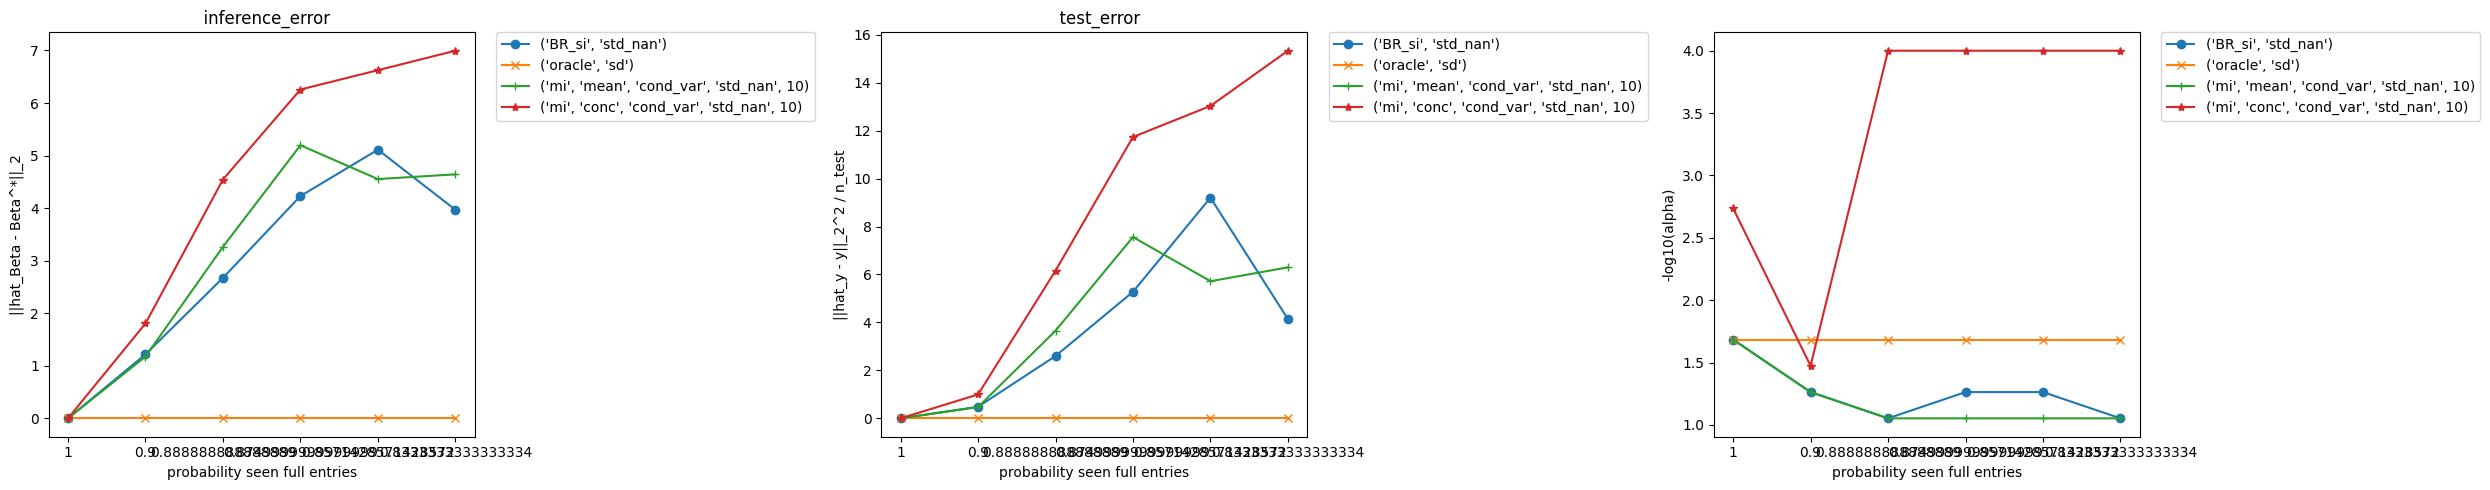

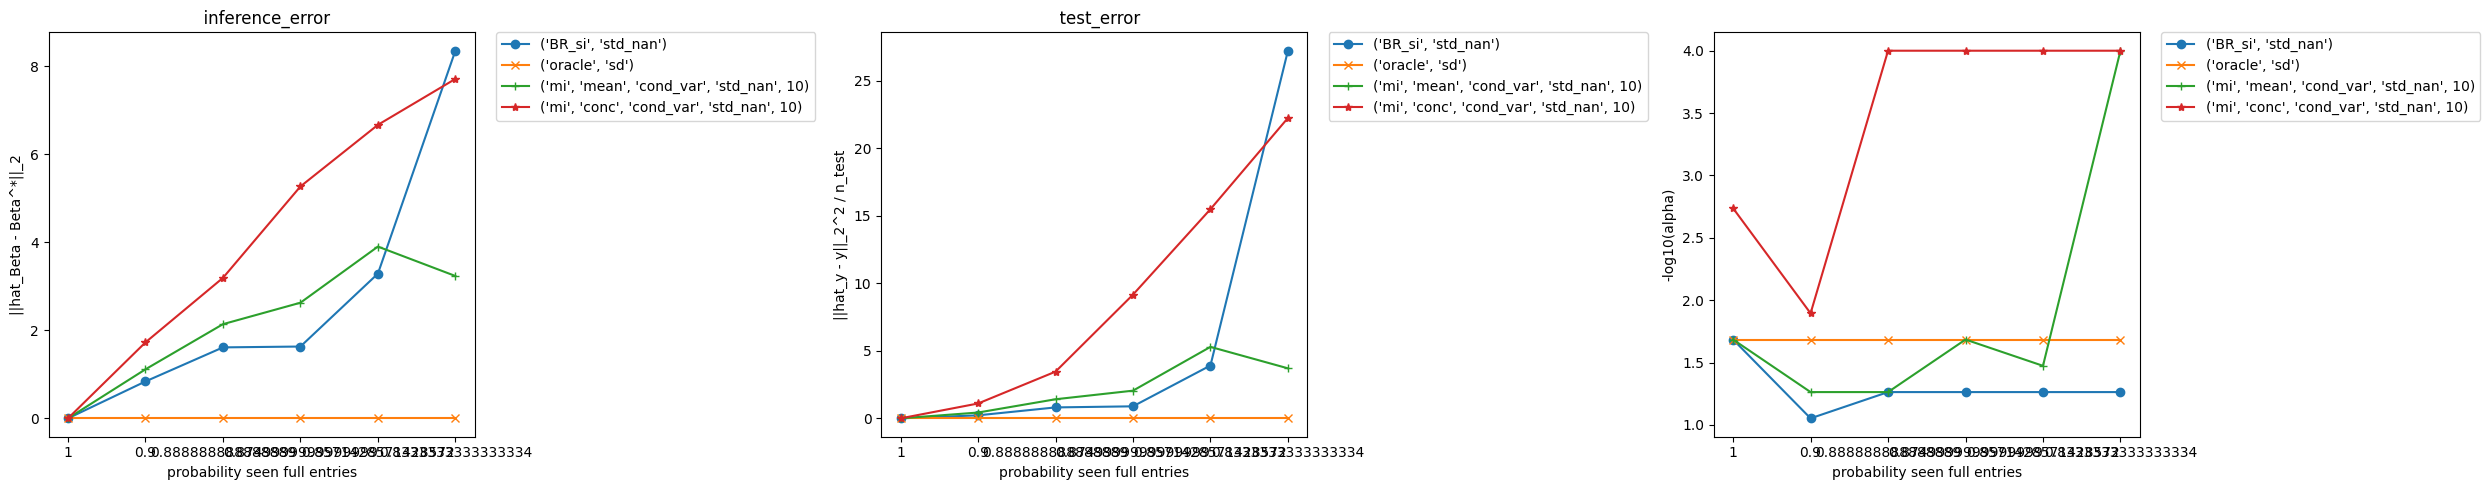

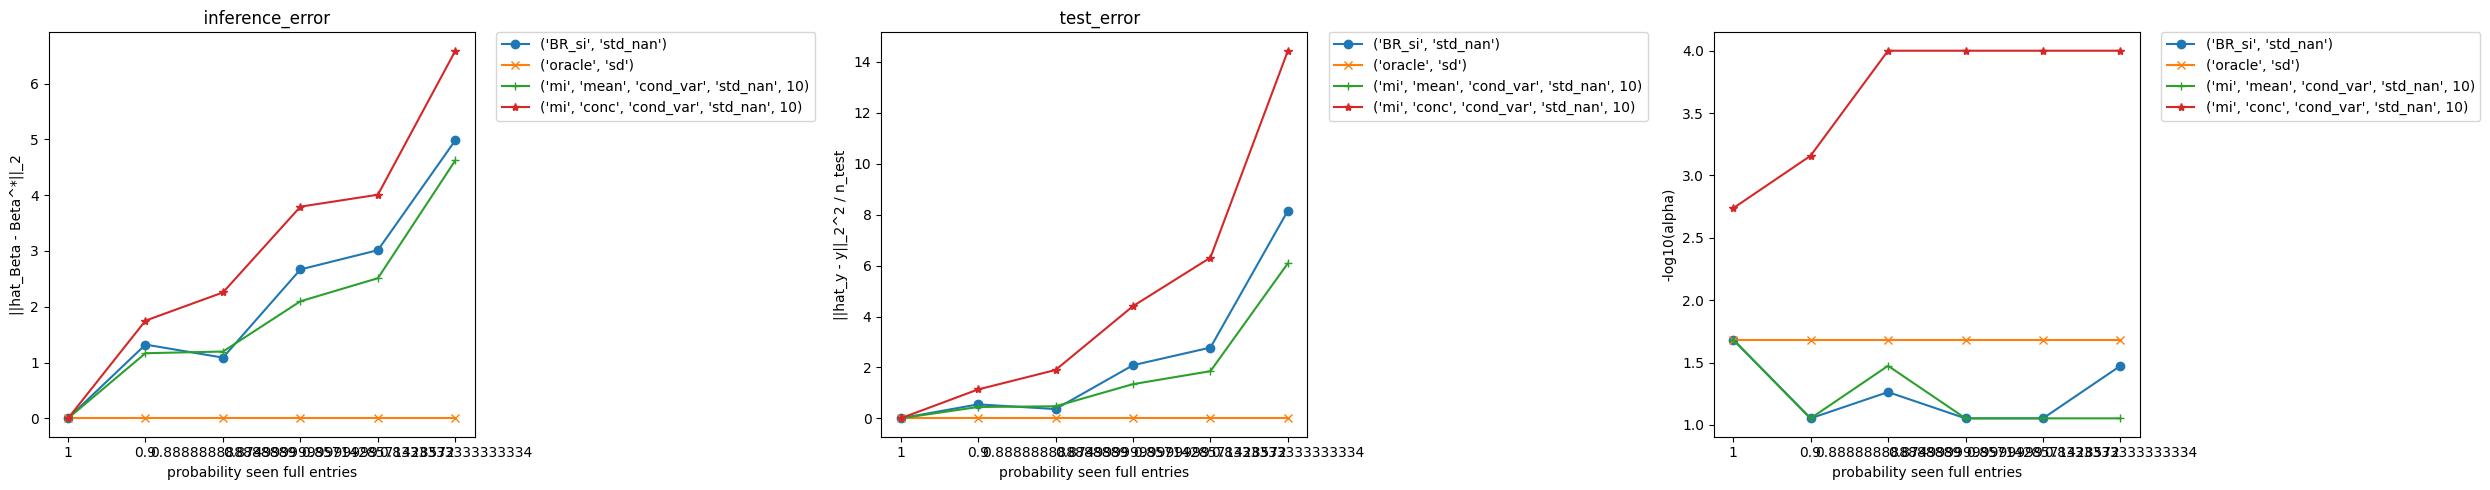

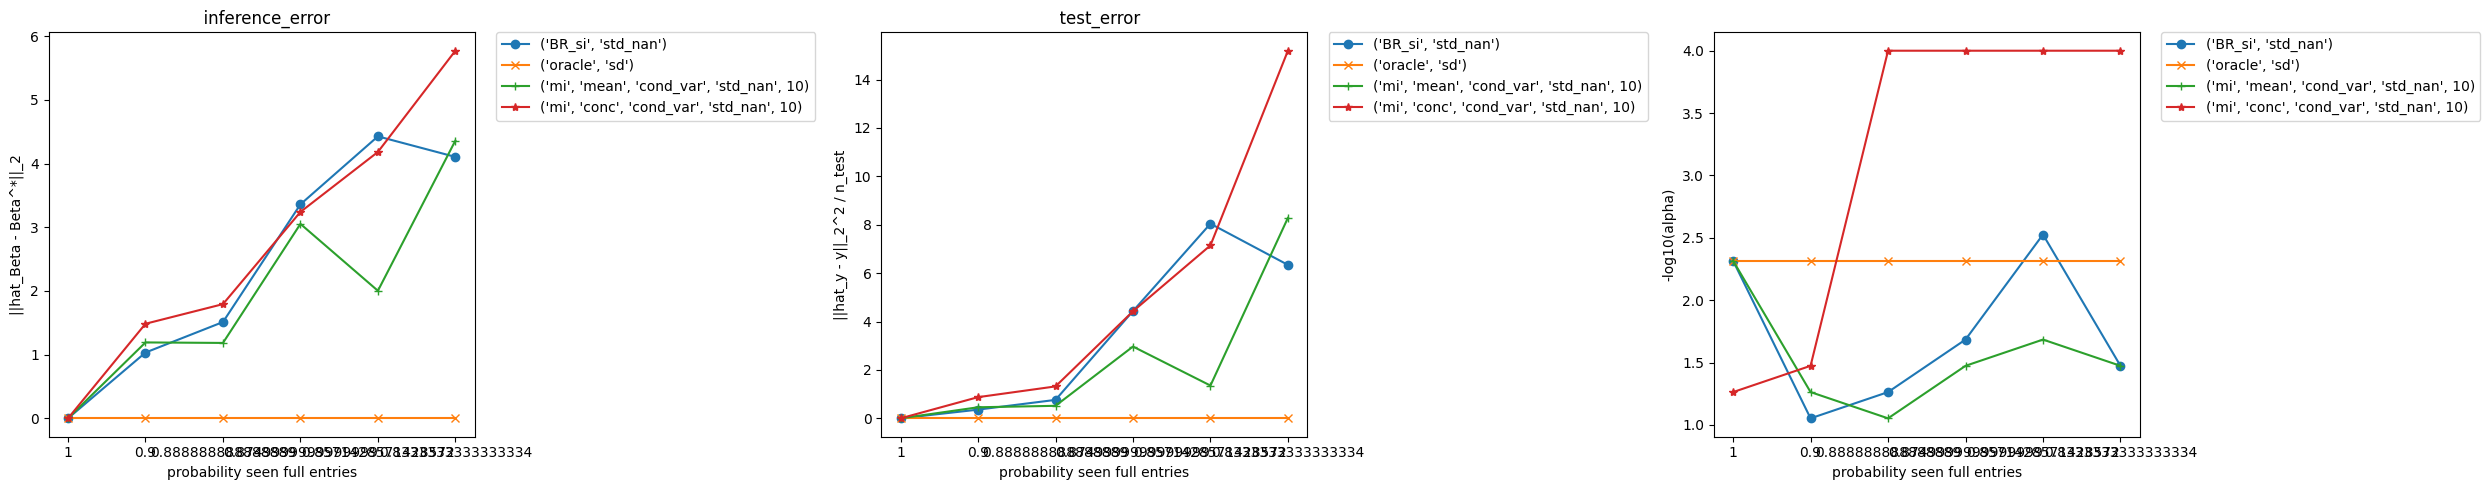

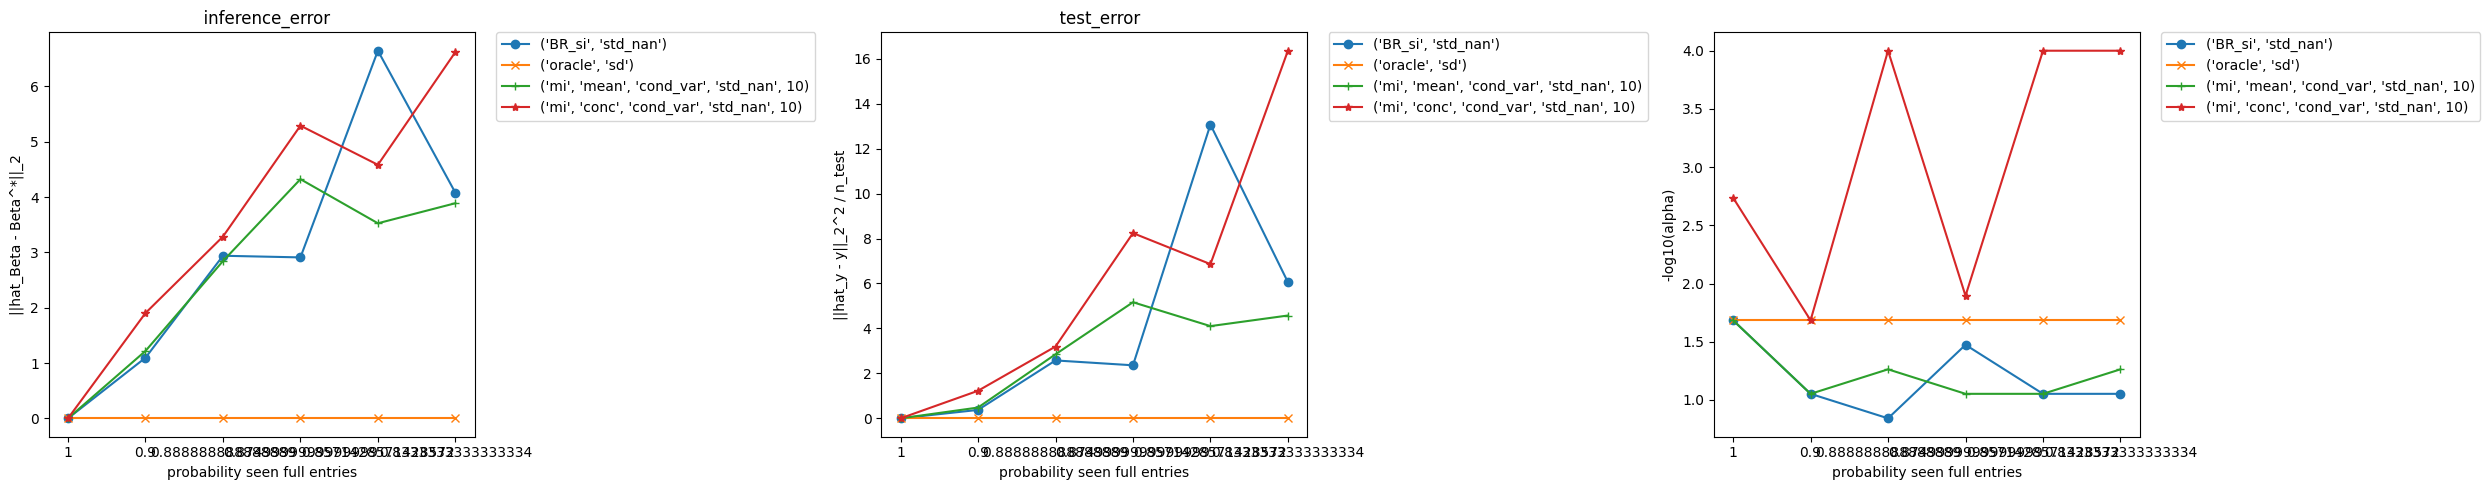

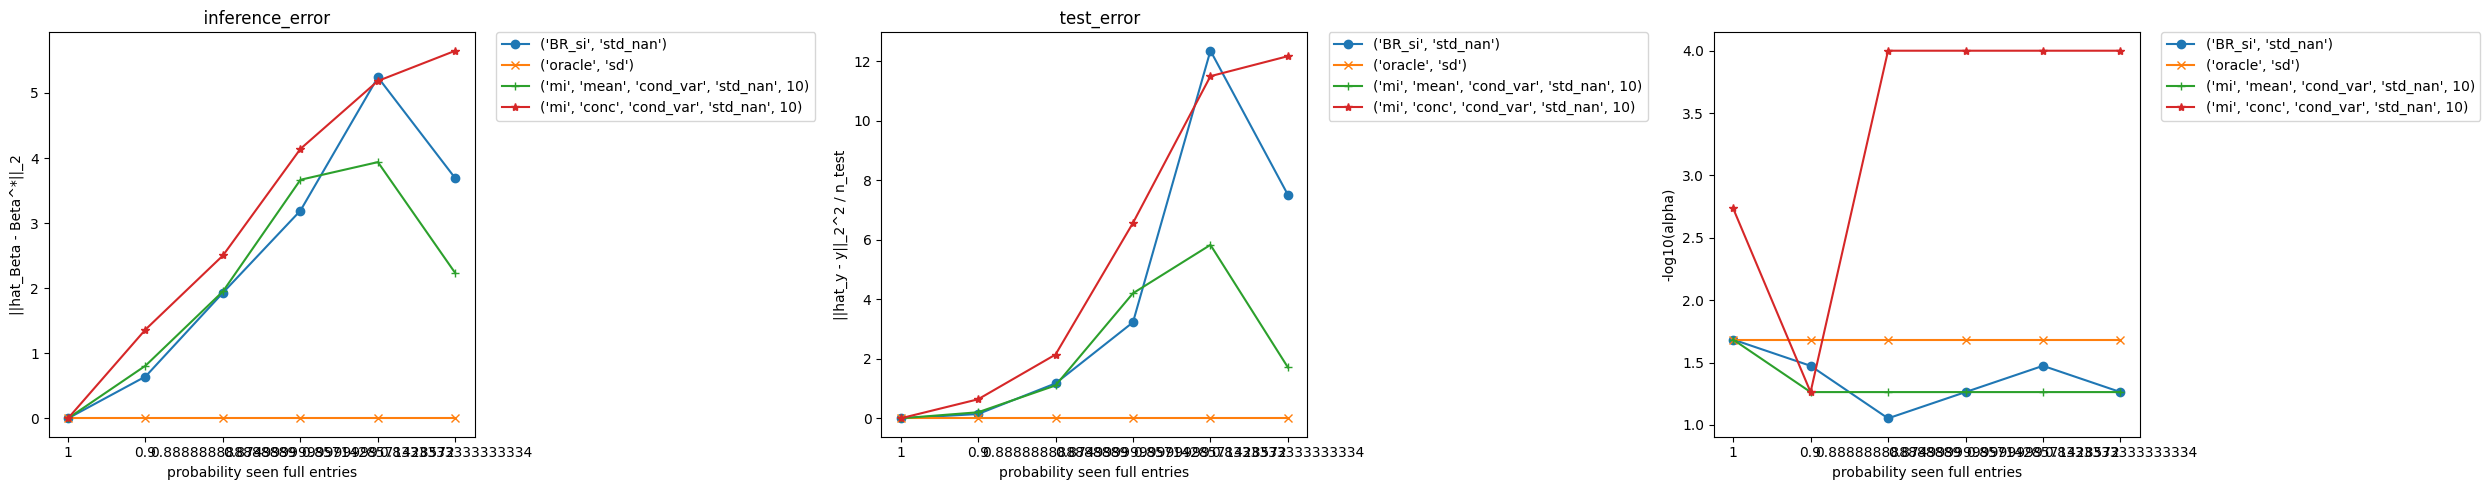

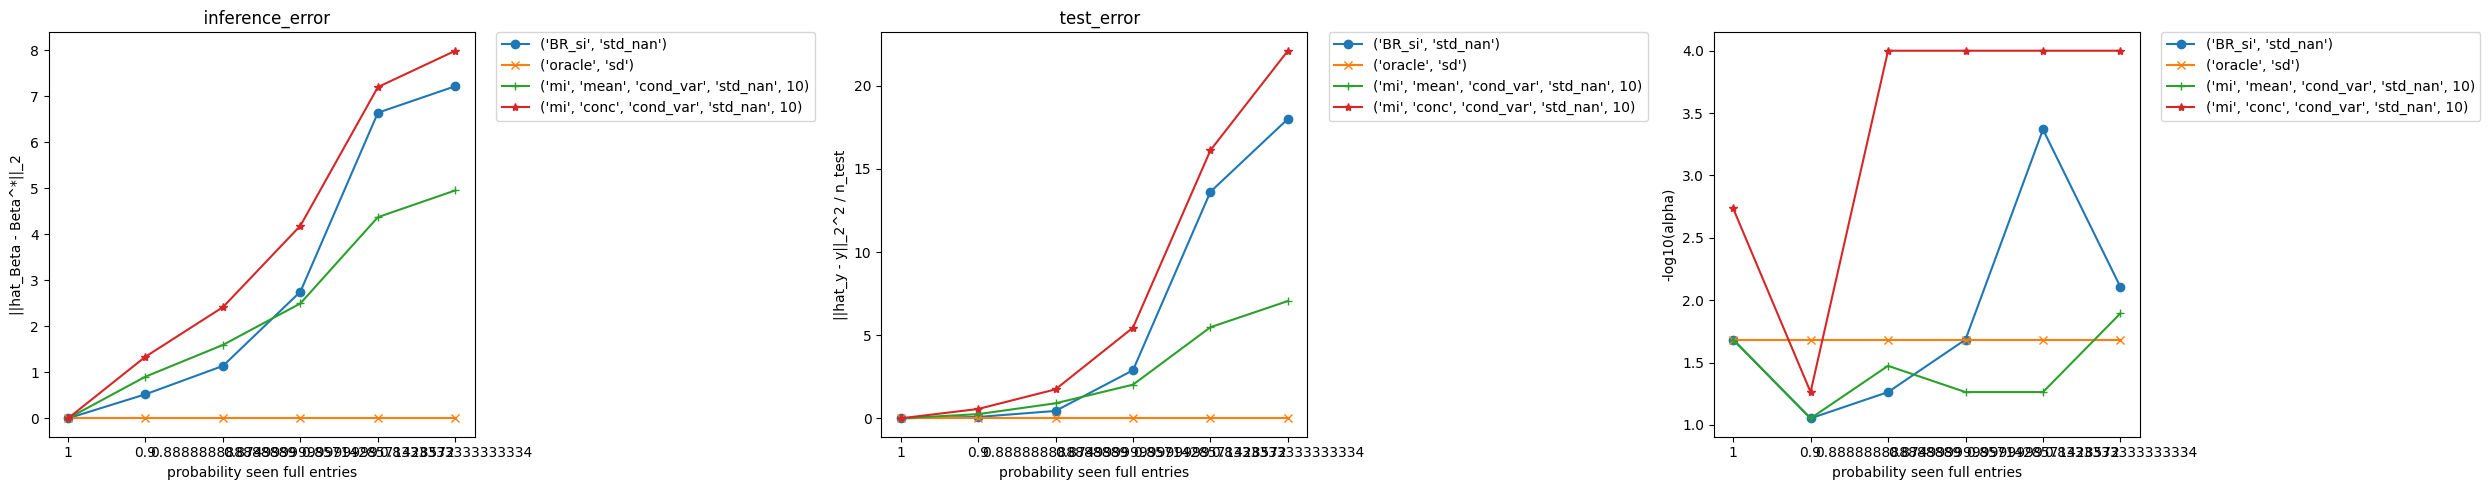

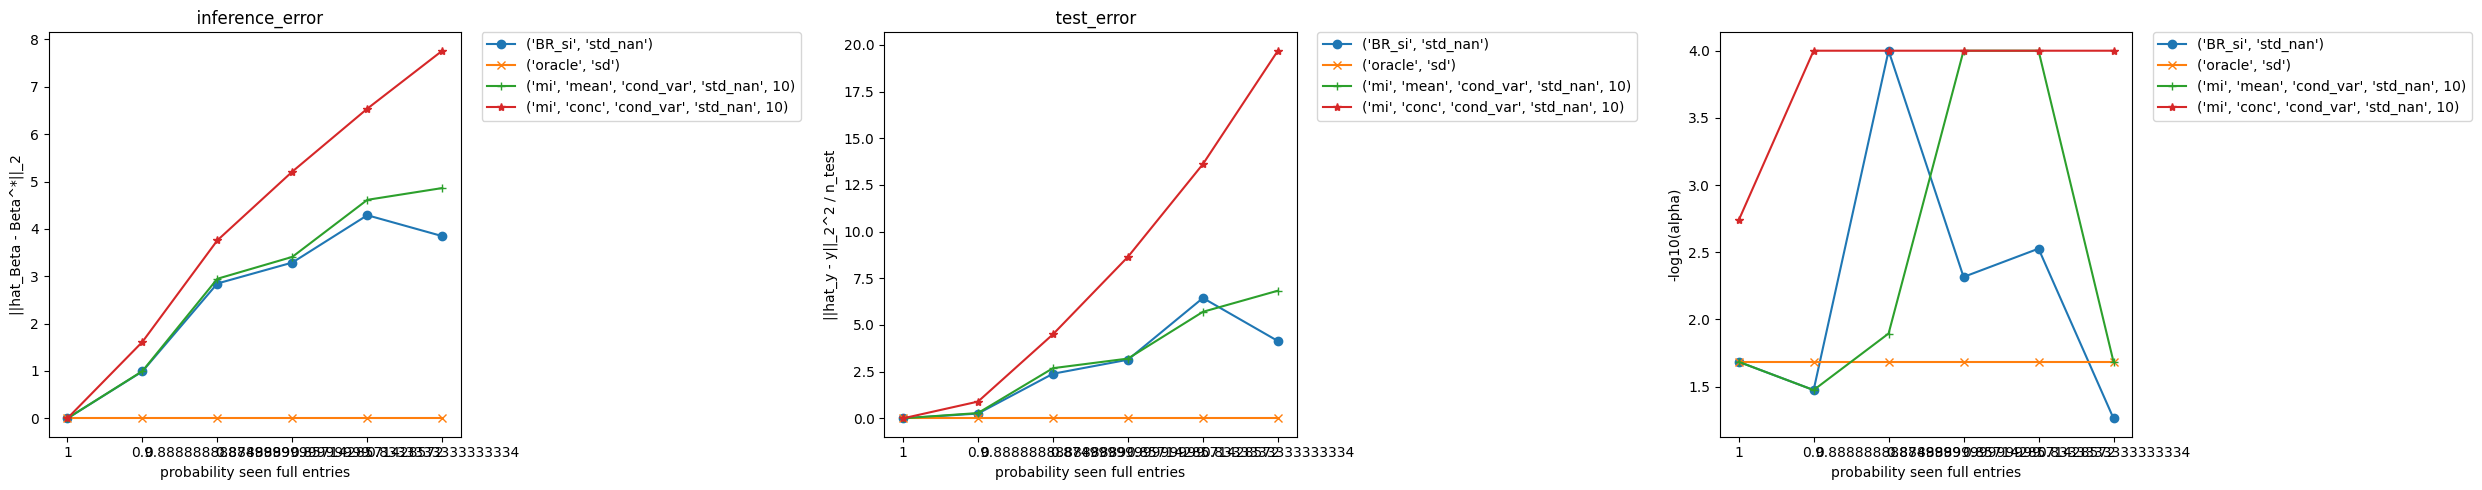

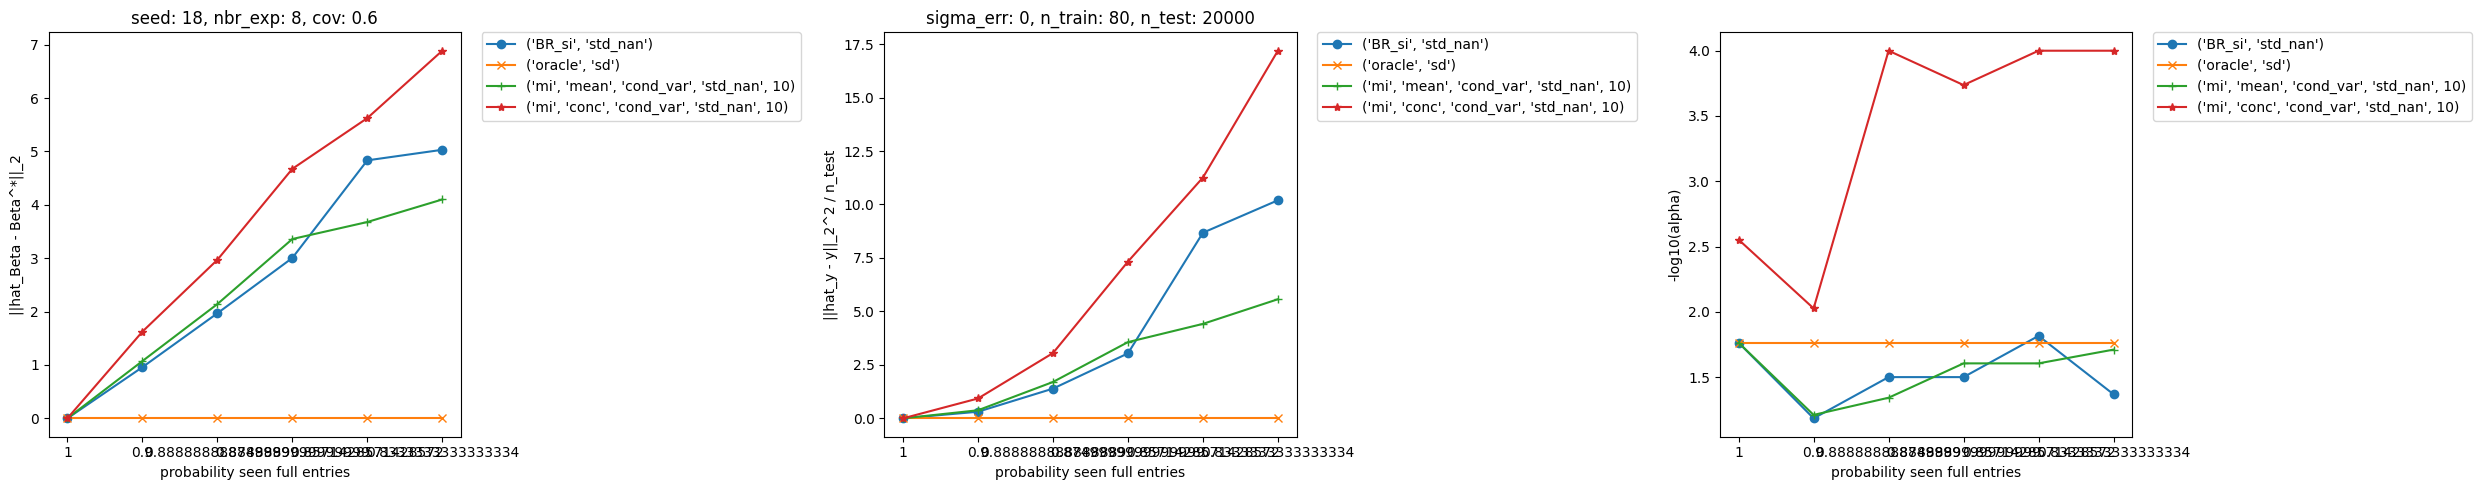

In [17]:

#info_axis = 'train'
#n_train = [400, 800, 1200, 1600, 2000]
#p_seen = make_probabilities([0.8, 0.8, 0.8, 0.8, 0.8])
#main_vec = n_train if info_axis == 'train' else p_seen
#info_x_axis = make_info_axis(main_vec, info_axis)

# def get_path(X, y, estimator, amax, dts_max, mis_max, S_dict, eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):
gen = 'fixed'
info_axis = 'p_seen'  # train or p_seen
#p_seen_both = [1, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50, 0.45, 0.40, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.02]
#p_seen_both = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
p_seen_both = [1, 0.9, 0.8/0.9, 0.7/0.8, 0.6/0.7, 0.5/0.6]
#p_seen_both = [0.1]
#p_seen_both = [1, 0.9, 0.8]
length_vec = len(p_seen_both)
#n_train = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
n_train = [80] * length_vec
error_vec =  [0] * length_vec
#p_seen = make_probabilities(p_seen_both)
p_seen = [p_seen_both] * length_vec
if info_axis == 'train':
  main_vec = n_train
elif info_axis == 'p_seen':
  main_vec = p_seen_both
elif info_axis == 'error':
  main_vec = error_vec
#main_vec = n_train if info_axis == 'train' else p_seen_both
info_x_axis = make_info_axis(main_vec, info_axis)
number_test = 20000
cov_var = 0.6
beta_gt = np.array([-0.5, 2, 1, 3, -2, -3, 4, 0.5, 7, -9])
dim = len(beta_gt)
mean = np.array([0] * dim)
matr = np.random.randn(dim, dim) * 0.1
cov = matr.T @ matr + np.eye(dim) * 0.25
# np.array([[1, cov_var], [cov_var, 1]])

dicc = make_dictionary_data(
    nbr_experiments= len(main_vec), n_train = n_train, n_test=number_test,
    data = {'data': 'Normal', 'mean': mean, 'cov': cov},
    beta_gt = beta_gt,
    p_miss = p_seen,
    err_vector = ['Gaussian_on_X', error_vec],
    plots = []#['points', 'l1_vs_coef', '1/alpha_vs_coef']
)
#dicc = dicc | {'generation':gen}
dicc = dicc | {'generation': gen, 'title_infer_error':'  inference_error', 'title_test_error':'  test_error'}
dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 0, 'eps_adv_rad_times_delta_dts': 1e-4, 'eps_adv_rad_times_delta_mis': 1e-4, 'n_a_dts': 20, 'n_a_mis':1}}

for key, value in dicc.items():
  print(key, ": " , value)

# (imp method, cov strategy, mi_nbr)
#list_imp_cov_methods = [('BR_si', 'sd'), ('l_d', 'sd'), ('mi', 'sd', 1)]

#list_methods_strategy = make_dictionary_method(list_imp_cov_methods)
mi_nbr = 10
# def get_path(X, y, estimator, amax, dts_max, mis_max, S_dict, eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):

list_methods_strategy = [{'imp_method': 'BR_si', 'cov_strategy': 'std_nan'},#, 'multip_dataset': 3, 'multip_missing':0},
                        #{'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing':3},
                        {'imp_method': 'oracle', 'cov_strategy': 'sd'},#, 'multip_dataset': 3, 'multip_missing': 0},
                        #{'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 3},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'eye', 'mi_nbr': 2},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'cond_var', 'cov_strategy_within': 'sd', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 1},
                        #{'imp_method': 'mi_mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'eye', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 0, 'multip_with': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.2},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.4},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.6},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 0, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 0, 'multip_missing': 1},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 3, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_mi', 'mi_nbr': mi_nbr, 'multip_dataset': 3, 'multip_missing': 1},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr}, #, 'multip_dataset': 3, 'multip_missing': 3},
                        {'imp_method': 'mi', 'post_imp':'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr}#, 'multip_dataset': 3, 'multip_missing': 3}
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 5},
                        ]
print(list_methods_strategy)
for el in list_methods_strategy:
  for key, value in el.items():
    print(key,": " , value)

print("----> Starting experiments")

'''
nbr_exp = 2
#res[key_tuple]['l2_dist_best_coeff_gt'].append(l2_dist)
#res[key_tuple]['best_coeff'].append(coeff_round)
#res[key_tuple]['best_score'].append(score_round)
#res[key_tuple]['best_alpha'].append(alpha_round)
res_l2 = []

rdm_seed = 4654321
np.random.seed(rdm_seed)
res = run_experiments(dicc, list_methods_strategy)
plot_res(info_x_axis, res, dicc)
if nbr_exp > 1:
  for k in res:
    for h in res[k]:
      res[k][h] = [res[k][h]]
  for i in range(nbr_exp-1):
    print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
    #np.random.seed(rdm_seed * (i+2))
    res_partial = run_experiments(dicc, list_methods_strategy)
    plot_res(info_x_axis, res_partial, dicc)
    print(res)
    for k in res:
      res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
      res[k]['best_score'].append(res_partial[k]['best_score'])
      res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
      #res[k]['best_coeff'].append(res_partial[k]['best_coeff
    #res.append(res['l2_dist_best_coeff_gt'])

print("final ")
print(res)
for k in res:
  print(k)
  print(np.array(res[k]['l2_dist_best_coeff_gt']))
  print(np.mean(np.array(res[k]['l2_dist_best_coeff_gt']), axis=0))
  print(np.mean(res[k]['l2_dist_best_coeff_gt'], axis=0))
#mean_res = {k: np.mean(v, axis=0) for k, v in res.items()}
mean_res = {k: {v: np.mean(w, axis=0) for v, w in res[k].items()} for k in res}
for k, v in mean_res.items():
  print("k:   ", k)
  for s, t in v.items():
    print(s, ": ", t)
#print(np.mean(res, axis=0))
'''
nbr_exp = 8
seed = 18
mean_res = run_multiple_experiments(nbr_exp, seed, dicc, info_x_axis)
print("PLOT OF THE MEANS")
dicc['title_infer_error'] = 'seed: ' + str(seed) + ', nbr_exp: ' + str(nbr_exp) + ', cov: ' + str(cov_var)
dicc['title_test_error'] = 'sigma_err: ' + str(error_vec[0]) + ', n_train: ' + str(n_train[0]) + ', n_test: ' + str(number_test)
#dicc = dicc | {'generation':gen, 'title_infer_error':'mean_infer_error, rep: ' + str(nbr_exp), 'title_mean_error':'mean_test_error'}
plot_res(info_x_axis, mean_res, dicc)

## you can see if you manage to take the index i that maximize alpha




In [ ]:
X = np.random.randint(2, 5, size=(2, 2, 2))
print(X)

XX = np.concatenate(X)
print(XX)


Y = np.random.randint(2, 5, size=(1, 3, 2))
print(Y)

YY = np.concatenate(Y)
print(YY)


Z = np.random.randint(2, 5, size=(5, 2))
print(Z)

ZZ = np.concatenate(Z)
print(ZZ)

print("other")
s = np.random.randint(2, 4, 5)
print(s)
z = np.tile(s, reps=3)  # np.array([s] * 2)
print(z)


print("other mult")
s = np.random.randint(2, 8, size=(3, 2))
print(s)
z = np.tile(s, reps=(3, 1))  # np.array([s] * 2)
print(z)


In [ ]:
'''
## random forest imputer
from sklearn.ensemble import RandomForestRegressor
rf_estimator = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, max_samples=0.5, n_jobs=2, random_state=0)

X_rf = single_imputation(X_nan, rf_estimator)
print(X_rf.shape)
sd_rf = np.std(X_rf, axis=0)
S_inv_rf = np.diag(1 / sd_rf)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std rf\n ", sd_rf)
fig, ax = plt.subplots(num='advtrain_linf_rf')
linfadvtrain_rf = AdversarialTraining(X_rf, y, S_inv_rf, p=np.inf)
estimator_rf = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)
alphas_adv, coefs_advtrain_linf_rf  = get_path(X_rf, y, estimator_rf, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_rf, ax)
'''

In [ ]:
'''
## iterative imputer Bayesian Ridge

from sklearn.linear_model import BayesianRidge
br_estimator = BayesianRidge()

X_br = single_imputation(X_nan, br_estimator)
sd_br = np.std(X_br, axis=0)
S_inv_br = np.diag(1 / sd_br)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std  br\n ", sd_br)

fig, ax = plt.subplots(num='advtrain_linf_br')
linfadvtrain_br = AdversarialTraining(X_br, y, S_inv_br, p=np.inf)
estimator_br = lambda X, y, a:  linfadvtrain_br(adv_radius=a)
alphas_adv, coefs_advtrain_linf_br  = get_path(X_br, y, estimator_br, 1e4)
plot_coefs_l1norm(coefs_advtrain_linf_br, ax)
'''

In [ ]:
'''
## mean imputation
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_mean = imp_mean.fit_transform(X_nan)
sd_mean = np.std(X_mean, axis=0)
print(sd_mean)
S_inv_mean = np.diag(1 / sd_mean)

fig, ax = plt.subplots(num='advtrain_linf_mean')
linfadvtrain_mean = AdversarialTraining(X_mean, y, S_inv_mean, p=np.inf)
estimator_mean = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)
alphas_adv, coefs_advtrain_linf_mean  = get_path(X_mean, y, estimator_mean, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_mean, ax)
'''

In [ ]:
'''
# imputation elliptic

mu = np.nanmean(X_nan, axis=0)
print("means ", mu)
delta = np.mean(masks) # parameter missingness
print("delta ", delta)
X_0 = np.nan_to_num(X_nan)
print("nbr obs", X_0.shape[0])
S_ellp =  X_0.T @ X_0 / X_0.shape[0]
S_ellp = (1/delta - 1/(delta**2)) * np.diag(np.diag(S_ellp)) + 1/(delta**2) * S_ellp
print("eig cov ", np.linalg.eigvalsh(S_ellp))
X_ellp = imputation_elliptic(mu, S_ellp, X_nan, masks)
#S_inv_ellp = np.linalg.inv(S_ellp)  # other variance
sd_inv_ellp = np.std(X_ellp, axis=0)
print("sd ellp", sd_inv_ellp)

fig, ax = plt.subplots(num='advtrain_linf_ellp')
linfadvtrain_ellp = AdversarialTraining(X_ellp, y, S_ellp, p=np.inf)
estimator_ellp = lambda X, y, a:  linfadvtrain_ellp(adv_radius=a)
alphas_adv, coefs_advtrain_linf_ellp  = get_path(X_ellp, y, estimator_ellp, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_ellp, ax)
'''

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


# Example data
x_test_rect = np.random.rand(10)
y_test_rect = np.random.rand(10)

# Plot the points
fig, ax = plt.subplots()
ax.scatter(x_test_rect, y_test_rect)

width = 0.1
height = 0.1

add_rectangles(x_test_rect, y_test_rect, width, height, ax)

# Add the rectangle to the plot


In [ ]:
# Cell for some tests

def test_clear_dataset(n, d):
  print("test clear dataset")
  X = np.random.randint(1, 3, size=(n, d))
  y = np.random.randint(1, 3, size=n)
  masks = np.random.binomial(1, 0.3, size=(n, d))
  print("X \n", X)
  print("y\n", y)
  print("masks \n", masks)
  masks[:, 0] = np.ones(n)
  masks[0, :] = np.ones(d)
  X_res, y_res, masks_res = clear_dataset(X, y, masks)
  print("X_res \n", X_res)
  print("y\n", y_res)
  print("masks \n", masks_res)
  print("test clear dataset ended successfully")

def test_generate_X():
    print("test generate_X started")
    fig, ax = plt.subplots(3, 1, figsize=(10, 8), num='advtrain_linf')
    gen = generate_X('circles', 2)
    data = gen(1000)
    print(data.shape)
    ax[0].scatter(data[:, 0], data[:, 1])
    print("test generate passed syccessfully")

def test_preparation_dataset(n, d):
      print("\ntest preparation dataset started")
      X_train = np.random.rand(n, d)
      print("X_train \n", X_train)
      mask = np.random.binomial(1, 0.5, (n, d))
      print("mask, 0 seen, 1 missing \n ", mask)
      X_masked = X_train * (1 - mask)
      print("X_masked \n", X_masked)
      X_nan_train = X_train.copy()
      X_nan_train[mask == 1] = np.nan
      print("X_nan_train \n", X_nan_train)
      X_br_train = single_imputation(X_nan_train, BayesianRidge())
      print("X_br_train\n ", X_br_train)

      print("what happens if we run single_imputation of full dataset")
      X_br_full = single_imputation(X_train, BayesianRidge())
      print("X_br_full\n ", X_br_full)
      np.testing.assert_allclose(X_train, X_br_full)  # shuold be untouched
      print("test preparation dataset ended successfully")

def test_listwise_delection(n, d):
    print("\n test list_wise delection started")
    X = np.random.rand(n, d)
    print("data\n", X)
    mask = np.random.binomial(1, 0.2, (n, d))
    print("mask \n", mask)
    X_ld = listwise_delection(X, mask)
    print("after calling function, X_ld \n", X_ld)

    print("edge cases, all missing")
    mask_1 = np.ones_like(X)  # all missing
    X1 = listwise_delection(X, mask_1)
    print("X1 \n", X1)  # should be empty
    mask_0 = np.zeros_like(X)  # all seen
    X0 = listwise_delection(X, mask_0)
    print("X0 \n", X0)
    np.testing.assert_allclose(X0, X)  # should be the original dataset

    print("one dimnsional array")
    y = np.random.rand(n)
    print("y before ", y)
    y_ld = listwise_delection(y, mask)
    print("y after ld ", y_ld)
    print("test listwise_delection passed")


test_generate_X()
test_preparation_dataset(3, 4)
test_listwise_delection(3, 4)
test_clear_dataset(6, 3)

xxx = np.random.randint(2, 5, size=(3, 3)) * 1.0
mmm = np.random.binomial(1, 0.5, size=(3, 3))
print(xxx)
print(mmm)
print(mmm == 1)
print(xxx[mmm == 1])
xxx[mmm == 1] = np.nan
print(xxx)
mask_from_xxx = np.isnan(xxx).astype(int)
print("mask from xxx \n", mask_from_xxx)


In [ ]:
# test best predictor

def test_best_predictor(n, d, nb_coeff):
  X_test = np.random.randint(1, 9, size=(n, d))
  beta_gt_test = np.random.randint(1, 7, size=d)
  y_test = X_test @ beta_gt_test
  #print("X_test \n", X_test, "\n beta_gt", beta_gt_test, "\n y_test = X_test @ beta_gt_test ", y_test)
  coeff_test = np.random.randint(1, 5, size=(d, nb_coeff))
  rdm_idx = np.random.randint(1, d+1, size=1)
  print(rdm_idx)
  #print("coeff test partial ", coeff_test[:, -1])
  rng = np.arange(nb_coeff)
  #print(rng != rdm_idx)
  coeff_test[:, rng != rdm_idx] = coeff_test[:, rng != rdm_idx] + 1000  # increase artificially the value of the other coefficient, to induce the minimum index to be rdm_idx
  #print("coeff_test \n", coeff_test)
  best_coeff, best_score = best_predictor(X_test, coeff_test, y_test)
  print("best coeff ", best_coeff)
  print("best score ", best_score)
  np.testing.assert_allclose(best_coeff, coeff_test[:,rdm_idx].squeeze())
  print("test best predictor passed")

test_best_predictor(100, 5, 20)




In [ ]:
# test train_and_plot

X_diab, y_diab = datasets.load_diabetes(return_X_y=True)
n, d = X_diab.shape
print("n:  ", n, ", d: ", d)
# Standardize data
X_diab -= X_diab.mean(axis=0)
X_diab /= X_diab.std(axis=0)

## original lasso
fig_l, ax_l = plt.subplots(num='lasso')
alphas_lasso, coefs_lasso, _ = get_lasso_path(X_diab, y_diab)
plot_coefs_l1norm(coefs_lasso, ax_l)

## Antonio's algo, 1 matrix
S_diab_eye = np.eye(X_diab.shape[1])
fig, ax_1 = plt.subplots(1, 1, num='advtrain_linf_diab')
fig, ax_2 = plt.subplots(1, 1, num='advtrain_linf_diab_2')
train_and_plot(X_diab, y_diab, S_diab_eye, [ax_1, ax_2])

## Antonio's algo, multiple diagonal matrix
#S_diab = np.eye(X_diab.shape[1])
#S_diab = np.random.randint(1, 3, size=(n, d))
#print(S_diab)
#fig, ax_5 = plt.subplots(1, 1, num='advtrain_linf_diab_5')
#fig, ax_6 = plt.subplots(1, 1, num='advtrain_linf_diab_6')
#train_and_plot(X_diab, y_diab, S_diab, [ax_5, ax_6])


## Antonio's algo, multiple matrices (same matrix stacked multiple time)
S_diab_stacked = np.array([S_diab_eye] * X_diab.shape[0])
S_diab_stacked = np.concatenate(S_diab_stacked)
fig, ax_3 = plt.subplots(1, 1, num='advtrain_linf_diab_3')
fig, ax_4 = plt.subplots(1, 1, num='advtrain_linf_diab_4')
train_and_plot(X_diab, y_diab, S_diab_stacked, [ax_3, ax_4])




In [ ]:
# test imputations

np.random.seed(45)


def test_imputations(n, d):
  X = np.random.randint(2, 5, size=(n, d)) * 1.0
  y = X @ np.random.randint(1, 3, size=d)
  m = np.random.binomial(1, 0.4, size=(n, d))  # 1 missing, 0 seen
  print("m original\n", m)
  X, y, m = clear_dataset(X, y, m)
  print(m)
  X_nan = X.copy()
  X_nan[m == 1] = np.nan

  #mask_from_xxx = np.isnan(xxx).astype(int)
  print("X\n ", X)
  print("masks \n", m)
  print("X_nan\n ", X_nan)
  methods = ['BR_si', 'mi', 'l_d']
  nbr_mi = [1, 3]
  #for method in methods:
  #  dict_info = {'imp_method': method, 'mi_nbr':nbr_mi}
  #dict_info = {'imp_method':methods, 'mi_nbr':nbr_mi}
  for method in methods:
    print("---------- method: ", method)
    if method == 'mi':
      for x in nbr_mi:
        print("-------------------- nbr mi: ", x)
        dict_info = {'imp_method':method, 'mi_nbr':x}
        #print("XNANNANAN ", X_nan)
        X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
        print(X_res, y_res, "\n", mask_res)
    else:
      dict_info = {'imp_method': method}
      X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
      print(X_res, y_res, "\n", mask_res)
    print("test imputations ended successfully")

test_imputations(6, 3)


In [ ]:
x = []
y = np.array([1, 2])
x.append(y)
x.append(y)
x.append(y)
xx = np.stack(x)
print(x)
print(xx)
print(type(xx))


import matplotlib.pyplot as plt

sizes = [100, 1000, 10000, 100000]
values = [0.8, 0.85, 0.9, 0.92]
positions = range(len(sizes))

plt.plot(positions, values, marker='o', label='Model Accuracy')  # Add label here
plt.xticks(positions, sizes)

plt.xlabel("Dataset Size (equispaced)")
plt.ylabel("Accuracy")
plt.title("Performance vs Dataset Size (equispaced x-axis)")
#plt.legend()  # Show legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()



In [ ]:

dictio = {'a':1, 'b':2, 'c':3}
vv = dictio.values()
#print(vv)
#print(vv[1])

x1 = np.array([1, 2, 3])
x2 = np.array([3, 2 ,1])
v = np.maximum(x1, x2)
print(v)


In [ ]:
m, n, d = 2, 3, 2
x_int = np.random.randint(1, 9, (m, n, d))
print(x_int)
s = np.std(x_int, axis=0)
print(s)

# manual
print("manual computation")
x = np.zeros((m, d))
for i in range(n):
  print("i -----> ", i)
  x = x_int[:, i, :]
  print("x\n", x)
  ss = np.std(x, axis=0)
  print(ss)


print("little exp on squeeze")
sss = np.random.rand(1, 3, 3)
print(sss)
print(sss.squeeze())
print(sss.squeeze())



In [ ]:
int(34.99)

xxxx = np.random.randint(2, 4, (5, 2))
print(xxxx)
xxxx[0:2, :] = 1
print(xxxx)

print("yyyy\n")
yy = []
yy.append([1, 2, 3])
yy.append([4, 5, 6])
print(yy)
print(np.stack( yy ).T)
print("\n\n")
yyy = np.random.randint(1, 10, size=(3 , 3))
print(yyy)
yyy_a = np.array([yyy] * 2)
print(yyy_a.shape)
print(np.concatenate([yyy] * 2))
#print(np.tile(yyy_a, (2, 1, 1) ))

zzz = np.zeros((2, 2))

np.sum(np.zeros((2, 2)) == zzz)

In [ ]:

def multiple_imputation1(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 1000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res shape", res.shape)
       #if nbr_mi == 1:
        #res = res[0, :, :]
        #print("fin res shape", res.shape)
    return res


Xx = np.random.randint(1, 3, (4, 4)) * 1.0
mm = np.random.binomial(1, 0.25, (4, 4))
print(Xx)
print(mm)
Xx[mm == 1] = np.nan
print(Xx)

ice = IterativeImputer(random_state=18, max_iter=50, sample_posterior=True)
ice.fit(Xx)
XxX = np.random.randint(1, 3, (2, 4)) * 1.0
mmM = np.random.binomial(1, 0.5, (2, 4))
print(XxX)
print(mmM)
XxX[mmM == 1] = np.nan
print(XxX)

print(ice.transform(XxX))
print(ice.transform(XxX))

print("new")

ls = [[[]],[[]]]
print(ls)
ls[0][0]



In [ ]:
import numpy as np

XX = np.random.randint(1, 7, (2, 3, 3))
print(XX)
XXX = np.tile(XX, (2, 1, 1))
print(XXX)

print(np.zeros(2))

y_o = np.array([1, 2])
y_oo = np.tile(y_o, 3)
print(y_oo)


In [ ]:
import numpy as np
def generate_masks_binomial_general(nbr_of_sample, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    masks = np.zeros((nbr_of_sample, 2))
    v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
    masks[v == 0, :] = np.array([0, 0])  # both seen
    masks[v == 1, :] = np.array([0, 1])  # left seen
    masks[v == 2, :] = np.array([1, 0])  # right seen
    return masks


#mm = np.random.binomial(1, [[0.2, 0.2, 0.2], [0.8, 0.8, 0.8]], (2, 3, 3))
#print(mm)
cc = np.array([np.random.binomial(1, x, (4, 4)) for x in [0.2, 0.2, 0.2]])
print(cc)
s_cc = np.cumsum(cc, axis=0)
print(s_cc)
s_cc[s_cc>1] = 1
print(s_cc)

